In [ ]:
#File description & paths to csv's

#IMPORTANT: LATE_ALL has been set 90 days and older

"""
Code is divided into the following sections:
1. Import data & create dataframes:
    -credit_records_o contains credit_records from csv file, same structure as in the file
    -application_records_o contains data from application csv, file same structure as in the file
    -credit_records_p is wide form of credit_records_o 
2. Enrich credit data with start, end, duration, count of individual statues (0_count, 1_count... 5 ratio) and count all statuses (all_late_count),
ratio of individual status (0_ratio, 1_ratio... 5_ratio) and all late statuse ratio (all_later_ratio)
    - credit_records_p_labelled 
2A. Enrich credit data with Acitve & TOTAL_STATUS & GOOD_BAD CLIENT
3. Merge app & labelled credit data and calculate bins for discrete variables (birth date, employment date & amount income)
    - app_and_credit_label_2
4. Functions for GUI in IPWIDGET that take & store user input from ipywidgets
5. IPWIDGET GUI for data exploration taking filters & drawing graphs:
    - use final_layout to make it run
6 - 9. Compare bad clients ratio per feature pairs (FLAG PHONE,FLAG_EMAIL,OCCUPATION_TYPE, CNT_FAM_MEMBERS vs all other) with pivot table and bar charts
10 - 13. Compare bad clients ratio per feature pairs (FLAG PHONE,FLAG_EMAIL,OCCUPATION_TYPE, CNT_FAM_MEMBERS vs all other) with pivot table and bar charts
14. DASH GUI - taking 2 features vs 1 target and drawing 4 charts (bar charts & heatmap showign feature vs target, histograms for 1 feature and for 1 target)
15. ANOTHER DASH GUI - taking 2 features vs 2 target and drawing 4 charts (bar chart & heatmap showing features vs 1 and the other target)
"""

path_to_credit_records_csv='C:\\Users\\User\\OneDrive\\Desktop\\Kurs\\Projekt\\Python\\Dane\\credit_record.csv' #replace with your path to credit records.csv
path_to_application_records_csv='C:\\Users\\User\\OneDrive\\Desktop\\Kurs\\Projekt\\Python\\Dane\\application_record.csv' #replace with your path to credit records.csv

import csv
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt 
import seaborn as sns
import ipywidgets as widgets

In [ ]:
### 1. Import of data & dataframe def 
import csv
import pandas as pd

#create credit_records_o from data in csv
file=open(path_to_credit_records_csv) 
credit_records_o=pd.read_csv(file) 
file.close()

#create application_records_o from data in csv
file=open(path_to_application_records_csv) 
application_records_o=pd.read_csv(file) 
file.close()

#create wide version of credit_records
credit_records_p=pd.pivot(credit_records_o, index='ID',columns='MONTHS_BALANCE',values='STATUS') 
credit_records_p = credit_records_p[credit_records_p.columns.sort_values(ascending=False)] #reorder months balance column in descending order

In [ ]:
### 2. Enrich credit data and define labels 

from collections import Counter
p=credit_records_p.copy() 

#add colulmns with val_count(count of statuses), start (first month of loan), end (last month of loan), duration (loan duration)
p['val_count']=p.apply(lambda x: Counter(x),axis=1) 
grouped_id=credit_records_o.groupby('ID')
p['start_mth']=grouped_id['MONTHS_BALANCE'].min()
p['end_mth']=grouped_id['MONTHS_BALANCE'].max()
p['duration']=abs(p['start_mth']-p['end_mth'])+1 

#add columns with 0,1,2,3,4,5 statuses count and their ratios per client
p['0_count']=p['val_count'].apply(lambda x: x.get('0',0)) 
p['0_ratio']=p['0_count']/p['duration'] 
p['1_count']=p['val_count'].apply(lambda x: x.get('1',0)) 
p['1_ratio']=p['1_count']/p['duration'] 
p['2_count']=p['val_count'].apply(lambda x: x.get('2',0))
p['2_ratio']=p['2_count']/p['duration'] 
p['3_count']=p['val_count'].apply(lambda x: x.get('3',0))
p['3_ratio']=p['3_count']/p['duration'] 
p['4_count']=p['val_count'].apply(lambda x: x.get('4',0))
p['4_ratio']=p['4_count']/p['duration'] 
p['5_count']=p['val_count'].apply(lambda x: x.get('5',0))
p['5_ratio']=p['5_count']/p['duration'] 
# p['all_late_count']=p['val_count'].apply(lambda x: x.get('0',0)+x.get('1',0)+x.get('2',0)+x.get('3',0)+x.get('4',0)+x.get('5',0)) 
p['all_late_count']=p['val_count'].apply(lambda x: x.get('2',0)+x.get('3',0)+x.get('4',0)+x.get('5',0)) 
p['all_late_ratio']=p['all_late_count']/p['duration'] 
p['all_late_flag']=p['all_late_ratio'].apply(lambda x: 1 if x>0.25 else 0)

credit_records_p_labelled=p.copy()


In [ ]:
### 2A. Encirh credit data with Mateusz method
df=credit_records_o.copy() 

df["MONTHS_BALANCE"] = df["MONTHS_BALANCE"].abs()

df_last = df.groupby(by="ID")["MONTHS_BALANCE"].min().reset_index(name="LAST_RECORD")
df = pd.merge(df, df_last, on="ID", how="left")

df_all = df.groupby(by="ID")["MONTHS_BALANCE"].count().reset_index(name="NUMBER_OF_RECORDS")
df = pd.merge(df, df_all, on="ID", how="left")

df["MONTHS"] = df["MONTHS_BALANCE"] - df["LAST_RECORD"]

def account_activity(ID, last_record):
    
    """
    Funkcja zwracająca obecny stan konta klienta.
    Konto aktywne - 1
    Konto nieaktywne - 0
    """
        
    if last_record == 0:
        active = 1
    else:
        active = 0
        
        
    return active

df_upgrade = df.copy()
df_upgrade["ACTIVE"] = df_upgrade.apply(lambda df: account_activity(df["ID"], df["LAST_RECORD"]), axis=1)

def month_weight(month, number_of_records):
    
    """
    Funkcja przyporządkowująca wagę danemu miesiącu (month) z uwzględnieniem liczby wszystkich miesięcy (number_of_months).
    Wagi maleją w sposób liniowy, a ich suma daje 1.
    """
    
    k = abs(month) + 1
    n = number_of_records
    
    if n < 4:
        weight = 0
    elif 4 <= n <= 24:
        weight = -2*k/(n*(n+1))+2/n
    else:
        n = 24
        if k <= 24:
            weight = -2*k/(n*(n+1))+2/n
        else:
            weight = 0
              
                
    return weight

def status2number(month, status, number_of_records):
    
    """
    W oparciu o funkcję month_weight, status2number przekształca status z wybranego miesiąca na liczbę z przedziału <-1,1>.

    """
    
    if month <= 23:
        weight = month_weight(month, number_of_records)

        if status is "5":
            value = -1
        elif status is "X":
            value = 0
        elif status is "C":
            value = 1
        else:
            n = int(status)
            value = 1/2**(n+1)-1
    else:
        weight = 1
        value = 0
    
    
    return weight * value

df_upgrade["PARTIAL_STATUS"] = df_upgrade.apply(lambda df: status2number(df["MONTHS"], df["STATUS"], df["NUMBER_OF_RECORDS"]), axis=1)

df_status = df_upgrade.groupby(by = "ID")["PARTIAL_STATUS"].sum().reset_index(name="TOTAL_STATUS")

df_credit = pd.merge(df_upgrade, df_status, on="ID", how="left")

def good_bad_function(ID, status):
    
    """
    Funkcja określająca czy dany klient może otrzymać kredyt.
    """
    
    if status >= 0:
        judgment = 1
    else:
        judgment = 0
    
    
    return judgment

df_credit["GOOD_BAD"] = df_credit.apply(lambda df: good_bad_function(df["ID"], df["TOTAL_STATUS"]), axis=1)

df_result = df_credit[["ID", "ACTIVE", "TOTAL_STATUS", "GOOD_BAD"]].drop_duplicates().copy()

In [ ]:
### 3. Merge app & labelled credit data
app_and_credit_label_2=application_records_o.merge(credit_records_p_labelled,on='ID') #merege of app & credit labelled data
app_and_credit_label_2=app_and_credit_label_2.merge(df_result,on='ID')                 #merege of Mateusz's labells
app_and_credit_label_2['GOOD_BAD_INV']=app_and_credit_label_2['GOOD_BAD'].apply(lambda x: 1 if x==0 else 0) #this calculater measure if client is bad

app_and_credit_label_2['income_bin']=pd.cut(app_and_credit_label_2['AMT_INCOME_TOTAL'],bins=20)
app_and_credit_label_2['age']=round((app_and_credit_label_2['DAYS_BIRTH']/365),0)
app_and_credit_label_2['length_of_empl']=round((app_and_credit_label_2['DAYS_EMPLOYED']/365),0)


In [ ]:
### 4. Application functions

features=['ID', 'CODE_GENDER','FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN','income_bin', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',  'NAME_FAMILY_STATUS',
'NAME_HOUSING_TYPE', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'FLAG_MOBIL', 'FLAG_WORK_PHONE', 'FLAG_PHONE', 'FLAG_EMAIL', 'OCCUPATION_TYPE','CNT_FAM_MEMBERS']

def_code_gender=app_and_credit_label_2['CODE_GENDER'].unique()
features_excluded=['val_count', 'start_mth', 'end_mth', 'duration', 'all_late_count', 'all_late_ratio', 'cr_late_bin', 'cr_income_bin', 'default','default_f']

def set_filter(dic: dict):
    """ This function constructs a dictionary representation of user selection.
    i.e if user selected: 'CODE_GENDER': 'M','FLAG_OWN_CAR': 'Y','CNT_CHILDREN': 1, the output will be:
    {'ID': None, 'CODE_GENDER': 'M', 'FLAG_OWN_CAR': 'Y', 'FLAG_OWN_REALTY': None, 'CNT_CHILDREN': 1, 'AMT_INCOME_TOTAL': None, 'NAME_INCOME_TYPE': None, 'NAME_EDUCATION_TYPE': None, 'NAME_FAMILY_STATUS': None, 'NAME_HOUSING_TYPE': None, 'DAYS_BIRTH': None, 'DAYS_EMPLOYED': None, 'FLAG_MOBIL': None, 'FLAG_WORK_PHONE': None, 'FLAG_PHONE': None, 'FLAG_EMAIL': None, 'OCCUPATION_TYPE': None, 'CNT_FAM_MEMBERS': None}
    """
    #construct curr_filter dictionary with None values for all features
    features=['ID', 'CODE_GENDER','FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN','income_bin', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',  'NAME_FAMILY_STATUS',
    'NAME_HOUSING_TYPE', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'FLAG_MOBIL', 'FLAG_WORK_PHONE', 'FLAG_PHONE', 'FLAG_EMAIL', 'OCCUPATION_TYPE','CNT_FAM_MEMBERS']
    values=[None]*len(features)
    curr_filter=dict(zip(features,values))
    #read what was provided in dic and set those keys only to sth
    for key, val in dic.items():
        #print(key,val)
        curr_filter[key]=val
    return curr_filter

def gen_condition_str(filter: dict):
    """ This function takes a list of keys & values and makes a qeury out of them.
    I.e. {'ID': None, 'CODE_GENDER': 'M', 'FLAG_OWN_CAR': 'Y', 'FLAG_OWN_REALTY': None, 'CNT_CHILDREN': 1, 'AMT_INCOME_TOTAL': None, 'NAME_INCOME_TYPE': None, 'NAME_EDUCATION_TYPE': None, 'NAME_FAMILY_STATUS': None, 'NAME_HOUSING_TYPE': None, 'DAYS_BIRTH': None, 'DAYS_EMPLOYED': None, 'FLAG_MOBIL': None, 'FLAG_WORK_PHONE': None, 'FLAG_PHONE': None, 'FLAG_EMAIL': None, 'OCCUPATION_TYPE': None, 'CNT_FAM_MEMBERS': None}
    will return: CODE_GENDER == 'M' & FLAG_OWN_CAR == 'Y' & CNT_CHILDREN == 1 which can be used in df.query
    """
    query=" & ".join(f"{key} == {repr(val)}" for key,val in filter.items() if val!=None and key!='income_bin') #dynamic column & values filtering where columns can take string values - must use the repr function https://www.semicolonworld.com/question/59812/dynamically-filtering-a-pandas-dataframe
    if filter['income_bin']==None:
        return query
    else:
        if len(query)==0:
            query="income_bin.astype('str') == '{}'".format(filter['income_bin'])
            return query
        else:
            query=query + " & income_bin.astype('str') == '{}'".format(filter['income_bin'])
            return query

In [ ]:
### 5. Application engine
import ipywidgets as widgets
import matplotlib.pyplot as plt


#Define widgets to get user input
sex = widgets.Dropdown(options=['M','F',None],value=None, description='Sex')
car = widgets.Dropdown(options=['N','Y',None], value=None, description='Own Car')
realty = widgets.Dropdown(options=['N','Y',None], value=None, description='Own Realty')
children = widgets.Dropdown(options=[*range(11),None],value=None,description="Childrens Number")
t=app_and_credit_label_2['income_bin'].sort_values().unique()
income_amt=widgets.Dropdown(options=[*t,None],value=None, description='Yearly Income')
income_type =widgets.Dropdown(options=['State servant', 'Student', 'Commercial associate', 'Pensioner', 'Working',None],value=None, description='Income_type')# b = widgets.IntSlider(description='b')
education_type = widgets.Dropdown(options=['Incomplete higher', 'Academic degree', 'Higher education', 'Secondary / secondary special', 'Lower secondary',None],value=None, description='Education')
family_status = widgets.Dropdown(options=['Widow', 'Married', 'Single / not married', 'Civil marriage', 'Separated',None],value=None,description='Family Status')
housting_type= widgets.Dropdown(options=['Municipal apartment', 'Office apartment','House / apartment','With parents','Co-op apartment','Rented apartment',None],value=None, description="Housing Type")
birth_date = widgets.Dropdown(options=[*range(18,100,1),None], value=None, description="Birth Date")
employment_date = widgets.Dropdown(options=[*range(0,50,1),None], value=None, description="Employment Date")
occupation_type = widgets.Dropdown(options=['High skill tech staff','Private service staff','Managers','Sales staff','Secretaries','IT staff','Realty agents','HR staff','Low-skill Laborers','Accountants',
 'Waiters/barmen staff', 'Core staff', 'Cleaning staff', 'Medicine staff', 'Drivers', 'Laborers','Cooking staff','Security staff',None],value=None,description="Occupation")
submit_button=widgets.Button(description='Submit')

#Below is just a list of dataframe columns and ones that were added to widgets and those that weren't
Columns_Full=['ID', 'CODE_GENDER','FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN','income_bin', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',  'NAME_FAMILY_STATUS',
'NAME_HOUSING_TYPE', 'age', 'length_of_empl', 'FLAG_WORK_PHONE', 'FLAG_PHONE', 'FLAG_EMAIL', 'OCCUPATION_TYPE','CNT_FAM_MEMBERS']
Columns_Ommitted=['FLAG_MOBIL', 'FLAG_WORK_PHONE', 'FLAG_PHONE', 'FLAG_EMAIL','CNT_FAM_MEMBERS','AMT_INCOME_TOTAL','DAYS_BIRTH','DAYS_EMPLOYED']

#capture all values of widgets
def read_values():
    """Captures values of all widgets and returns them as dictionary e.g. {'CODE_GENDER':'M, 'FLAG_OWN_CAR':'Y'...}"""
    dic_keys=['CODE_GENDER','FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN','income_bin','NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',  'NAME_FAMILY_STATUS',
    'NAME_HOUSING_TYPE', 'age', 'length_of_empl', 'OCCUPATION_TYPE']
    dic_values=[sex.value, car.value ,realty.value ,children.value,income_amt.value,income_type.value,education_type.value,family_status.value,housting_type.value,
    -1*birth_date.value if birth_date.value!=None else None, -1*employment_date.value if employment_date.value!=None else None, occupation_type.value]
    return dict(zip(dic_keys,dic_values))

#Print values of widgest on change of any of them
def print_values(a,b,c,d,e,f,g,h,i,j,k,l):
    """Print current values of widgets"""
    print(print(read_values()))
values_of_widgets = widgets.interactive_output(print_values,{'a':sex,'b': car, 'c':realty, 'd':children, 'e':income_amt,'f':income_type,'g':education_type,'h':family_status,'i':housting_type, 
        'j':birth_date,'k': employment_date,'l':occupation_type})

#Print condition generated on back of dictionary of widgets values
def print_condition(a,b,c,d,e,f,g,h,i,j,k,l):
    """Print condition based on values of widgets"""
    print(print(gen_condition_str(read_values())))
condition_generated = widgets.interactive_output(print_condition,{'a':sex,'b': car, 'c':realty, 'd':children, 'e':income_amt,'f':income_type,'g':education_type,'h':family_status,'i':housting_type, 
        'j':birth_date,'k': employment_date,'l':occupation_type})

###########################################HISTOGRAM PLOTS
#Plots a unfiltered chart on all values
def plot_unfiltered():
    data=app_and_credit_label_2['all_late_ratio']
    mean_v=app_and_credit_label_2['all_late_ratio'].mean()
    plt.hist(app_and_credit_label_2['all_late_ratio'],density=True,label="Late ratio. Records {}. Mean late {:.2f}".format(len(data),mean_v))
    plt.legend()
    plt.show()
chart_unfiltered = widgets.interactive_output(plot_unfiltered, {})

#Plots a chart filtered down to user selection via widgets and also prints in legend number of records meeting selection criteria
def plot_filtered(a,b,c,d,e,f,g,h,i,j,k,l):
    """Plots all_late_ratio with data filtered to the one selected on widgets"""
    if len(gen_condition_str(read_values()))!=0: #check if there is any condition if not it will plot all records
        data=app_and_credit_label_2.query(gen_condition_str(read_values()),engine='python')['all_late_ratio']
        if len(data)!=0: #checks if there is any data in the intersection of user seleciton if not will print msg saying theres none
            mean_v=data.mean()
            plt.hist(data,density=True,label="Late ratio. Records: {}, Mean {:.2f}".format(len(data),mean_v))
            plt.legend()
            plt.show()
        else:
            print('There are no records in this selection')
    else:
        plt.hist(app_and_credit_label_2['all_late_ratio'],density=True,label="Late ratio on filtered records ({})".format(len(app_and_credit_label_2)),bins=10)
        plt.legend()
        plt.show()

chart_filtered = widgets.interactive_output(plot_filtered,{'a':sex,'b': car, 'c':realty, 'd':children, 'e':income_amt,'f':income_type,'g':education_type,'h':family_status,'i':housting_type, 
        'j':birth_date,'k': employment_date,'l':occupation_type})

###########################################Box Plots
#Plots a unfiltered chart on all values
def plot_unfiltered_box():
    plt.boxplot(app_and_credit_label_2['all_late_ratio'])
    plt.show()
chart_unfiltered_box = widgets.interactive_output(plot_unfiltered_box, {})

#Plots a chart filtered down to user selection via widgets and also prints in legend number of records meeting selection criteria
def plot_filtered_box(a,b,c,d,e,f,g,h,i,j,k,l):
    """Plots all_late_ratio with data filtered to the one selected on widgets"""
    if len(gen_condition_str(read_values()))!=0:
        data=app_and_credit_label_2.query(gen_condition_str(read_values()))['all_late_ratio']
        plt.boxplot(data)
        plt.show()
    else:
        plt.boxplot(app_and_credit_label_2['all_late_ratio'])
        plt.show()

chart_filtered_box = widgets.interactive_output(plot_filtered_box,{'a':sex,'b': car, 'c':realty, 'd':children, 'e':income_amt,'f':income_type,'g':education_type,'h':family_status,'i':housting_type, 
        'j':birth_date,'k': employment_date,'l':occupation_type})

#Construct layout of on vertical box contatining a number of horizontal boxes that contain widgets
input_widgets=widgets.VBox([
    widgets.HBox([sex, realty, car]),
    widgets.HBox([children,income_type,education_type]),
    widgets.HBox([family_status, housting_type,occupation_type]),
    widgets.HBox([birth_date,employment_date,income_amt]),
    # widgets.HBox([values_of_widgets]),
    # widgets.HBox([condition_generated])
    ])

chart_widgets_hist=widgets.HBox([chart_unfiltered,chart_filtered])
chart_widgets_box=widgets.HBox([chart_unfiltered_box,chart_filtered_box])

final_layout=widgets.VBox([input_widgets,chart_widgets_hist,chart_widgets_box])

final_layout


mean                     sum           count              
FLAG_PHONE          0         1       All   0   1  All      0      1    All
CODE_GENDER                                                                
F            0.002703  0.003373  0.002906  46  25   71  17018   7412  24430
M            0.004257  0.005396  0.004573  37  18   55   8691   3336  12027
All          0.003228  0.004001  0.003456  83  43  126  25709  10748  36457

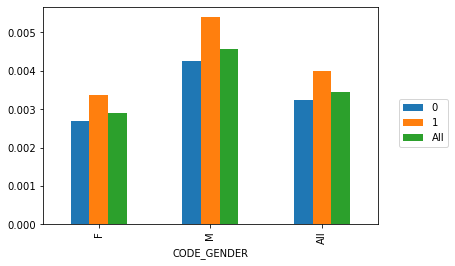

mean                     sum           count              
FLAG_PHONE           0         1       All   0   1  All      0      1    All
FLAG_OWN_CAR                                                                
N             0.003474  0.002212  0.003095  55  15   70  15834   6780  22614
Y             0.002835  0.007056  0.004045  28  28   56   9875   3968  13843
All           0.003228  0.004001  0.003456  83  43  126  25709  10748  36457

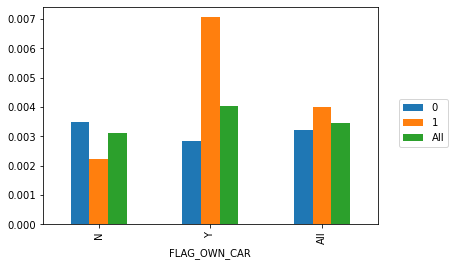

mean                     sum           count         \
FLAG_PHONE              0         1       All   0   1  All      0      1   
FLAG_OWN_REALTY                                                            
N                0.003288  0.004205  0.003598  26  17   43   7908   4043   
Y                0.003202  0.003878  0.003387  57  26   83  17801   6705   
All              0.003228  0.004001  0.003456  83  43  126  25709  10748   

                        
FLAG_PHONE         All  
FLAG_OWN_REALTY         
N                11951  
Y                24506  
All              36457

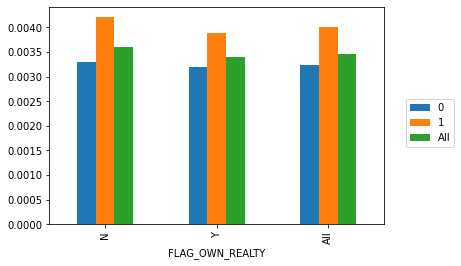

mean                       sum               count           \
FLAG_PHONE           0         1       All     0     1  All        0        1   
CNT_CHILDREN                                                                    
0             0.003687  0.003433  0.003611  65.0  26.0   91  17628.0   7573.0   
1             0.002775  0.006711  0.003871  15.0  14.0   29   5406.0   2086.0   
2             0.001310  0.003106  0.001843   3.0   3.0    6   2290.0    966.0   
3             0.000000  0.000000  0.000000   0.0   0.0    0    311.0    108.0   
4             0.000000  0.000000  0.000000   0.0   0.0    0     52.0     11.0   
5             0.000000  0.000000  0.000000   0.0   0.0    0     19.0      1.0   
7                  NaN  0.000000  0.000000   NaN   0.0    0      NaN      2.0   
14            0.000000       NaN  0.000000   0.0   NaN    0      3.0      NaN   
19                 NaN  0.000000  0.000000   NaN   0.0    0      NaN      1.0   
All           0.003228  0.004001  0.003456  83.0  43.0  126  25709.0  10748.0   

                     
FLAG_PHONE      All  
CNT_CHILDREN         
0             25201  
1              7492  
2              3256  
3               419  
4                63  
5                20  
7                 2  
14                3  
19                1  
All           36457

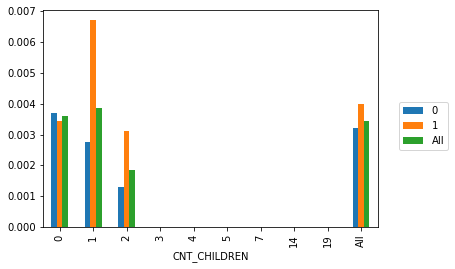

mean                       sum               count  \
FLAG_PHONE                   0         1       All     0     1  All        0   
NAME_INCOME_TYPE                                                               
Commercial associate  0.003337  0.008814  0.004947  20.0  22.0   42   5994.0   
Pensioner             0.004570  0.003941  0.004389  20.0   7.0   27   4376.0   
State servant         0.000940  0.001166  0.001005   2.0   1.0    3   2127.0   
Student               0.000000       NaN  0.000000   0.0   NaN    0     11.0   
Working               0.003106  0.002314  0.002869  41.0  13.0   54  13201.0   
All                   0.003228  0.004001  0.003456  83.0  43.0  126  25709.0   

                                      
FLAG_PHONE                  1    All  
NAME_INCOME_TYPE                      
Commercial associate   2496.0   8490  
Pensioner              1776.0   6152  
State servant           858.0   2985  
Student                   NaN     11  
Working                5618.0  18819  
All                   10748.0  36457

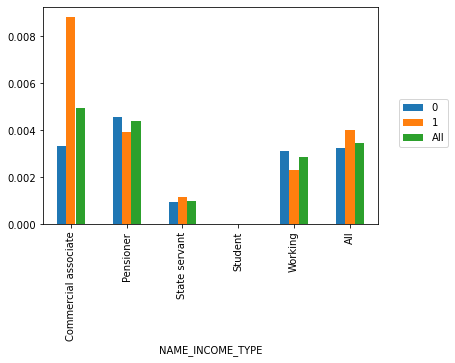

mean                     sum           \
FLAG_PHONE                            0         1       All   0   1  All   
NAME_EDUCATION_TYPE                                                        
Academic degree                0.000000  0.000000  0.000000   0   0    0   
Higher education               0.003885  0.006307  0.004663  26  20   46   
Incomplete higher              0.000000  0.003788  0.001418   0   2    2   
Lower secondary                0.003484  0.011494  0.005348   1   1    2   
Secondary / secondary special  0.003141  0.002878  0.003067  56  20   76   
All                            0.003228  0.004001  0.003456  83  43  126   

                               count                
FLAG_PHONE                         0      1    All  
NAME_EDUCATION_TYPE                                 
Academic degree                   20     12     32  
Higher education                6693   3171   9864  
Incomplete higher                882    528   1410  
Lower secondary                  287     87    374  
Secondary / secondary special  17827   6950  24777  
All                            25709  10748  36457

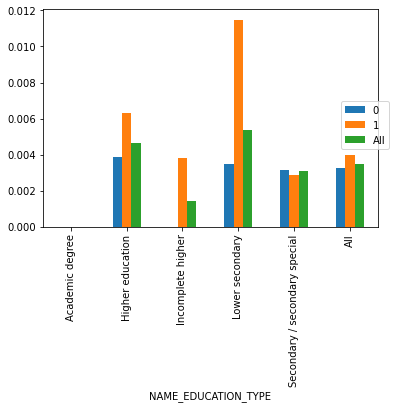

mean                     sum           count         \
FLAG_PHONE                   0         1       All   0   1  All      0      1   
NAME_FAMILY_STATUS                                                              
Civil marriage        0.000464  0.000000  0.000340   1   0    1   2155    790   
Married               0.003152  0.003948  0.003393  55  30   85  17449   7599   
Separated             0.003521  0.008785  0.005231   5   6   11   1420    683   
Single / not married  0.005244  0.004146  0.004970  19   5   24   3623   1206   
Widow                 0.002825  0.004255  0.003264   3   2    5   1062    470   
All                   0.003228  0.004001  0.003456  83  43  126  25709  10748   

                             
FLAG_PHONE              All  
NAME_FAMILY_STATUS           
Civil marriage         2945  
Married               25048  
Separated              2103  
Single / not married   4829  
Widow                  1532  
All                   36457

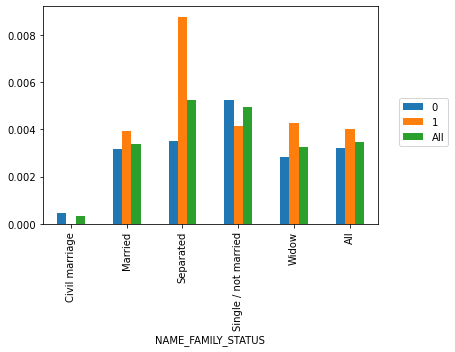

mean                     sum           count         \
FLAG_PHONE                  0         1       All   0   1  All      0      1   
NAME_HOUSING_TYPE                                                              
Co-op apartment      0.015152  0.000000  0.011905   2   0    2    132     36   
House / apartment    0.003022  0.004324  0.003410  69  42  111  22834   9714   
Municipal apartment  0.006361  0.002924  0.005319   5   1    6    786    342   
Office apartment     0.004831  0.000000  0.003817   1   0    1    207     55   
Rented apartment     0.004211  0.000000  0.003478   2   0    2    475    100   
With parents         0.003137  0.000000  0.002252   4   0    4   1275    501   
All                  0.003228  0.004001  0.003456  83  43  126  25709  10748   

                            
FLAG_PHONE             All  
NAME_HOUSING_TYPE           
Co-op apartment        168  
House / apartment    32548  
Municipal apartment   1128  
Office apartment       262  
Rented apartment       575  
With parents          1776  
All                  36457

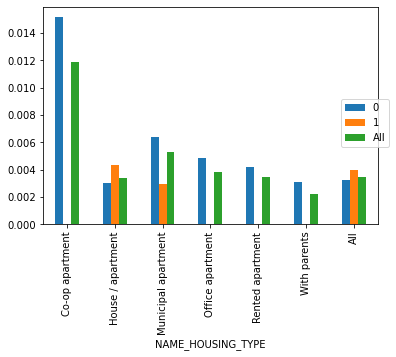

mean                     sum           count         \
FLAG_PHONE              0         1       All   0   1  All      0      1   
FLAG_WORK_PHONE                                                            
0                0.003443  0.003734  0.003506  76  23   99  22076   6159   
1                0.001927  0.004358  0.003284   7  20   27   3633   4589   
All              0.003228  0.004001  0.003456  83  43  126  25709  10748   

                        
FLAG_PHONE         All  
FLAG_WORK_PHONE         
0                28235  
1                 8222  
All              36457

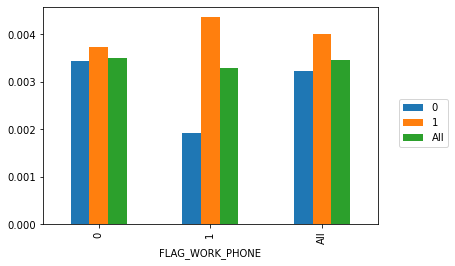

mean                     sum           count              
FLAG_PHONE         0         1       All   0   1  All      0      1    All
FLAG_EMAIL                                                                
0           0.003241  0.003596  0.003345  76  35  111  23452   9734  33186
1           0.003101  0.007890  0.004586   7   8   15   2257   1014   3271
All         0.003228  0.004001  0.003456  83  43  126  25709  10748  36457

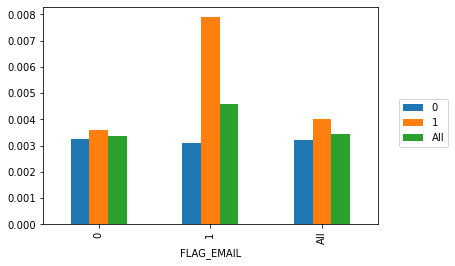

mean                     sum          count        \
FLAG_PHONE                    0         1       All   0   1 All      0     1   
OCCUPATION_TYPE                                                                
Accountants            0.002516  0.000000  0.001612   2   0   2    795   446   
Cleaning staff         0.002439  0.000000  0.001815   1   0   1    410   141   
Cooking staff          0.004107  0.011905  0.006107   2   2   4    487   168   
Core staff             0.003623  0.008130  0.005013   9   9  18   2484  1107   
Drivers                0.001321  0.004808  0.002339   2   3   5   1514   624   
HR staff               0.000000  0.000000  0.000000   0   0   0     70    15   
High skill tech staff  0.004540  0.003984  0.004338   4   2   6    881   502   
IT staff               0.068182  0.000000  0.050000   3   0   3     44    16   
Laborers               0.003495  0.003062  0.003381  16   5  21   4578  1633   
Low-skill Laborers     0.000000  0.036364  0.011429   0   2   2    120    55   
Managers               0.004735  0.004444  0.004648  10   4  14   2112   900   
Medicine staff         0.001136  0.009174  0.003314   1   3   4    880   327   
Private service staff  0.000000  0.000000  0.000000   0   0   0    225   119   
Realty agents          0.000000  0.000000  0.000000   0   0   0     52    27   
Sales staff            0.001652  0.000940  0.001435   4   1   5   2421  1064   
Secretaries            0.000000  0.000000  0.000000   0   0   0    103    48   
Security staff         0.012739  0.000000  0.010135   6   0   6    471   121   
Waiters/barmen staff   0.007812  0.000000  0.005747   1   0   1    128    46   
All                    0.003432  0.004213  0.003660  61  31  92  17775  7359   

                              
FLAG_PHONE               All  
OCCUPATION_TYPE               
Accountants             1241  
Cleaning staff           551  
Cooking staff            655  
Core staff              3591  
Drivers                 2138  
HR staff                  85  
High skill tech staff   1383  
IT staff                  60  
Laborers                6211  
Low-skill Laborers       175  
Managers                3012  
Medicine staff          1207  
Private service staff    344  
Realty agents             79  
Sales staff             3485  
Secretaries              151  
Security staff           592  
Waiters/barmen staff     174  
All                    25134

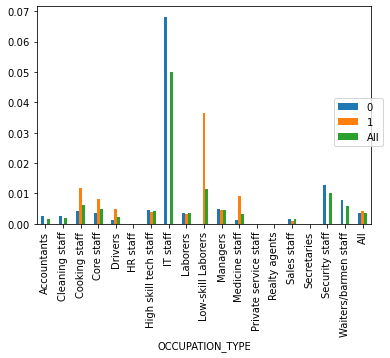

mean                       sum               count  \
FLAG_PHONE              0         1       All     0     1  All        0   
CNT_FAM_MEMBERS                                                           
1.0              0.003395  0.004548  0.003721  17.0   9.0   26   5008.0   
2.0              0.003910  0.003217  0.003699  53.0  19.0   72  13556.0   
3.0              0.002174  0.006590  0.003426  10.0  12.0   22   4600.0   
4.0              0.001376  0.003243  0.001932   3.0   3.0    6   2181.0   
5.0              0.000000  0.000000  0.000000   0.0   0.0    0    290.0   
6.0              0.000000  0.000000  0.000000   0.0   0.0    0     52.0   
7.0              0.000000       NaN  0.000000   0.0   NaN    0     19.0   
9.0                   NaN  0.000000  0.000000   NaN   0.0    0      NaN   
15.0             0.000000       NaN  0.000000   0.0   NaN    0      3.0   
20.0                  NaN  0.000000  0.000000   NaN   0.0    0      NaN   
All              0.003228  0.004001  0.003456  83.0  43.0  126  25709.0   

                                 
FLAG_PHONE             1    All  
CNT_FAM_MEMBERS                  
1.0               1979.0   6987  
2.0               5907.0  19463  
3.0               1821.0   6421  
4.0                925.0   3106  
5.0                107.0    397  
6.0                  6.0     58  
7.0                  NaN     19  
9.0                  2.0      2  
15.0                 NaN      3  
20.0                 1.0      1  
All              10748.0  36457

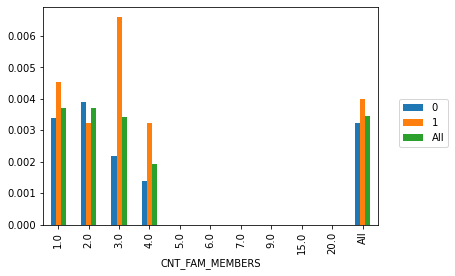

In [34]:
### 6. Table & chart comparison of late ratio vs feature pairs (FLAG PHONE vs ALL)

import matplotlib.pyplot as plt

L1_features=['FLAG_PHONE', 'FLAG_EMAIL', 'OCCUPATION_TYPE', 'CNT_FAM_MEMBERS']
L2_features=['CODE_GENDER','FLAG_OWN_CAR','FLAG_OWN_REALTY', 'CNT_CHILDREN', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',  'NAME_FAMILY_STATUS',
'NAME_HOUSING_TYPE', 'FLAG_WORK_PHONE', 'FLAG_EMAIL', 'OCCUPATION_TYPE', 'CNT_FAM_MEMBERS']
L2_featuers_disc= ['AMT_INCOME_TOTAL','DAYS_BIRTH', 'DAYS_EMPLOYED']
features_excl=['FLAG_PHONE','FLAG_MOBIL']

for el in L2_features:
    display(pd.pivot_table(app_and_credit_label_2,index=el,columns='FLAG_PHONE',values='all_late_flag',aggfunc=['mean','sum','count'],margins=True))
    temp_table=pd.pivot_table(app_and_credit_label_2,index=el,columns='FLAG_PHONE',values='all_late_flag',aggfunc='mean',margins=True)
    temp_table.plot(kind='bar')
    plt.legend(bbox_to_anchor = (1.05, 0.6))
    plt.show()


mean                      sum           count             
FLAG_EMAIL          0         1       All    0   1  All      0     1    All
CODE_GENDER                                                                
F            0.002880  0.003170  0.002906   64   7   71  22222  2208  24430
M            0.004287  0.007526  0.004573   47   8   55  10964  1063  12027
All          0.003345  0.004586  0.003456  111  15  126  33186  3271  36457

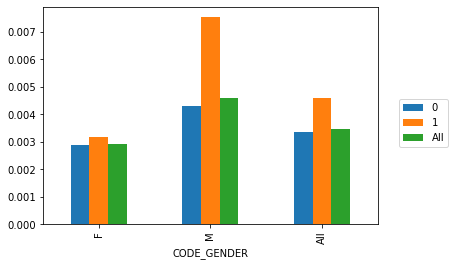

mean                      sum           count             
FLAG_EMAIL           0         1       All    0   1  All      0     1    All
FLAG_OWN_CAR                                                                
N             0.002948  0.004690  0.003095   61   9   70  20695  1919  22614
Y             0.004003  0.004438  0.004045   50   6   56  12491  1352  13843
All           0.003345  0.004586  0.003456  111  15  126  33186  3271  36457

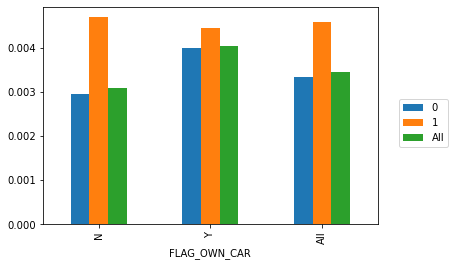

mean                      sum           count        \
FLAG_EMAIL              0         1       All    0   1  All      0     1   
FLAG_OWN_REALTY                                                            
N                0.003503  0.004896  0.003598   39   4   43  11134   817   
Y                0.003265  0.004482  0.003387   72  11   83  22052  2454   
All              0.003345  0.004586  0.003456  111  15  126  33186  3271   

                        
FLAG_EMAIL         All  
FLAG_OWN_REALTY         
N                11951  
Y                24506  
All              36457

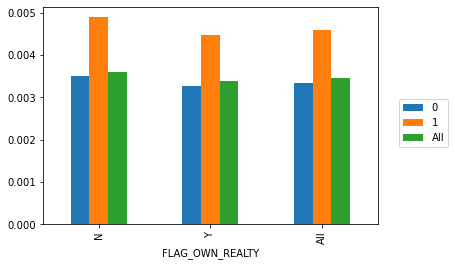

mean                        sum               count          \
FLAG_EMAIL           0         1       All      0     1  All        0       1   
CNT_CHILDREN                                                                    
0             0.003594  0.003799  0.003611   83.0   8.0   91  23095.0  2106.0   
1             0.003308  0.008314  0.003871   22.0   7.0   29   6650.0   842.0   
2             0.002017  0.000000  0.001843    6.0   0.0    6   2975.0   281.0   
3             0.000000  0.000000  0.000000    0.0   0.0    0    378.0    41.0   
4             0.000000  0.000000  0.000000    0.0   0.0    0     62.0     1.0   
5             0.000000       NaN  0.000000    0.0   NaN    0     20.0     NaN   
7             0.000000       NaN  0.000000    0.0   NaN    0      2.0     NaN   
14            0.000000       NaN  0.000000    0.0   NaN    0      3.0     NaN   
19            0.000000       NaN  0.000000    0.0   NaN    0      1.0     NaN   
All           0.003345  0.004586  0.003456  111.0  15.0  126  33186.0  3271.0   

                     
FLAG_EMAIL      All  
CNT_CHILDREN         
0             25201  
1              7492  
2              3256  
3               419  
4                63  
5                20  
7                 2  
14                3  
19                1  
All           36457

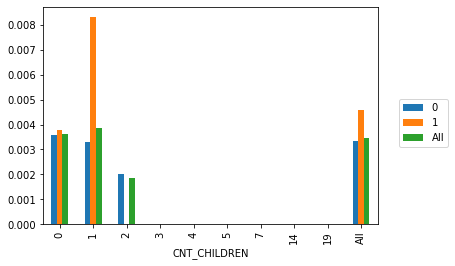

mean                      sum           count        \
FLAG_EMAIL                   0         1       All    0   1  All      0     1   
NAME_INCOME_TYPE                                                                
Commercial associate  0.005131  0.003690  0.004947   38   4   42   7406  1084   
Pensioner             0.003707  0.022936  0.004389   22   5   27   5934   218   
State servant         0.001116  0.000000  0.001005    3   0    3   2688   297   
Student               0.000000  0.000000  0.000000    0   0    0      2     9   
Working               0.002798  0.003608  0.002869   48   6   54  17156  1663   
All                   0.003345  0.004586  0.003456  111  15  126  33186  3271   

                             
FLAG_EMAIL              All  
NAME_INCOME_TYPE             
Commercial associate   8490  
Pensioner              6152  
State servant          2985  
Student                  11  
Working               18819  
All                   36457

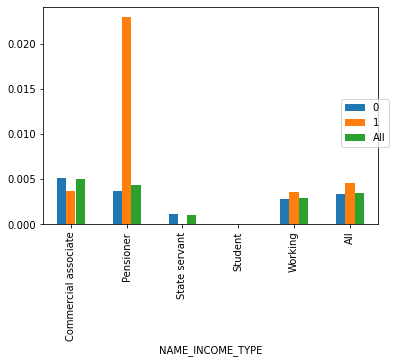

mean                        sum             \
FLAG_EMAIL                            0         1       All      0     1  All   
NAME_EDUCATION_TYPE                                                             
Academic degree                0.000000       NaN  0.000000    0.0   NaN    0   
Higher education               0.004452  0.006024  0.004663   38.0   8.0   46   
Incomplete higher              0.001600  0.000000  0.001418    2.0   0.0    2   
Lower secondary                0.005731  0.000000  0.005348    2.0   0.0    2   
Secondary / secondary special  0.002998  0.003982  0.003067   69.0   7.0   76   
All                            0.003345  0.004586  0.003456  111.0  15.0  126   

                                 count                 
FLAG_EMAIL                           0       1    All  
NAME_EDUCATION_TYPE                                    
Academic degree                   32.0     NaN     32  
Higher education                8536.0  1328.0   9864  
Incomplete higher               1250.0   160.0   1410  
Lower secondary                  349.0    25.0    374  
Secondary / secondary special  23019.0  1758.0  24777  
All                            33186.0  3271.0  36457

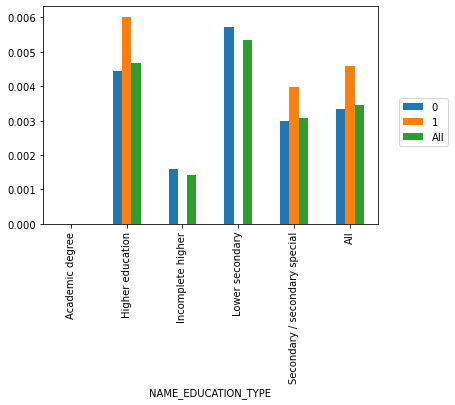

mean                      sum           count        \
FLAG_EMAIL                   0         1       All    0   1  All      0     1   
NAME_FAMILY_STATUS                                                              
Civil marriage        0.000381  0.000000  0.000340    1   0    1   2624   321   
Married               0.003109  0.006341  0.003393   71  14   85  22840  2208   
Separated             0.005670  0.000000  0.005231   11   0   11   1940   163   
Single / not married  0.005293  0.002066  0.004970   23   1   24   4345   484   
Widow                 0.003479  0.000000  0.003264    5   0    5   1437    95   
All                   0.003345  0.004586  0.003456  111  15  126  33186  3271   

                             
FLAG_EMAIL              All  
NAME_FAMILY_STATUS           
Civil marriage         2945  
Married               25048  
Separated              2103  
Single / not married   4829  
Widow                  1532  
All                   36457

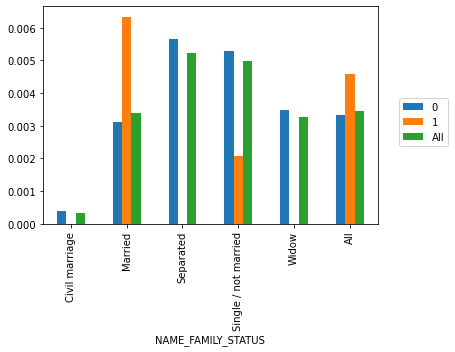

mean                      sum           count        \
FLAG_EMAIL                  0         1       All    0   1  All      0     1   
NAME_HOUSING_TYPE                                                              
Co-op apartment      0.011976  0.000000  0.011905    2   0    2    167     1   
House / apartment    0.003273  0.004809  0.003410   97  14  111  29637  2911   
Municipal apartment  0.005803  0.000000  0.005319    6   0    6   1034    94   
Office apartment     0.004000  0.000000  0.003817    1   0    1    250    12   
Rented apartment     0.004008  0.000000  0.003478    2   0    2    499    76   
With parents         0.001876  0.005650  0.002252    3   1    4   1599   177   
All                  0.003345  0.004586  0.003456  111  15  126  33186  3271   

                            
FLAG_EMAIL             All  
NAME_HOUSING_TYPE           
Co-op apartment        168  
House / apartment    32548  
Municipal apartment   1128  
Office apartment       262  
Rented apartment       575  
With parents          1776  
All                  36457

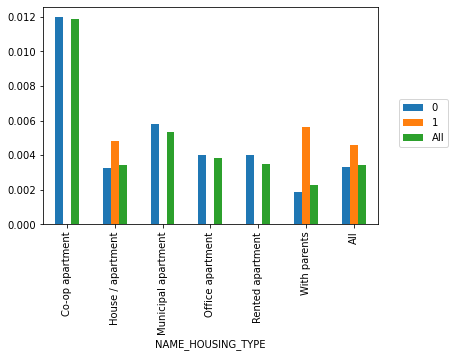

mean                      sum           count        \
FLAG_EMAIL              0         1       All    0   1  All      0     1   
FLAG_WORK_PHONE                                                            
0                0.003288  0.005587  0.003506   84  15   99  25550  2685   
1                0.003536  0.000000  0.003284   27   0   27   7636   586   
All              0.003345  0.004586  0.003456  111  15  126  33186  3271   

                        
FLAG_EMAIL         All  
FLAG_WORK_PHONE         
0                28235  
1                 8222  
All              36457

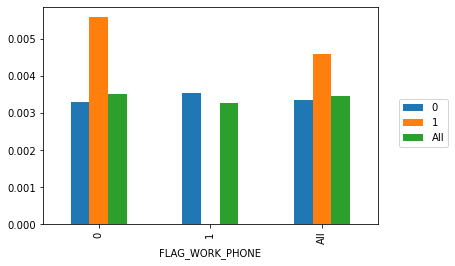

mean                      sum           count             
FLAG_EMAIL         0         1       All    0   1  All      0     1    All
FLAG_PHONE                                                                
0           0.003241  0.003101  0.003228   76   7   83  23452  2257  25709
1           0.003596  0.007890  0.004001   35   8   43   9734  1014  10748
All         0.003345  0.004586  0.003456  111  15  126  33186  3271  36457

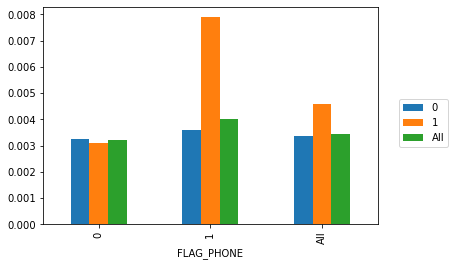

mean                     sum          count        \
FLAG_EMAIL                    0         1       All   0   1 All      0     1   
OCCUPATION_TYPE                                                                
Accountants            0.001852  0.000000  0.001612   2   0   2   1080   161   
Cleaning staff         0.001905  0.000000  0.001815   1   0   1    525    26   
Cooking staff          0.006568  0.000000  0.006107   4   0   4    609    46   
Core staff             0.004200  0.010081  0.005013  13   5  18   3095   496   
Drivers                0.002546  0.000000  0.002339   5   0   5   1964   174   
HR staff               0.000000  0.000000  0.000000   0   0   0     71    14   
High skill tech staff  0.004946  0.000000  0.004338   6   0   6   1213   170   
IT staff               0.000000  0.157895  0.050000   0   3   3     41    19   
Laborers               0.003475  0.002198  0.003381  20   1  21   5756   455   
Low-skill Laborers     0.011976  0.000000  0.011429   2   0   2    167     8   
Managers               0.005285  0.000000  0.004648  14   0  14   2649   363   
Medicine staff         0.001854  0.015625  0.003314   2   2   4   1079   128   
Private service staff  0.000000  0.000000  0.000000   0   0   0    295    49   
Realty agents          0.000000  0.000000  0.000000   0   0   0     70     9   
Sales staff            0.001580  0.000000  0.001435   5   0   5   3165   320   
Secretaries            0.000000  0.000000  0.000000   0   0   0    134    17   
Security staff         0.011342  0.000000  0.010135   6   0   6    529    63   
Waiters/barmen staff   0.000000  0.083333  0.005747   0   1   1    162    12   
All                    0.003539  0.004743  0.003660  80  12  92  22604  2530   

                              
FLAG_EMAIL               All  
OCCUPATION_TYPE               
Accountants             1241  
Cleaning staff           551  
Cooking staff            655  
Core staff              3591  
Drivers                 2138  
HR staff                  85  
High skill tech staff   1383  
IT staff                  60  
Laborers                6211  
Low-skill Laborers       175  
Managers                3012  
Medicine staff          1207  
Private service staff    344  
Realty agents             79  
Sales staff             3485  
Secretaries              151  
Security staff           592  
Waiters/barmen staff     174  
All                    25134

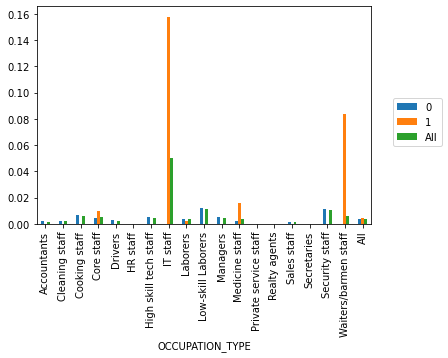

mean                        sum               count  \
FLAG_EMAIL              0         1       All      0     1  All        0   
CNT_FAM_MEMBERS                                                            
1.0              0.003918  0.001650  0.003721   25.0   1.0   26   6381.0   
2.0              0.003588  0.004926  0.003699   64.0   8.0   72  17839.0   
3.0              0.002812  0.008208  0.003426   16.0   6.0   22   5690.0   
4.0              0.002114  0.000000  0.001932    6.0   0.0    6   2838.0   
5.0              0.000000  0.000000  0.000000    0.0   0.0    0    356.0   
6.0              0.000000  0.000000  0.000000    0.0   0.0    0     57.0   
7.0              0.000000       NaN  0.000000    0.0   NaN    0     19.0   
9.0              0.000000       NaN  0.000000    0.0   NaN    0      2.0   
15.0             0.000000       NaN  0.000000    0.0   NaN    0      3.0   
20.0             0.000000       NaN  0.000000    0.0   NaN    0      1.0   
All              0.003345  0.004586  0.003456  111.0  15.0  126  33186.0   

                                
FLAG_EMAIL            1    All  
CNT_FAM_MEMBERS                 
1.0               606.0   6987  
2.0              1624.0  19463  
3.0               731.0   6421  
4.0               268.0   3106  
5.0                41.0    397  
6.0                 1.0     58  
7.0                 NaN     19  
9.0                 NaN      2  
15.0                NaN      3  
20.0                NaN      1  
All              3271.0  36457

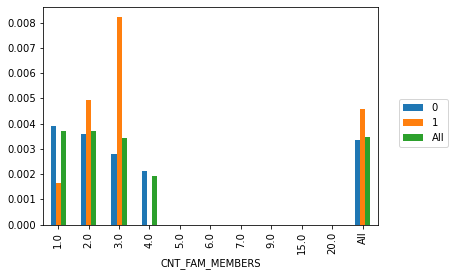

In [35]:
### 7. Table & chart comparison of late ratio vs feature pairs (FLAG_EMAIL vs ALL)

import matplotlib.pyplot as plt

L1_features=['FLAG_PHONE', 'FLAG_EMAIL', 'OCCUPATION_TYPE', 'CNT_FAM_MEMBERS']
L2_features=['CODE_GENDER','FLAG_OWN_CAR','FLAG_OWN_REALTY', 'CNT_CHILDREN', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',  'NAME_FAMILY_STATUS',
'NAME_HOUSING_TYPE', 'FLAG_WORK_PHONE', 'FLAG_PHONE', 'OCCUPATION_TYPE', 'CNT_FAM_MEMBERS']
L2_featuers_disc= ['AMT_INCOME_TOTAL','DAYS_BIRTH', 'DAYS_EMPLOYED']
features_excl=['FLAG_EMAIL','FLAG_PHONE','FLAG_MOBIL']

for el in L2_features:
    display(pd.pivot_table(app_and_credit_label_2,index=el,columns='FLAG_EMAIL',values='all_late_flag',aggfunc=['mean','sum','count'],margins=True))
    temp_table=pd.pivot_table(app_and_credit_label_2,index=el,columns='FLAG_EMAIL',values='all_late_flag',aggfunc='mean',margins=True)
    temp_table.plot(kind='bar')
    plt.legend(bbox_to_anchor = (1.05, 0.6))    
    plt.show()

mean                     sum          count        \
CODE_GENDER                   F         M       All   F   M All      F     M   
OCCUPATION_TYPE                                                                
Accountants            0.001663  0.000000  0.001612   2   0   2   1203    38   
Cleaning staff         0.001883  0.000000  0.001815   1   0   1    531    20   
Cooking staff          0.005245  0.012048  0.006107   3   1   4    572    83   
Core staff             0.003481  0.011142  0.005013  10   8  18   2873   718   
Drivers                0.000000  0.002495  0.002339   0   5   5    134  2004   
HR staff               0.000000  0.000000  0.000000   0   0   0     78     7   
High skill tech staff  0.004167  0.004728  0.004338   4   2   6    960   423   
IT staff               0.111111  0.000000  0.050000   3   0   3     27    33   
Laborers               0.001531  0.004724  0.003381   4  17  21   2612  3599   
Low-skill Laborers     0.054054  0.000000  0.011429   2   0   2     37   138   
Managers               0.003169  0.006276  0.004648   5   9  14   1578  1434   
Medicine staff         0.003439  0.000000  0.003314   4   0   4   1163    44   
Private service staff  0.000000  0.000000  0.000000   0   0   0    320    24   
Realty agents          0.000000  0.000000  0.000000   0   0   0     69    10   
Sales staff            0.001662  0.000000  0.001435   5   0   5   3008   477   
Secretaries            0.000000  0.000000  0.000000   0   0   0    146     5   
Security staff         0.005747  0.011962  0.010135   1   5   6    174   418   
Waiters/barmen staff   0.006897  0.000000  0.005747   1   0   1    145    29   
All                    0.002879  0.004945  0.003660  45  47  92  15630  9504   

                              
CODE_GENDER              All  
OCCUPATION_TYPE               
Accountants             1241  
Cleaning staff           551  
Cooking staff            655  
Core staff              3591  
Drivers                 2138  
HR staff                  85  
High skill tech staff   1383  
IT staff                  60  
Laborers                6211  
Low-skill Laborers       175  
Managers                3012  
Medicine staff          1207  
Private service staff    344  
Realty agents             79  
Sales staff             3485  
Secretaries              151  
Security staff           592  
Waiters/barmen staff     174  
All                    25134

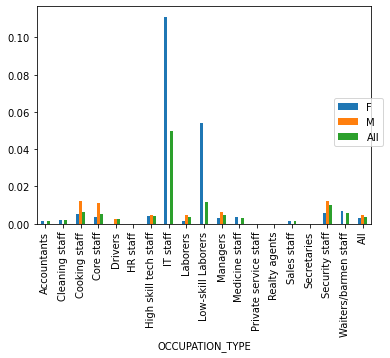

mean                     sum          count         \
FLAG_OWN_CAR                  N         Y       All   N   Y All      N      Y   
OCCUPATION_TYPE                                                                 
Accountants            0.001377  0.001942  0.001612   1   1   2    726    515   
Cleaning staff         0.002066  0.000000  0.001815   1   0   1    484     67   
Cooking staff          0.003945  0.013514  0.006107   2   2   4    507    148   
Core staff             0.004861  0.005271  0.005013  11   7  18   2263   1328   
Drivers                0.000000  0.003143  0.002339   0   5   5    547   1591   
HR staff               0.000000  0.000000  0.000000   0   0   0     53     32   
High skill tech staff  0.006345  0.001681  0.004338   5   1   6    788    595   
IT staff               0.090909  0.000000  0.050000   3   0   3     33     27   
Laborers               0.001928  0.005426  0.003381   7  14  21   3631   2580   
Low-skill Laborers     0.014925  0.000000  0.011429   2   0   2    134     41   
Managers               0.003846  0.005257  0.004648   5   9  14   1300   1712   
Medicine staff         0.003421  0.003030  0.003314   3   1   4    877    330   
Private service staff  0.000000  0.000000  0.000000   0   0   0    237    107   
Realty agents          0.000000  0.000000  0.000000   0   0   0     53     26   
Sales staff            0.000859  0.002591  0.001435   2   3   5   2327   1158   
Secretaries            0.000000  0.000000  0.000000   0   0   0    124     27   
Security staff         0.012953  0.004854  0.010135   5   1   6    386    206   
Waiters/barmen staff   0.006757  0.000000  0.005747   1   0   1    148     26   
All                    0.003284  0.004184  0.003660  48  44  92  14618  10516   

                              
FLAG_OWN_CAR             All  
OCCUPATION_TYPE               
Accountants             1241  
Cleaning staff           551  
Cooking staff            655  
Core staff              3591  
Drivers                 2138  
HR staff                  85  
High skill tech staff   1383  
IT staff                  60  
Laborers                6211  
Low-skill Laborers       175  
Managers                3012  
Medicine staff          1207  
Private service staff    344  
Realty agents             79  
Sales staff             3485  
Secretaries              151  
Security staff           592  
Waiters/barmen staff     174  
All                    25134

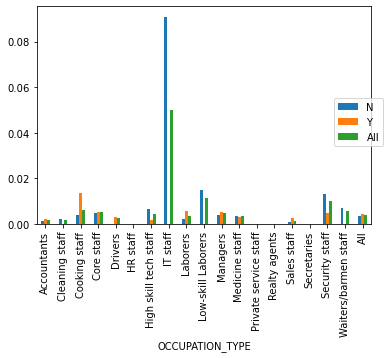

mean                     sum         count         \
FLAG_OWN_REALTY               N         Y       All   N   Y All     N      Y   
OCCUPATION_TYPE                                                                
Accountants            0.000000  0.002535  0.001612   0   2   2   452    789   
Cleaning staff         0.000000  0.002469  0.001815   0   1   1   146    405   
Cooking staff          0.000000  0.009324  0.006107   0   4   4   226    429   
Core staff             0.004890  0.005076  0.005013   6  12  18  1227   2364   
Drivers                0.002448  0.002271  0.002339   2   3   5   817   1321   
HR staff               0.000000  0.000000  0.000000   0   0   0    49     36   
High skill tech staff  0.004386  0.004315  0.004338   2   4   6   456    927   
IT staff               0.000000  0.090909  0.050000   0   3   3    27     33   
Laborers               0.005007  0.002491  0.003381  11  10  21  2197   4014   
Low-skill Laborers     0.000000  0.017544  0.011429   0   2   2    61    114   
Managers               0.002053  0.005888  0.004648   2  12  14   974   2038   
Medicine staff         0.002364  0.003827  0.003314   1   3   4   423    784   
Private service staff  0.000000  0.000000  0.000000   0   0   0    90    254   
Realty agents          0.000000  0.000000  0.000000   0   0   0    18     61   
Sales staff            0.001661  0.001315  0.001435   2   3   5  1204   2281   
Secretaries            0.000000  0.000000  0.000000   0   0   0    55     96   
Security staff         0.009804  0.010309  0.010135   2   4   6   204    388   
Waiters/barmen staff   0.000000  0.007874  0.005747   0   1   1    47    127   
All                    0.003228  0.003888  0.003660  28  64  92  8673  16461   

                              
FLAG_OWN_REALTY          All  
OCCUPATION_TYPE               
Accountants             1241  
Cleaning staff           551  
Cooking staff            655  
Core staff              3591  
Drivers                 2138  
HR staff                  85  
High skill tech staff   1383  
IT staff                  60  
Laborers                6211  
Low-skill Laborers       175  
Managers                3012  
Medicine staff          1207  
Private service staff    344  
Realty agents             79  
Sales staff             3485  
Secretaries              151  
Security staff           592  
Waiters/barmen staff     174  
All                    25134

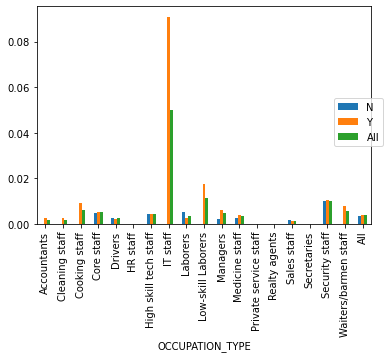

mean                                               \
CNT_CHILDREN                  0         1         2    3    4    5    7   14   
OCCUPATION_TYPE                                                                
Accountants            0.001252  0.003012  0.000000  0.0  0.0  NaN  NaN  NaN   
Cleaning staff         0.002463  0.000000  0.000000  0.0  NaN  NaN  0.0  NaN   
Cooking staff          0.008696  0.000000  0.000000  0.0  NaN  NaN  NaN  NaN   
Core staff             0.005233  0.007392  0.000000  0.0  0.0  NaN  NaN  NaN   
Drivers                0.002257  0.003683  0.000000  0.0  NaN  NaN  NaN  0.0   
HR staff               0.000000  0.000000  0.000000  NaN  NaN  NaN  NaN  NaN   
High skill tech staff  0.005721  0.000000  0.005236  0.0  0.0  NaN  NaN  NaN   
IT staff               0.069767  0.000000  0.000000  NaN  NaN  NaN  NaN  NaN   
Laborers               0.003422  0.004573  0.001416  0.0  0.0  0.0  NaN  NaN   
Low-skill Laborers     0.000000  0.054054  0.000000  NaN  NaN  NaN  NaN  NaN   
Managers               0.004452  0.004700  0.006250  0.0  0.0  0.0  NaN  NaN   
Medicine staff         0.004756  0.000000  0.000000  0.0  0.0  NaN  NaN  NaN   
Private service staff  0.000000  0.000000  0.000000  NaN  NaN  NaN  NaN  NaN   
Realty agents          0.000000  0.000000  0.000000  NaN  NaN  NaN  NaN  NaN   
Sales staff            0.000951  0.002043  0.002793  0.0  0.0  NaN  NaN  NaN   
Secretaries            0.000000  0.000000  0.000000  NaN  NaN  NaN  NaN  NaN   
Security staff         0.011442  0.010870  0.000000  NaN  0.0  NaN  NaN  NaN   
Waiters/barmen staff   0.000000  0.016949  0.000000  0.0  NaN  NaN  NaN  NaN   
All                    0.003835  0.004250  0.001842  0.0  0.0  0.0  0.0  0.0   

                                       sum                                 \
CNT_CHILDREN            19       All     0     1    2    3    4    5    7   
OCCUPATION_TYPE                                                             
Accountants            NaN  0.001612   1.0   1.0  0.0  0.0  0.0  NaN  NaN   
Cleaning staff         NaN  0.001815   1.0   0.0  0.0  0.0  NaN  NaN  0.0   
Cooking staff          NaN  0.006107   4.0   0.0  0.0  0.0  NaN  NaN  NaN   
Core staff             NaN  0.005013  11.0   7.0  0.0  0.0  0.0  NaN  NaN   
Drivers                NaN  0.002339   3.0   2.0  0.0  0.0  NaN  NaN  NaN   
HR staff               NaN  0.000000   0.0   0.0  0.0  NaN  NaN  NaN  NaN   
High skill tech staff  NaN  0.004338   5.0   0.0  1.0  0.0  0.0  NaN  NaN   
IT staff               NaN  0.050000   3.0   0.0  0.0  NaN  NaN  NaN  NaN   
Laborers               NaN  0.003381  14.0   6.0  1.0  0.0  0.0  0.0  NaN   
Low-skill Laborers     NaN  0.011429   0.0   2.0  0.0  NaN  NaN  NaN  NaN   
Managers               NaN  0.004648   8.0   4.0  2.0  0.0  0.0  0.0  NaN   
Medicine staff         NaN  0.003314   4.0   0.0  0.0  0.0  0.0  NaN  NaN   
Private service staff  NaN  0.000000   0.0   0.0  0.0  NaN  NaN  NaN  NaN   
Realty agents          NaN  0.000000   0.0   0.0  0.0  NaN  NaN  NaN  NaN   
Sales staff            NaN  0.001435   2.0   2.0  1.0  0.0  0.0  NaN  NaN   
Secretaries            NaN  0.000000   0.0   0.0  0.0  NaN  NaN  NaN  NaN   
Security staff         NaN  0.010135   5.0   1.0  0.0  NaN  0.0  NaN  NaN   
Waiters/barmen staff   0.0  0.005747   0.0   1.0  0.0  0.0  NaN  NaN  NaN   
All                    0.0  0.003660  61.0  26.0  5.0  0.0  0.0  0.0  0.0   

                                       count                               \
CNT_CHILDREN            14   19 All        0       1       2      3     4   
OCCUPATION_TYPE                                                             
Accountants            NaN  NaN   2    799.0   332.0    89.0   20.0   1.0   
Cleaning staff         NaN  NaN   1    406.0    93.0    45.0    5.0   NaN   
Cooking staff          NaN  NaN   4    460.0   144.0    48.0    3.0   NaN   
Core staff             NaN  NaN  18   2102.0   947.0   451.0   64.0  27.0   
Drivers                0.0  NaN 

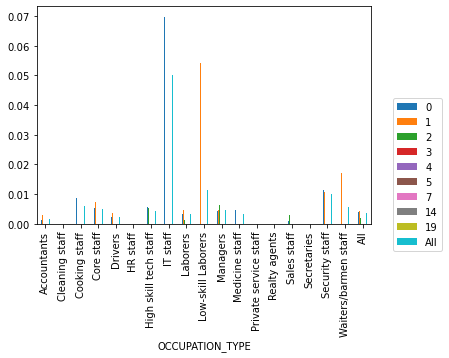

mean                                  \
NAME_INCOME_TYPE      Commercial associate Pensioner State servant Student   
OCCUPATION_TYPE                                                              
Accountants                       0.004090  0.000000      0.000000     NaN   
Cleaning staff                    0.000000       NaN      0.000000     NaN   
Cooking staff                     0.008000       NaN      0.000000     NaN   
Core staff                        0.004938  0.600000      0.001111     0.0   
Drivers                           0.001792  0.000000      0.008403     NaN   
HR staff                          0.000000       NaN      0.000000     NaN   
High skill tech staff             0.004963       NaN      0.000000     NaN   
IT staff                          0.000000       NaN      0.000000     NaN   
Laborers                          0.002738  0.000000      0.000000     0.0   
Low-skill Laborers                0.022222  1.000000      0.000000     NaN   
Managers                          0.006832  0.000000      0.000000     NaN   
Medicine staff                    0.017647  1.000000      0.000000     NaN   
Private service staff             0.000000       NaN      0.000000     NaN   
Realty agents                     0.000000       NaN           NaN     NaN   
Sales staff                       0.001678       NaN      0.000000     NaN   
Secretaries                       0.000000       NaN      0.000000     NaN   
Security staff                    0.020725       NaN      0.000000     NaN   
Waiters/barmen staff              0.020408       NaN      0.000000     NaN   
All                               0.004680  0.384615      0.000821     0.0   

                                                           sum            \
NAME_INCOME_TYPE        Working       All Commercial associate Pensioner   
OCCUPATION_TYPE                                                            
Accountants            0.000000  0.001612                  2.0       0.0   
Cleaning staff         0.002353  0.001815                  0.0       NaN   
Cooking staff          0.006424  0.006107                  1.0       NaN   
Core staff             0.005353  0.005013                  4.0       3.0   
Drivers                0.002055  0.002339                  1.0       0.0   
HR staff               0.000000  0.000000                  0.0       NaN   
High skill tech staff  0.005128  0.004338                  2.0       NaN   
IT staff               0.107143  0.050000                  0.0       NaN   
Laborers               0.003734  0.003381                  4.0       0.0   
Low-skill Laborers     0.000000  0.011429                  1.0       1.0   
Managers               0.003906  0.004648                  8.0       0.0   
Medicine staff         0.000000  0.003314                  3.0       1.0   
Private service staff  0.000000  0.000000                  0.0       NaN   
Realty agents          0.000000  0.000000                  0.0       NaN   
Sales staff            0.001315  0.001435                  2.0       NaN   
Secretaries            0.000000  0.000000                  0.0       NaN   
Security staff         0.005291  0.010135                  4.0       NaN   
Waiters/barmen staff   0.000000  0.005747                  1.0       NaN   
All                    0.003329  0.003660                 33.0       5.0   

                                                                       count  \
NAME_INCOME_TYPE      State servant Student Working All Commercial associate   
OCCUPATION_TYPE                                                                
Accountants                     0.0     NaN     0.0   2                489.0   
Cleaning staff                  0.0     NaN     1.0   1                107.0   
Cooking staff                   0.0     NaN     3.0   4                125.0   
Core staff                      1.0     0.0    10.0  18                810.0   
Drivers                         1.0     NaN     3.0   5                558.0   
HR staff

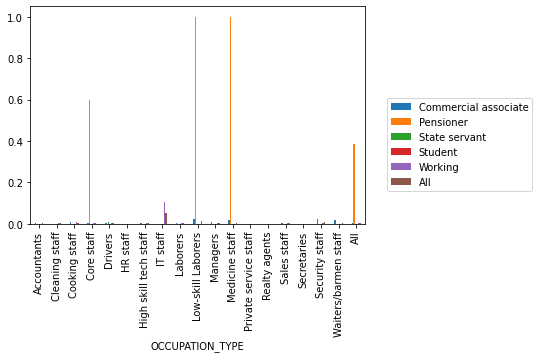

mean                                     \
NAME_EDUCATION_TYPE   Academic degree Higher education Incomplete higher   
OCCUPATION_TYPE                                                            
Accountants                       NaN         0.001372          0.000000   
Cleaning staff                    NaN         0.000000          0.000000   
Cooking staff                     NaN         0.000000          0.000000   
Core staff                        NaN         0.003652          0.004762   
Drivers                           NaN         0.003333          0.000000   
HR staff                          NaN         0.000000               NaN   
High skill tech staff             NaN         0.000000          0.027027   
IT staff                          NaN         0.000000          0.000000   
Laborers                          NaN         0.003375          0.000000   
Low-skill Laborers                NaN         0.000000          0.000000   
Managers                          0.0         0.005303          0.000000   
Medicine staff                    NaN         0.012500          0.000000   
Private service staff             NaN         0.000000          0.000000   
Realty agents                     NaN         0.000000          0.000000   
Sales staff                       0.0         0.003861          0.000000   
Secretaries                       NaN         0.000000          0.000000   
Security staff                    NaN         0.040541          0.000000   
Waiters/barmen staff              NaN         0.043478          0.000000   
All                               0.0         0.004066          0.002014   

                                                                               \
NAME_EDUCATION_TYPE   Lower secondary Secondary / secondary special       All   
OCCUPATION_TYPE                                                                 
Accountants                  0.000000                      0.002283  0.001612   
Cleaning staff               0.090909                      0.000000  0.001815   
Cooking staff                0.000000                      0.006745  0.006107   
Core staff                   0.000000                      0.006369  0.005013   
Drivers                      0.000000                      0.002294  0.002339   
HR staff                          NaN                      0.000000  0.000000   
High skill tech staff        0.083333                      0.004785  0.004338   
IT staff                          NaN                      0.187500  0.050000   
Laborers                     0.000000                      0.003589  0.003381   
Low-skill Laborers           0.000000                      0.012500  0.011429   
Managers                     0.000000                      0.004359  0.004648   
Medicine staff               0.000000                      0.001980  0.003314   
Private service staff             NaN                      0.000000  0.000000   
Realty agents                     NaN                      0.000000  0.000000   
Sales staff                  0.000000                      0.000790  0.001435   
Secretaries                       NaN                      0.000000  0.000000   
Security staff                    NaN                      0.005976  0.010135   
Waiters/barmen staff              NaN                      0.000000  0.005747   
All                          0.010695                      0.003510  0.003660   

                                  sum                                     \
NAME_EDUCATION_TYPE   Academic degree Higher education Incomplete higher   
OCCUPATION_TYPE                                                            
Accountants                       NaN              1.0               0.0   
Cleaning staff                    NaN              0.0               0.0   
Cooking staff                     NaN              0.0               0.0   
Core staff                        NaN              6.0               1.0   
Drivers                           NaN        

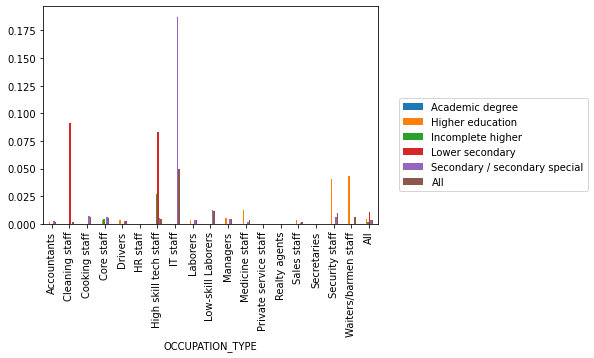

mean                                           \
NAME_FAMILY_STATUS    Civil marriage   Married Separated Single / not married   
OCCUPATION_TYPE                                                                 
Accountants                      0.0  0.002378  0.000000             0.000000   
Cleaning staff                   0.0  0.000000  0.000000             0.011628   
Cooking staff                    0.0  0.007500  0.000000             0.011111   
Core staff                       0.0  0.004908  0.013453             0.003630   
Drivers                          0.0  0.002402  0.000000             0.003984   
HR staff                         0.0  0.000000  0.000000             0.000000   
High skill tech staff            0.0  0.004859  0.000000             0.004808   
IT staff                         0.0  0.071429  0.000000             0.000000   
Laborers                         0.0  0.003475  0.002725             0.005280   
Low-skill Laborers               0.0  0.000000  0.000000             0.111111   
Managers                         0.0  0.003423  0.000000             0.017986   
Medicine staff                   0.0  0.003525  0.011364             0.000000   
Private service staff            0.0  0.000000  0.000000             0.000000   
Realty agents                    0.0  0.000000       NaN             0.000000   
Sales staff                      0.0  0.000865  0.004785             0.004310   
Secretaries                      0.0  0.000000       NaN             0.000000   
Security staff                   0.0  0.009685  0.000000             0.016393   
Waiters/barmen staff             0.0  0.011905  0.000000             0.000000   
All                              0.0  0.003541  0.004090             0.006096   

                                                     sum                    \
NAME_FAMILY_STATUS        Widow       All Civil marriage Married Separated   
OCCUPATION_TYPE                                                              
Accountants            0.000000  0.001612            0.0     2.0       0.0   
Cleaning staff         0.000000  0.001815            0.0     0.0       0.0   
Cooking staff          0.000000  0.006107            0.0     3.0       0.0   
Core staff             0.011765  0.005013            0.0    12.0       3.0   
Drivers                0.000000  0.002339            0.0     4.0       0.0   
HR staff               0.000000  0.000000            0.0     0.0       0.0   
High skill tech staff  0.000000  0.004338            0.0     5.0       0.0   
IT staff                    NaN  0.050000            0.0     3.0       0.0   
Laborers               0.000000  0.003381            0.0    15.0       1.0   
Low-skill Laborers          NaN  0.011429            0.0     0.0       0.0   
Managers               0.014925  0.004648            0.0     8.0       0.0   
Medicine staff         0.000000  0.003314            0.0     3.0       1.0   
Private service staff  0.000000  0.000000            0.0     0.0       0.0   
Realty agents               NaN  0.000000            0.0     0.0       NaN   
Sales staff            0.000000  0.001435            0.0     2.0       1.0   
Secretaries            0.000000  0.000000            0.0     0.0       NaN   
Security staff         0.050000  0.010135            0.0     4.0       0.0   
Waiters/barmen staff   0.000000  0.005747            0.0     1.0       0.0   
All                    0.005172  0.003660            0.0    62.0       6.0   

                                                              count           \
NAME_FAMILY_STATUS    Single / not married Widow All Civil marriage  Married   
OCCUPATION_TYPE                                                                
Accountants                            0.0   0.0   2          102.0    841.0   
Cleaning staff                         1.0   0.0   1           42.0    294.0   
Cooking staff                          1.0   0.0   4          108.0    400.0   
Core staff                             2.0   1.0  18

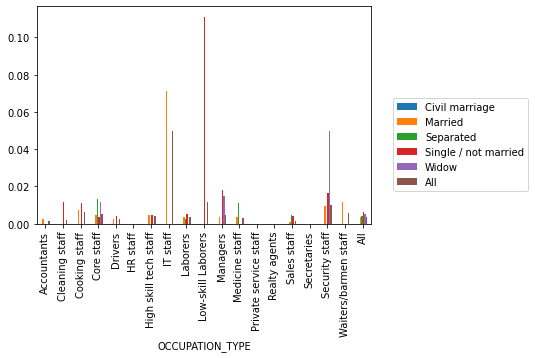

mean                                        \
NAME_HOUSING_TYPE     Co-op apartment House / apartment Municipal apartment   
OCCUPATION_TYPE                                                               
Accountants                  0.000000          0.001807            0.000000   
Cleaning staff                    NaN          0.000000            0.000000   
Cooking staff                0.000000          0.005455            0.028571   
Core staff                   0.090909          0.004806            0.017544   
Drivers                      0.000000          0.002682            0.000000   
HR staff                          NaN          0.000000                 NaN   
High skill tech staff        0.000000          0.004777            0.000000   
IT staff                          NaN          0.065217                 NaN   
Laborers                     0.028571          0.002982            0.000000   
Low-skill Laborers                NaN          0.012121            0.000000   
Managers                     0.000000          0.005069            0.000000   
Medicine staff               0.000000          0.003704            0.000000   
Private service staff             NaN          0.000000            0.000000   
Realty agents                     NaN          0.000000                 NaN   
Sales staff                  0.000000          0.001333            0.005181   
Secretaries                       NaN          0.000000            0.000000   
Security staff               0.000000          0.007576            0.033333   
Waiters/barmen staff              NaN          0.005848                 NaN   
All                          0.013158          0.003574            0.006158   

                                                                      \
NAME_HOUSING_TYPE     Office apartment Rented apartment With parents   
OCCUPATION_TYPE                                                        
Accountants                   0.000000         0.000000     0.000000   
Cleaning staff                0.000000         0.200000     0.000000   
Cooking staff                 0.000000         0.000000     0.000000   
Core staff                    0.000000         0.000000     0.000000   
Drivers                       0.000000         0.000000     0.000000   
HR staff                           NaN              NaN     0.000000   
High skill tech staff         0.000000         0.000000     0.000000   
IT staff                           NaN              NaN     0.000000   
Laborers                      0.000000         0.004902     0.008547   
Low-skill Laborers            0.000000              NaN     0.000000   
Managers                      0.000000         0.000000     0.000000   
Medicine staff                0.000000         0.000000     0.000000   
Private service staff              NaN              NaN     0.000000   
Realty agents                      NaN              NaN     0.000000   
Sales staff                   0.000000         0.000000     0.000000   
Secretaries                        NaN              NaN     0.000000   
Security staff                0.100000         0.000000     0.000000   
Waiters/barmen staff          0.000000              NaN     0.000000   
All                           0.005025         0.004556     0.002098   

                                            sum                    \
NAME_HOUSING_TYPE           All Co-op apartment House / apartment   
OCCUPATION_TYPE                                                     
Accountants            0.001612             0.0               2.0   
Cleaning staff         0.001815             NaN               0.0   
Cooking staff          0.006107             0.0               3.0   
Core staff             0.005013             1.0              15.0   
Drivers                0.002339             0.0               5.0   
HR staff               0.000000             NaN               0.0   
High skill tech staff  0.004338             0.0               6.0   
IT staff           

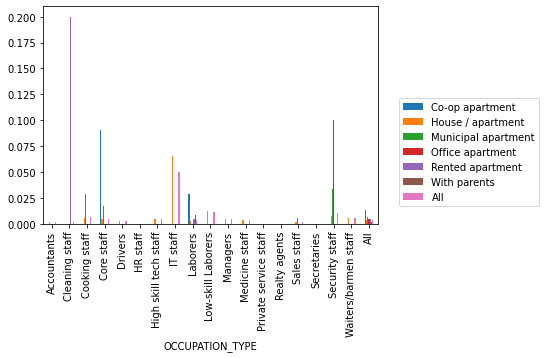

mean                     sum          count        \
FLAG_WORK_PHONE               0         1       All   0   1 All      0     1   
OCCUPATION_TYPE                                                                
Accountants            0.001159  0.002646  0.001612   1   1   2    863   378   
Cleaning staff         0.002841  0.000000  0.001815   1   0   1    352   199   
Cooking staff          0.003810  0.015385  0.006107   2   2   4    525   130   
Core staff             0.006709  0.000946  0.005013  17   1  18   2534  1057   
Drivers                0.001308  0.004926  0.002339   2   3   5   1529   609   
HR staff               0.000000  0.000000  0.000000   0   0   0     75    10   
High skill tech staff  0.005015  0.002591  0.004338   5   1   6    997   386   
IT staff               0.056604  0.000000  0.050000   3   0   3     53     7   
Laborers               0.003928  0.001843  0.003381  18   3  21   4583  1628   
Low-skill Laborers     0.018018  0.000000  0.011429   2   0   2    111    64   
Managers               0.004176  0.005834  0.004648   9   5  14   2155   857   
Medicine staff         0.003286  0.003401  0.003314   3   1   4    913   294   
Private service staff  0.000000  0.000000  0.000000   0   0   0    268    76   
Realty agents          0.000000  0.000000  0.000000   0   0   0     62    17   
Sales staff            0.001170  0.002174  0.001435   3   2   5   2565   920   
Secretaries            0.000000  0.000000  0.000000   0   0   0    110    41   
Security staff         0.013363  0.000000  0.010135   6   0   6    449   143   
Waiters/barmen staff   0.009259  0.000000  0.005747   1   0   1    108    66   
All                    0.004000  0.002761  0.003660  73  19  92  18252  6882   

                              
FLAG_WORK_PHONE          All  
OCCUPATION_TYPE               
Accountants             1241  
Cleaning staff           551  
Cooking staff            655  
Core staff              3591  
Drivers                 2138  
HR staff                  85  
High skill tech staff   1383  
IT staff                  60  
Laborers                6211  
Low-skill Laborers       175  
Managers                3012  
Medicine staff          1207  
Private service staff    344  
Realty agents             79  
Sales staff             3485  
Secretaries              151  
Security staff           592  
Waiters/barmen staff     174  
All                    25134

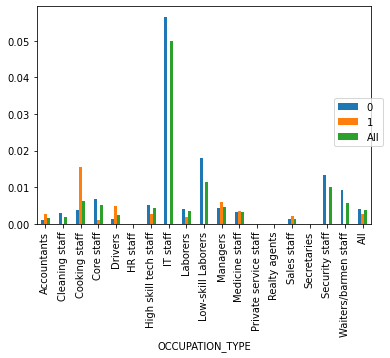

mean                     sum          count        \
FLAG_PHONE                    0         1       All   0   1 All      0     1   
OCCUPATION_TYPE                                                                
Accountants            0.002516  0.000000  0.001612   2   0   2    795   446   
Cleaning staff         0.002439  0.000000  0.001815   1   0   1    410   141   
Cooking staff          0.004107  0.011905  0.006107   2   2   4    487   168   
Core staff             0.003623  0.008130  0.005013   9   9  18   2484  1107   
Drivers                0.001321  0.004808  0.002339   2   3   5   1514   624   
HR staff               0.000000  0.000000  0.000000   0   0   0     70    15   
High skill tech staff  0.004540  0.003984  0.004338   4   2   6    881   502   
IT staff               0.068182  0.000000  0.050000   3   0   3     44    16   
Laborers               0.003495  0.003062  0.003381  16   5  21   4578  1633   
Low-skill Laborers     0.000000  0.036364  0.011429   0   2   2    120    55   
Managers               0.004735  0.004444  0.004648  10   4  14   2112   900   
Medicine staff         0.001136  0.009174  0.003314   1   3   4    880   327   
Private service staff  0.000000  0.000000  0.000000   0   0   0    225   119   
Realty agents          0.000000  0.000000  0.000000   0   0   0     52    27   
Sales staff            0.001652  0.000940  0.001435   4   1   5   2421  1064   
Secretaries            0.000000  0.000000  0.000000   0   0   0    103    48   
Security staff         0.012739  0.000000  0.010135   6   0   6    471   121   
Waiters/barmen staff   0.007812  0.000000  0.005747   1   0   1    128    46   
All                    0.003432  0.004213  0.003660  61  31  92  17775  7359   

                              
FLAG_PHONE               All  
OCCUPATION_TYPE               
Accountants             1241  
Cleaning staff           551  
Cooking staff            655  
Core staff              3591  
Drivers                 2138  
HR staff                  85  
High skill tech staff   1383  
IT staff                  60  
Laborers                6211  
Low-skill Laborers       175  
Managers                3012  
Medicine staff          1207  
Private service staff    344  
Realty agents             79  
Sales staff             3485  
Secretaries              151  
Security staff           592  
Waiters/barmen staff     174  
All                    25134

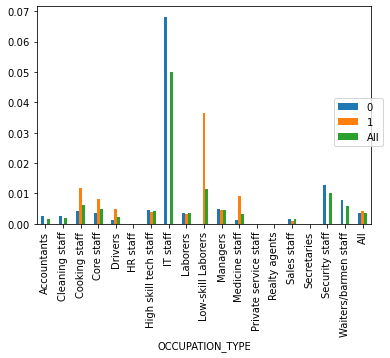

mean                     sum          count        \
FLAG_EMAIL                    0         1       All   0   1 All      0     1   
OCCUPATION_TYPE                                                                
Accountants            0.001852  0.000000  0.001612   2   0   2   1080   161   
Cleaning staff         0.001905  0.000000  0.001815   1   0   1    525    26   
Cooking staff          0.006568  0.000000  0.006107   4   0   4    609    46   
Core staff             0.004200  0.010081  0.005013  13   5  18   3095   496   
Drivers                0.002546  0.000000  0.002339   5   0   5   1964   174   
HR staff               0.000000  0.000000  0.000000   0   0   0     71    14   
High skill tech staff  0.004946  0.000000  0.004338   6   0   6   1213   170   
IT staff               0.000000  0.157895  0.050000   0   3   3     41    19   
Laborers               0.003475  0.002198  0.003381  20   1  21   5756   455   
Low-skill Laborers     0.011976  0.000000  0.011429   2   0   2    167     8   
Managers               0.005285  0.000000  0.004648  14   0  14   2649   363   
Medicine staff         0.001854  0.015625  0.003314   2   2   4   1079   128   
Private service staff  0.000000  0.000000  0.000000   0   0   0    295    49   
Realty agents          0.000000  0.000000  0.000000   0   0   0     70     9   
Sales staff            0.001580  0.000000  0.001435   5   0   5   3165   320   
Secretaries            0.000000  0.000000  0.000000   0   0   0    134    17   
Security staff         0.011342  0.000000  0.010135   6   0   6    529    63   
Waiters/barmen staff   0.000000  0.083333  0.005747   0   1   1    162    12   
All                    0.003539  0.004743  0.003660  80  12  92  22604  2530   

                              
FLAG_EMAIL               All  
OCCUPATION_TYPE               
Accountants             1241  
Cleaning staff           551  
Cooking staff            655  
Core staff              3591  
Drivers                 2138  
HR staff                  85  
High skill tech staff   1383  
IT staff                  60  
Laborers                6211  
Low-skill Laborers       175  
Managers                3012  
Medicine staff          1207  
Private service staff    344  
Realty agents             79  
Sales staff             3485  
Secretaries              151  
Security staff           592  
Waiters/barmen staff     174  
All                    25134

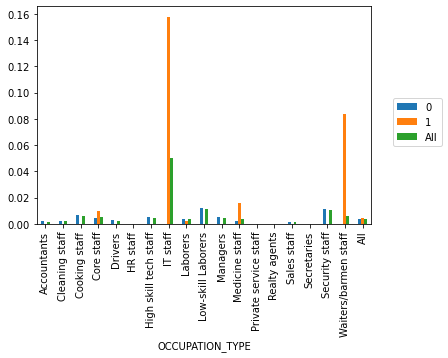

mean                                               \
CNT_FAM_MEMBERS             1.0       2.0       3.0       4.0  5.0  6.0  7.0   
OCCUPATION_TYPE                                                                
Accountants            0.000000  0.001479  0.004082  0.000000  0.0  0.0  NaN   
Cleaning staff         0.000000  0.004202  0.000000  0.000000  0.0  NaN  NaN   
Cooking staff          0.008772  0.008130  0.000000  0.000000  0.0  NaN  NaN   
Core staff             0.007587  0.004318  0.007585  0.000000  0.0  0.0  NaN   
Drivers                0.000000  0.002796  0.003891  0.000000  0.0  NaN  NaN   
HR staff               0.000000  0.000000  0.000000  0.000000  NaN  NaN  NaN   
High skill tech staff  0.004464  0.005698  0.000000  0.005376  0.0  0.0  NaN   
IT staff               0.000000  0.083333  0.000000  0.000000  NaN  NaN  NaN   
Laborers               0.002688  0.003771  0.004329  0.001517  0.0  0.0  0.0   
Low-skill Laborers     0.000000  0.000000  0.057143  0.000000  NaN  NaN  NaN   
Managers               0.008955  0.004397  0.002699  0.006579  0.0  0.0  0.0   
Medicine staff         0.004926  0.004298  0.000000  0.000000  0.0  0.0  NaN   
Private service staff  0.000000  0.000000  0.000000  0.000000  NaN  NaN  NaN   
Realty agents          0.000000  0.000000  0.000000  0.000000  NaN  NaN  NaN   
Sales staff            0.003295  0.000612  0.001147  0.003040  0.0  0.0  NaN   
Secretaries            0.000000  0.000000  0.000000  0.000000  NaN  NaN  NaN   
Security staff         0.010309  0.013889  0.000000  0.000000  0.0  0.0  NaN   
Waiters/barmen staff   0.000000  0.000000  0.043478  0.000000  0.0  NaN  NaN   
All                    0.003988  0.003938  0.003834  0.001941  0.0  0.0  0.0   

                                                 sum                        \
CNT_FAM_MEMBERS        9.0 15.0 20.0       All   1.0   2.0   3.0  4.0  5.0   
OCCUPATION_TYPE                                                              
Accountants            NaN  NaN  NaN  0.001612   0.0   1.0   1.0  0.0  0.0   
Cleaning staff         0.0  NaN  NaN  0.001815   0.0   1.0   0.0  0.0  0.0   
Cooking staff          NaN  NaN  NaN  0.006107   1.0   3.0   0.0  0.0  0.0   
Core staff             NaN  NaN  NaN  0.005013   5.0   7.0   6.0  0.0  0.0   
Drivers                NaN  0.0  NaN  0.002339   0.0   3.0   2.0  0.0  0.0   
HR staff               NaN  NaN  NaN  0.000000   0.0   0.0   0.0  0.0  NaN   
High skill tech staff  NaN  NaN  NaN  0.004338   1.0   4.0   0.0  1.0  0.0   
IT staff               NaN  NaN  NaN  0.050000   0.0   3.0   0.0  0.0  NaN   
Laborers               NaN  NaN  NaN  0.003381   3.0  12.0   5.0  1.0  0.0   
Low-skill Laborers     NaN  NaN  NaN  0.011429   0.0   0.0   2.0  0.0  NaN   
Managers               NaN  NaN  NaN  0.004648   3.0   7.0   2.0  2.0  0.0   
Medicine staff         NaN  NaN  NaN  0.003314   1.0   3.0   0.0  0.0  0.0   
Private service staff  NaN  NaN  NaN  0.000000   0.0   0.0   0.0  0.0  NaN   
Realty agents          NaN  NaN  NaN  0.000000   0.0   0.0   0.0  0.0  NaN   
Sales staff            NaN  NaN  NaN  0.001435   2.0   1.0   1.0  1.0  0.0   
Secretaries            NaN  NaN  NaN  0.000000   0.0   0.0   0.0  0.0  NaN   
Security staff         NaN  NaN  NaN  0.010135   1.0   5.0   0.0  0.0  0.0   
Waiters/barmen staff   NaN  NaN  0.0  0.005747   0.0   0.0   1.0  0.0  0.0   
All                    0.0  0.0  0.0  0.003660  17.0  50.0  20.0  5.0  0.0   

                                                     count                   \
CNT_FAM_MEMBERS        6.0  7.0  9.0 15.0 20.0 All     1.0      2.0     3.0   
OCCUPATION_TYPE                                                               
Accountants            0.0  NaN  NaN  NaN  NaN   2   210.0    676.0   245.0   
Cleaning staff         NaN  NaN  0.0  NaN  NaN   1   190.0    238.0    72.0   
Cooking staff          NaN  NaN  NaN  NaN  NaN   4   114.0    369.0   128.0   
Core staff             0.0  NaN  NaN  NaN  NaN  18   659.0   1621.0   791.0

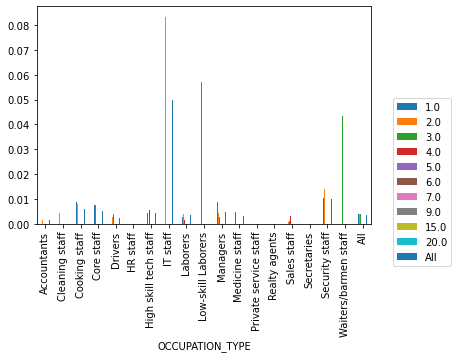

In [36]:
### 8. Table & chart comparison of late ratio vs feature pairs (OCCUPATION_TYPE vs ALL)

import matplotlib.pyplot as plt

L1_features=['FLAG_PHONE', 'FLAG_EMAIL', 'OCCUPATION_TYPE', 'CNT_FAM_MEMBERS']
L2_features=['CODE_GENDER','FLAG_OWN_CAR','FLAG_OWN_REALTY', 'CNT_CHILDREN', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',  'NAME_FAMILY_STATUS',
'NAME_HOUSING_TYPE', 'FLAG_WORK_PHONE', 'FLAG_PHONE', 'FLAG_EMAIL', 'CNT_FAM_MEMBERS']
L2_featuers_disc= ['AMT_INCOME_TOTAL','DAYS_BIRTH', 'DAYS_EMPLOYED']
features_excl=['OCCUPATION_TYPE','FLAG_EMAIL','FLAG_MOBIL']

for el in L2_features:
    display(pd.pivot_table(app_and_credit_label_2,index='OCCUPATION_TYPE',columns=el,values='all_late_flag',aggfunc=['mean','sum','count'],margins=True))
    temp_table=pd.pivot_table(app_and_credit_label_2,index='OCCUPATION_TYPE',columns=el,values='all_late_flag',aggfunc='mean',margins=True)
    temp_table.plot(kind='bar')
    plt.legend(bbox_to_anchor = (1.05, 0.6))    
    plt.show()

mean                                                    \
CNT_FAM_MEMBERS      1.0       2.0       3.0       4.0  5.0  6.0  7.0  9.0    
CODE_GENDER                                                                   
F                0.003055  0.003314  0.002077  0.001692  0.0  0.0  0.0  0.0   
M                0.005718  0.004526  0.005447  0.002251  0.0  0.0  0.0  NaN   

                            sum                                            \
CNT_FAM_MEMBERS 15.0 20.0  1.0   2.0   3.0  4.0  5.0  6.0  7.0  9.0  15.0   
CODE_GENDER                                                                 
F                NaN  0.0  16.0  44.0   8.0  3.0  0.0  0.0  0.0  0.0  NaN   
M                0.0  NaN  10.0  28.0  14.0  3.0  0.0  0.0  0.0  NaN  0.0   

                       count                                                   \
CNT_FAM_MEMBERS 20.0    1.0      2.0     3.0     4.0    5.0   6.0   7.0  9.0    
CODE_GENDER                                                                     
F                0.0  5238.0  13277.0  3851.0  1773.0  236.0  42.0  10.0  2.0   
M                NaN  1749.0   6186.0  2570.0  1333.0  161.0  16.0   9.0  NaN   

                           
CNT_FAM_MEMBERS 15.0 20.0  
CODE_GENDER                
F                NaN  1.0  
M                3.0  NaN

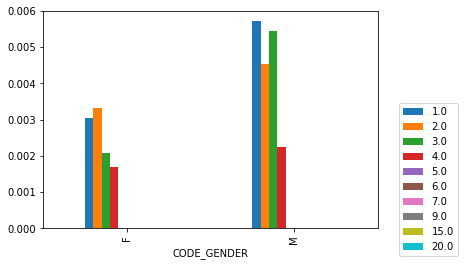

mean                                                    \
CNT_FAM_MEMBERS      1.0       2.0       3.0       4.0  5.0  6.0  7.0  9.0    
FLAG_OWN_CAR                                                                  
N                0.003769  0.003324  0.002574  0.000650  0.0  0.0  0.0  0.0   
Y                0.003569  0.004307  0.004446  0.003191  0.0  0.0  0.0  NaN   

                            sum                                            \
CNT_FAM_MEMBERS 15.0 20.0  1.0   2.0   3.0  4.0  5.0  6.0  7.0  9.0  15.0   
FLAG_OWN_CAR                                                                
N                NaN  0.0  20.0  40.0   9.0  1.0  0.0  0.0  0.0  0.0  NaN   
Y                0.0  NaN   6.0  32.0  13.0  5.0  0.0  0.0  0.0  NaN  0.0   

                       count                                                   \
CNT_FAM_MEMBERS 20.0    1.0      2.0     3.0     4.0    5.0   6.0   7.0  9.0    
FLAG_OWN_CAR                                                                    
N                0.0  5306.0  12034.0  3497.0  1539.0  211.0  15.0   9.0  2.0   
Y                NaN  1681.0   7429.0  2924.0  1567.0  186.0  43.0  10.0  NaN   

                           
CNT_FAM_MEMBERS 15.0 20.0  
FLAG_OWN_CAR               
N                NaN  1.0  
Y                3.0  NaN

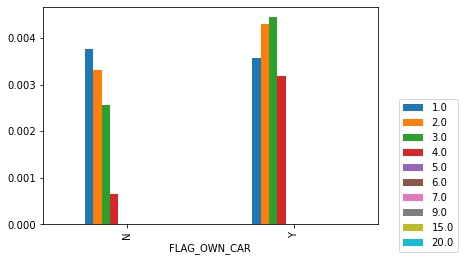

mean                                                    \
CNT_FAM_MEMBERS      1.0       2.0       3.0       4.0  5.0  6.0  7.0  9.0    
FLAG_OWN_REALTY                                                               
N                0.004977  0.002805  0.005143  0.002838  0.0  0.0  0.0  0.0   
Y                0.003140  0.004139  0.002569  0.001464  0.0  0.0  0.0  NaN   

                            sum                                            \
CNT_FAM_MEMBERS 15.0 20.0  1.0   2.0   3.0  4.0  5.0  6.0  7.0  9.0  15.0   
FLAG_OWN_REALTY                                                             
N                NaN  NaN  11.0  18.0  11.0  3.0  0.0  0.0  0.0  0.0  NaN   
Y                0.0  0.0  15.0  54.0  11.0  3.0  0.0  0.0  0.0  NaN  0.0   

                       count                                                   \
CNT_FAM_MEMBERS 20.0    1.0      2.0     3.0     4.0    5.0   6.0   7.0  9.0    
FLAG_OWN_REALTY                                                                 
N                NaN  2210.0   6417.0  2139.0  1057.0  102.0  22.0   2.0  2.0   
Y                0.0  4777.0  13046.0  4282.0  2049.0  295.0  36.0  17.0  NaN   

                           
CNT_FAM_MEMBERS 15.0 20.0  
FLAG_OWN_REALTY            
N                NaN  NaN  
Y                3.0  1.0

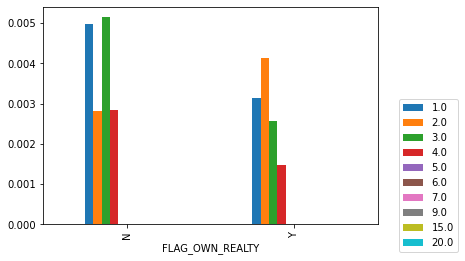

mean                                               \
CNT_FAM_MEMBERS           1.0       2.0       3.0       4.0  5.0  6.0  7.0    
NAME_INCOME_TYPE                                                              
Commercial associate  0.006435  0.005068  0.003986  0.004021  0.0  0.0  NaN   
Pensioner             0.003808  0.004164  0.017544  0.000000  0.0  NaN  NaN   
State servant         0.000000  0.000657  0.001739  0.002703  0.0  0.0  NaN   
Student               0.000000  0.000000  0.000000       NaN  NaN  NaN  NaN   
Working               0.002885  0.003366  0.002808  0.001030  0.0  0.0  0.0   

                                      sum                                  \
CNT_FAM_MEMBERS      9.0  15.0 20.0  1.0   2.0   3.0  4.0  5.0  6.0  7.0    
NAME_INCOME_TYPE                                                            
Commercial associate  NaN  NaN  NaN  10.0  22.0   7.0  3.0  0.0  0.0  NaN   
Pensioner             NaN  NaN  NaN   7.0  17.0   3.0  0.0  0.0  NaN  NaN   
State servant         NaN  NaN  NaN   0.0   1.0   1.0  1.0  0.0  0.0  NaN   
Student               NaN  NaN  NaN   0.0   0.0   0.0  NaN  NaN  NaN  NaN   
Working               0.0  0.0  0.0   9.0  32.0  11.0  2.0  0.0  0.0  0.0   

                                      count                                 \
CNT_FAM_MEMBERS      9.0  15.0 20.0    1.0     2.0     3.0     4.0    5.0    
NAME_INCOME_TYPE                                                             
Commercial associate  NaN  NaN  NaN  1554.0  4341.0  1756.0   746.0   80.0   
Pensioner             NaN  NaN  NaN  1838.0  4083.0   171.0    49.0   11.0   
State servant         NaN  NaN  NaN   474.0  1523.0   575.0   370.0   37.0   
Student               NaN  NaN  NaN     1.0     8.0     2.0     NaN    NaN   
Working               0.0  0.0  0.0  3120.0  9508.0  3917.0  1941.0  269.0   

                                                 
CNT_FAM_MEMBERS       6.0   7.0  9.0  15.0 20.0  
NAME_INCOME_TYPE                                 
Commercial associate  13.0   NaN  NaN  NaN  NaN  
Pensioner              NaN   NaN  NaN  NaN  NaN  
State servant          6.0   NaN  NaN  NaN  NaN  
Student                NaN   NaN  NaN  NaN  NaN  
Working               39.0  19.0  2.0  3.0  1.0

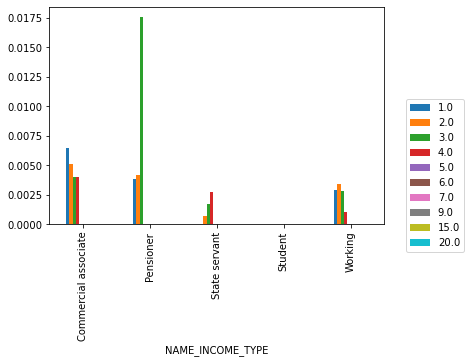

mean                                     \
CNT_FAM_MEMBERS                    1.0       2.0       3.0       4.0  5.0    
NAME_EDUCATION_TYPE                                                          
Academic degree                     NaN  0.000000  0.000000       NaN  NaN   
Higher education               0.007892  0.004379  0.003642  0.002868  0.0   
Incomplete higher              0.003021  0.000000  0.003236  0.000000  0.0   
Lower secondary                0.000000  0.008584  0.000000  0.000000  NaN   
Secondary / secondary special  0.002281  0.003538  0.003400  0.001567  0.0   

                                                         sum                   \
CNT_FAM_MEMBERS               6.0  7.0  9.0  15.0 20.0  1.0   2.0   3.0  4.0    
NAME_EDUCATION_TYPE                                                             
Academic degree                NaN  NaN  NaN  NaN  NaN   NaN   0.0   0.0  NaN   
Higher education               0.0  NaN  NaN  NaN  NaN  14.0  22.0   7.0  3.0   
Incomplete higher              0.0  NaN  NaN  NaN  NaN   1.0   0.0   1.0  0.0   
Lower secondary                0.0  NaN  NaN  NaN  NaN   0.0   2.0   0.0  0.0   
Secondary / secondary special  0.0  0.0  0.0  0.0  0.0  11.0  48.0  14.0  3.0   

                                                              count           \
CNT_FAM_MEMBERS               5.0  6.0  7.0  9.0  15.0 20.0    1.0      2.0    
NAME_EDUCATION_TYPE                                                            
Academic degree                NaN  NaN  NaN  NaN  NaN  NaN     NaN     17.0   
Higher education               0.0  0.0  NaN  NaN  NaN  NaN  1774.0   5024.0   
Incomplete higher              0.0  0.0  NaN  NaN  NaN  NaN   331.0    623.0   
Lower secondary                NaN  0.0  NaN  NaN  NaN  NaN    59.0    233.0   
Secondary / secondary special  0.0  0.0  0.0  0.0  0.0  0.0  4823.0  13566.0   

                                                                            \
CNT_FAM_MEMBERS                  3.0     4.0    5.0   6.0   7.0  9.0  15.0   
NAME_EDUCATION_TYPE                                                          
Academic degree                  15.0     NaN    NaN   NaN   NaN  NaN  NaN   
Higher education               1922.0  1046.0   79.0  19.0   NaN  NaN  NaN   
Incomplete higher               309.0   122.0   19.0   6.0   NaN  NaN  NaN   
Lower secondary                  57.0    24.0    NaN   1.0   NaN  NaN  NaN   
Secondary / secondary special  4118.0  1914.0  299.0  32.0  19.0  2.0  3.0   

                                    
CNT_FAM_MEMBERS               20.0  
NAME_EDUCATION_TYPE                 
Academic degree                NaN  
Higher education               NaN  
Incomplete higher              NaN  
Lower secondary                NaN  
Secondary / secondary special  1.0

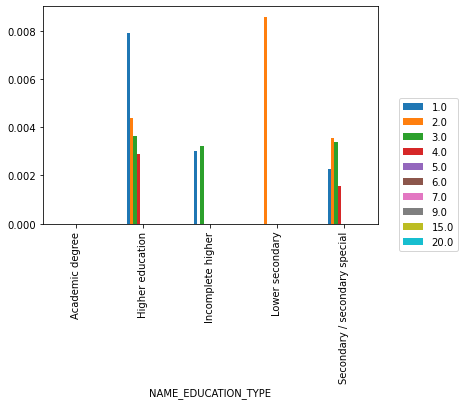

mean                                               \
CNT_FAM_MEMBERS           1.0       2.0       3.0       4.0  5.0  6.0  7.0    
NAME_FAMILY_STATUS                                                            
Civil marriage        0.000000  0.000000  0.001279  0.000000  0.0  NaN  NaN   
Married               0.000000  0.003810  0.003115  0.002095  0.0  0.0  0.0   
Separated             0.006106  0.003817  0.000000  0.000000  0.0  0.0  NaN   
Single / not married  0.002942  0.012422  0.047619  0.000000  NaN  NaN  NaN   
Widow                 0.003501  0.000000  0.000000  0.000000  NaN  NaN  NaN   

                                      sum                                  \
CNT_FAM_MEMBERS      9.0  15.0 20.0  1.0   2.0   3.0  4.0  5.0  6.0  7.0    
NAME_FAMILY_STATUS                                                          
Civil marriage        NaN  NaN  NaN   0.0   0.0   1.0  0.0  0.0  NaN  NaN   
Married               0.0  NaN  NaN   0.0  62.0  17.0  6.0  0.0  0.0  0.0   
Separated             NaN  0.0  NaN   9.0   2.0   0.0  0.0  0.0  0.0  NaN   
Single / not married  NaN  NaN  0.0  12.0   8.0   4.0  0.0  NaN  NaN  NaN   
Widow                 NaN  NaN  NaN   5.0   0.0   0.0  0.0  NaN  NaN  NaN   

                                      count                                  \
CNT_FAM_MEMBERS      9.0  15.0 20.0    1.0      2.0     3.0     4.0    5.0    
NAME_FAMILY_STATUS                                                            
Civil marriage        NaN  NaN  NaN     1.0   1930.0   782.0   211.0   21.0   
Married               0.0  NaN  NaN     5.0  16274.0  5457.0  2864.0  370.0   
Separated             NaN  0.0  NaN  1474.0    524.0    91.0     4.0    6.0   
Single / not married  NaN  NaN  0.0  4079.0    644.0    84.0    21.0    NaN   
Widow                 NaN  NaN  NaN  1428.0     91.0     7.0     6.0    NaN   

                                                 
CNT_FAM_MEMBERS       6.0   7.0  9.0  15.0 20.0  
NAME_FAMILY_STATUS                               
Civil marriage         NaN   NaN  NaN  NaN  NaN  
Married               57.0  19.0  2.0  NaN  NaN  
Separated              1.0   NaN  NaN  3.0  NaN  
Single / not married   NaN   NaN  NaN  NaN  1.0  
Widow                  NaN   NaN  NaN  NaN  NaN

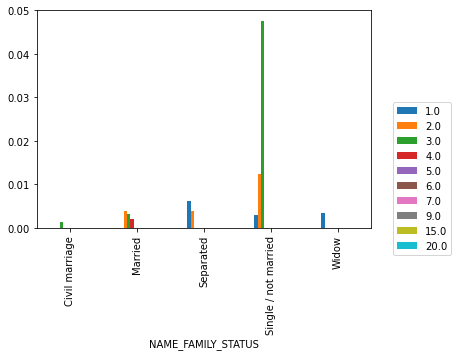

mean                                               \
CNT_FAM_MEMBERS          1.0       2.0       3.0       4.0  5.0  6.0  7.0    
NAME_HOUSING_TYPE                                                            
Co-op apartment      0.031250  0.011236  0.000000  0.000000  0.0  NaN  0.0   
House / apartment    0.003581  0.003747  0.003235  0.001798  0.0  0.0  0.0   
Municipal apartment  0.013889  0.000000  0.009009  0.018519  0.0  NaN  NaN   
Office apartment     0.000000  0.008333  0.000000  0.000000  0.0  NaN  NaN   
Rented apartment     0.000000  0.004219  0.008333  0.000000  NaN  NaN  NaN   
With parents         0.000000  0.003876  0.002375  0.000000  0.0  NaN  NaN   

                                     sum                                       \
CNT_FAM_MEMBERS     9.0  15.0 20.0  1.0   2.0   3.0  4.0  5.0  6.0  7.0  9.0    
NAME_HOUSING_TYPE                                                               
Co-op apartment      NaN  NaN  NaN   1.0   1.0   0.0  0.0  0.0  NaN  0.0  NaN   
House / apartment    0.0  0.0  0.0  22.0  66.0  18.0  5.0  0.0  0.0  0.0  0.0   
Municipal apartment  NaN  NaN  NaN   3.0   0.0   2.0  1.0  0.0  NaN  NaN  NaN   
Office apartment     NaN  NaN  NaN   0.0   1.0   0.0  0.0  0.0  NaN  NaN  NaN   
Rented apartment     NaN  NaN  NaN   0.0   1.0   1.0  0.0  NaN  NaN  NaN  NaN   
With parents         NaN  NaN  NaN   0.0   3.0   1.0  0.0  0.0  NaN  NaN  NaN   

                                count                                        \
CNT_FAM_MEMBERS     15.0 20.0    1.0      2.0     3.0     4.0    5.0   6.0    
NAME_HOUSING_TYPE                                                             
Co-op apartment      NaN  NaN    32.0     89.0    15.0    23.0    1.0   NaN   
House / apartment    0.0  0.0  6144.0  17615.0  5564.0  2781.0  369.0  58.0   
Municipal apartment  NaN  NaN   216.0    628.0   222.0    54.0    8.0   NaN   
Office apartment     NaN  NaN    32.0    120.0    79.0    29.0    2.0   NaN   
Rented apartment     NaN  NaN   189.0    237.0   120.0    29.0    NaN   NaN   
With parents         NaN  NaN   374.0    774.0   421.0   190.0   17.0   NaN   

                                          
CNT_FAM_MEMBERS      7.0  9.0  15.0 20.0  
NAME_HOUSING_TYPE                         
Co-op apartment       8.0  NaN  NaN  NaN  
House / apartment    11.0  2.0  3.0  1.0  
Municipal apartment   NaN  NaN  NaN  NaN  
Office apartment      NaN  NaN  NaN  NaN  
Rented apartment      NaN  NaN  NaN  NaN  
With parents          NaN  NaN  NaN  NaN

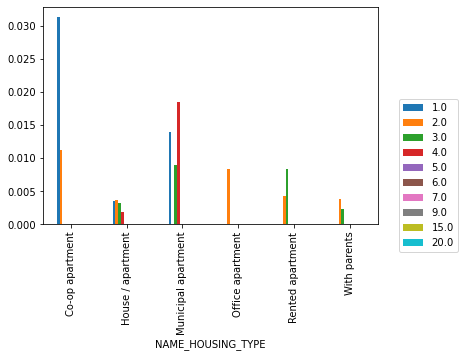

mean                                                    \
CNT_FAM_MEMBERS      1.0       2.0       3.0       4.0  5.0  6.0  7.0  9.0    
FLAG_WORK_PHONE                                                               
0                0.003691  0.003893  0.003504  0.000920  0.0  0.0  0.0  NaN   
1                0.003855  0.003019  0.003187  0.004296  0.0  0.0  0.0  0.0   

                            sum                                            \
CNT_FAM_MEMBERS 15.0 20.0  1.0   2.0   3.0  4.0  5.0  6.0  7.0  9.0  15.0   
FLAG_WORK_PHONE                                                             
0                0.0  NaN  21.0  59.0  17.0  2.0  0.0  0.0  0.0  NaN  0.0   
1                NaN  0.0   5.0  13.0   5.0  4.0  0.0  0.0  0.0  0.0  NaN   

                       count                                                   \
CNT_FAM_MEMBERS 20.0    1.0      2.0     3.0     4.0    5.0   6.0   7.0  9.0    
FLAG_WORK_PHONE                                                                 
0                NaN  5690.0  15157.0  4852.0  2175.0  293.0  48.0  17.0  NaN   
1                0.0  1297.0   4306.0  1569.0   931.0  104.0  10.0   2.0  2.0   

                           
CNT_FAM_MEMBERS 15.0 20.0  
FLAG_WORK_PHONE            
0                3.0  NaN  
1                NaN  1.0

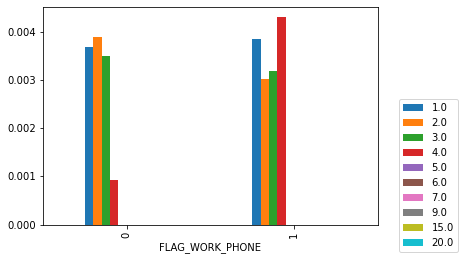

mean                                                    \
CNT_FAM_MEMBERS      1.0       2.0       3.0       4.0  5.0  6.0  7.0  9.0    
FLAG_PHONE                                                                    
0                0.003395  0.003910  0.002174  0.001376  0.0  0.0  0.0  NaN   
1                0.004548  0.003217  0.006590  0.003243  0.0  0.0  NaN  0.0   

                            sum                                            \
CNT_FAM_MEMBERS 15.0 20.0  1.0   2.0   3.0  4.0  5.0  6.0  7.0  9.0  15.0   
FLAG_PHONE                                                                  
0                0.0  NaN  17.0  53.0  10.0  3.0  0.0  0.0  0.0  NaN  0.0   
1                NaN  0.0   9.0  19.0  12.0  3.0  0.0  0.0  NaN  0.0  NaN   

                       count                                                   \
CNT_FAM_MEMBERS 20.0    1.0      2.0     3.0     4.0    5.0   6.0   7.0  9.0    
FLAG_PHONE                                                                      
0                NaN  5008.0  13556.0  4600.0  2181.0  290.0  52.0  19.0  NaN   
1                0.0  1979.0   5907.0  1821.0   925.0  107.0   6.0   NaN  2.0   

                           
CNT_FAM_MEMBERS 15.0 20.0  
FLAG_PHONE                 
0                3.0  NaN  
1                NaN  1.0

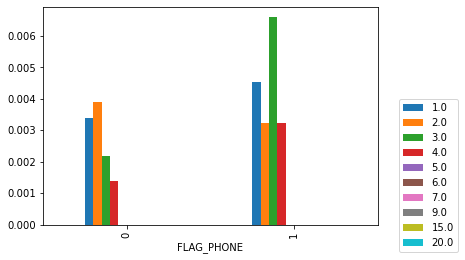

mean                                                    \
CNT_FAM_MEMBERS      1.0       2.0       3.0       4.0  5.0  6.0  7.0  9.0    
FLAG_EMAIL                                                                    
0                0.003918  0.003588  0.002812  0.002114  0.0  0.0  0.0  0.0   
1                0.001650  0.004926  0.008208  0.000000  0.0  0.0  NaN  NaN   

                            sum                                            \
CNT_FAM_MEMBERS 15.0 20.0  1.0   2.0   3.0  4.0  5.0  6.0  7.0  9.0  15.0   
FLAG_EMAIL                                                                  
0                0.0  0.0  25.0  64.0  16.0  6.0  0.0  0.0  0.0  0.0  0.0   
1                NaN  NaN   1.0   8.0   6.0  0.0  0.0  0.0  NaN  NaN  NaN   

                       count                                                   \
CNT_FAM_MEMBERS 20.0    1.0      2.0     3.0     4.0    5.0   6.0   7.0  9.0    
FLAG_EMAIL                                                                      
0                0.0  6381.0  17839.0  5690.0  2838.0  356.0  57.0  19.0  2.0   
1                NaN   606.0   1624.0   731.0   268.0   41.0   1.0   NaN  NaN   

                           
CNT_FAM_MEMBERS 15.0 20.0  
FLAG_EMAIL                 
0                3.0  1.0  
1                NaN  NaN

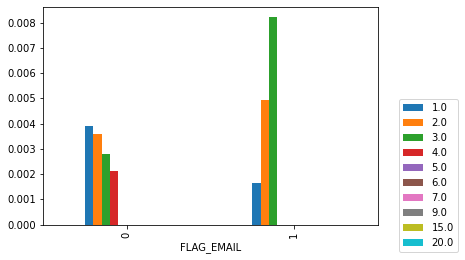

mean                                               \
CNT_FAM_MEMBERS            1.0       2.0       3.0       4.0  5.0  6.0  7.0    
OCCUPATION_TYPE                                                                
Accountants            0.000000  0.001479  0.004082  0.000000  0.0  0.0  NaN   
Cleaning staff         0.000000  0.004202  0.000000  0.000000  0.0  NaN  NaN   
Cooking staff          0.008772  0.008130  0.000000  0.000000  0.0  NaN  NaN   
Core staff             0.007587  0.004318  0.007585  0.000000  0.0  0.0  NaN   
Drivers                0.000000  0.002796  0.003891  0.000000  0.0  NaN  NaN   
HR staff               0.000000  0.000000  0.000000  0.000000  NaN  NaN  NaN   
High skill tech staff  0.004464  0.005698  0.000000  0.005376  0.0  0.0  NaN   
IT staff               0.000000  0.083333  0.000000  0.000000  NaN  NaN  NaN   
Laborers               0.002688  0.003771  0.004329  0.001517  0.0  0.0  0.0   
Low-skill Laborers     0.000000  0.000000  0.057143  0.000000  NaN  NaN  NaN   
Managers               0.008955  0.004397  0.002699  0.006579  0.0  0.0  0.0   
Medicine staff         0.004926  0.004298  0.000000  0.000000  0.0  0.0  NaN   
Private service staff  0.000000  0.000000  0.000000  0.000000  NaN  NaN  NaN   
Realty agents          0.000000  0.000000  0.000000  0.000000  NaN  NaN  NaN   
Sales staff            0.003295  0.000612  0.001147  0.003040  0.0  0.0  NaN   
Secretaries            0.000000  0.000000  0.000000  0.000000  NaN  NaN  NaN   
Security staff         0.010309  0.013889  0.000000  0.000000  0.0  0.0  NaN   
Waiters/barmen staff   0.000000  0.000000  0.043478  0.000000  0.0  NaN  NaN   

                                      sum                                      \
CNT_FAM_MEMBERS       9.0  15.0 20.0 1.0   2.0  3.0  4.0  5.0  6.0  7.0  9.0    
OCCUPATION_TYPE                                                                 
Accountants            NaN  NaN  NaN  0.0   1.0  1.0  0.0  0.0  0.0  NaN  NaN   
Cleaning staff         0.0  NaN  NaN  0.0   1.0  0.0  0.0  0.0  NaN  NaN  0.0   
Cooking staff          NaN  NaN  NaN  1.0   3.0  0.0  0.0  0.0  NaN  NaN  NaN   
Core staff             NaN  NaN  NaN  5.0   7.0  6.0  0.0  0.0  0.0  NaN  NaN   
Drivers                NaN  0.0  NaN  0.0   3.0  2.0  0.0  0.0  NaN  NaN  NaN   
HR staff               NaN  NaN  NaN  0.0   0.0  0.0  0.0  NaN  NaN  NaN  NaN   
High skill tech staff  NaN  NaN  NaN  1.0   4.0  0.0  1.0  0.0  0.0  NaN  NaN   
IT staff               NaN  NaN  NaN  0.0   3.0  0.0  0.0  NaN  NaN  NaN  NaN   
Laborers               NaN  NaN  NaN  3.0  12.0  5.0  1.0  0.0  0.0  0.0  NaN   
Low-skill Laborers     NaN  NaN  NaN  0.0   0.0  2.0  0.0  NaN  NaN  NaN  NaN   
Managers               NaN  NaN  NaN  3.0   7.0  2.0  2.0  0.0  0.0  0.0  NaN   
Medicine staff         NaN  NaN  NaN  1.0   3.0  0.0  0.0  0.0  0.0  NaN  NaN   
Private service staff  NaN  NaN  NaN  0.0   0.0  0.0  0.0  NaN  NaN  NaN  NaN   
Realty agents          NaN  NaN  NaN  0.0   0.0  0.0  0.0  NaN  NaN  NaN  NaN   
Sales staff            NaN  NaN  NaN  2.0   1.0  1.0  1.0  0.0  0.0  NaN  NaN   
Secretaries            NaN  NaN  NaN  0.0   0.0  0.0  0.0  NaN  NaN  NaN  NaN   
Security staff         NaN  NaN  NaN  1.0   5.0  0.0  0.0  0.0  0.0  NaN  NaN   
Waiters/barmen staff   NaN  NaN  0.0  0.0   0.0  1.0  0.0  0.0  NaN  NaN  NaN   

                                  count                                     \
CNT_FAM_MEMBERS       15.0 20.0    1.0     2.0     3.0    4.0   5.0   6.0    
OCCUPATION_TYPE                                                              
Accountants            NaN  NaN   210.0   676.0   245.0   89.0  20.0   1.0   
Cleaning staff         NaN  NaN   190.0   238.0    72.0   44.0   5.0   NaN   
Cooking staff          NaN  NaN   114.0   369.0   128.0   43.0   1.0   NaN   
Core staff             NaN  NaN   659.0  1621.0   791.0  429.0  64.0  27.0   
Drivers                0.0  NaN   288.0  1073.0   514.0  238.0  22.0   NaN   
HR staff            

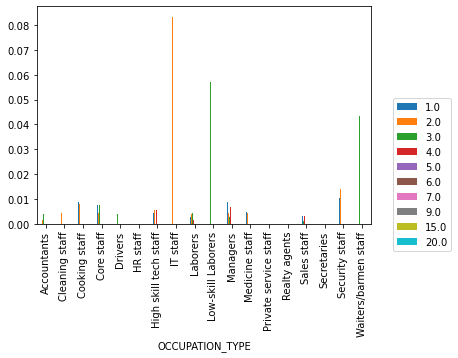

In [37]:
### 9. Table & chart comparison of late ratio vs feature pairs (CNT_FAM_MEMBERS vs ALL)


import matplotlib.pyplot as plt

L1_features=['FLAG_PHONE', 'FLAG_EMAIL', 'OCCUPATION_TYPE', 'CNT_FAM_MEMBERS']
L2_features=['CODE_GENDER','FLAG_OWN_CAR','FLAG_OWN_REALTY', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',  'NAME_FAMILY_STATUS',
'NAME_HOUSING_TYPE', 'FLAG_WORK_PHONE', 'FLAG_PHONE', 'FLAG_EMAIL', 'OCCUPATION_TYPE']
L2_featuers_disc= ['AMT_INCOME_TOTAL','DAYS_BIRTH', 'DAYS_EMPLOYED']
features_excl=['OCCUPATION_TYPE','FLAG_EMAIL','FLAG_MOBIL']

for el in L2_features:
    display(pd.pivot_table(app_and_credit_label_2,index=el,columns='CNT_FAM_MEMBERS',values='all_late_flag',aggfunc=['mean','sum','count']))
    temp_table=pd.pivot_table(app_and_credit_label_2,index=el,columns='CNT_FAM_MEMBERS',values='all_late_flag',aggfunc='mean')
    temp_table.plot(kind='bar')
    plt.legend(bbox_to_anchor = (1.05, 0.6))    
    plt.show()



mean            count      
CODE_GENDER         F         M      F     M
FLAG_PHONE                                  
0            0.002703  0.004257  17018  8691
1            0.003373  0.005396   7412  3336

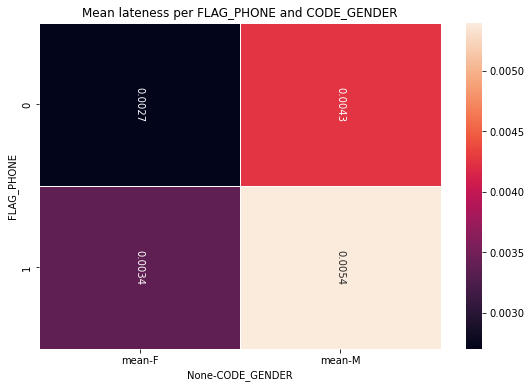

mean            count      
FLAG_OWN_CAR         N         Y      N     Y
FLAG_PHONE                                   
0             0.003474  0.002835  15834  9875
1             0.002212  0.007056   6780  3968

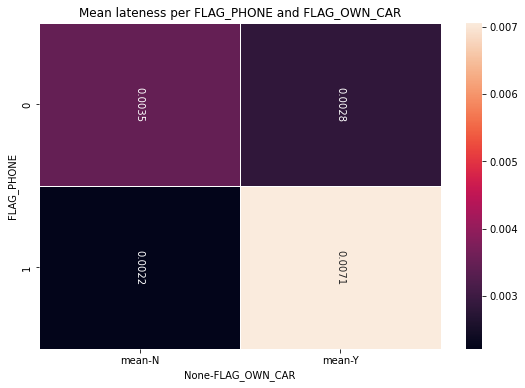

mean           count       
FLAG_OWN_REALTY         N         Y     N      Y
FLAG_PHONE                                      
0                0.003288  0.003202  7908  17801
1                0.004205  0.003878  4043   6705

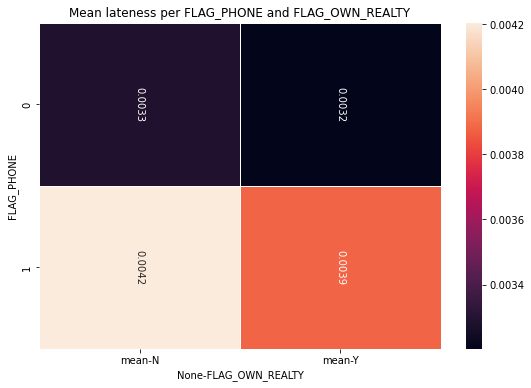

mean                                                    \
CNT_CHILDREN        0         1         2    3    4    5    7    14   19   
FLAG_PHONE                                                                 
0             0.003687  0.002775  0.001310  0.0  0.0  0.0  NaN  0.0  NaN   
1             0.003433  0.006711  0.003106  0.0  0.0  0.0  0.0  NaN  0.0   

                count                                                    
CNT_CHILDREN       0       1       2      3     4     5    7    14   19  
FLAG_PHONE                                                               
0             17628.0  5406.0  2290.0  311.0  52.0  19.0  NaN  3.0  NaN  
1              7573.0  2086.0   966.0  108.0  11.0   1.0  2.0  NaN  1.0

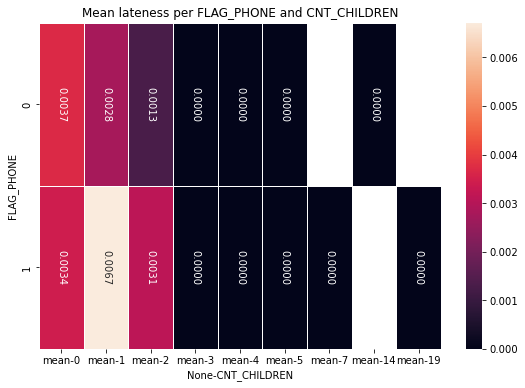

mean                                  \
NAME_INCOME_TYPE Commercial associate Pensioner State servant Student   
FLAG_PHONE                                                              
0                            0.003337  0.004570      0.000940     0.0   
1                            0.008814  0.003941      0.001166     NaN   

                                          count                          \
NAME_INCOME_TYPE   Working Commercial associate Pensioner State servant   
FLAG_PHONE                                                                
0                 0.003106               5994.0    4376.0        2127.0   
1                 0.002314               2496.0    1776.0         858.0   

                                   
NAME_INCOME_TYPE Student  Working  
FLAG_PHONE                         
0                   11.0  13201.0  
1                    NaN   5618.0

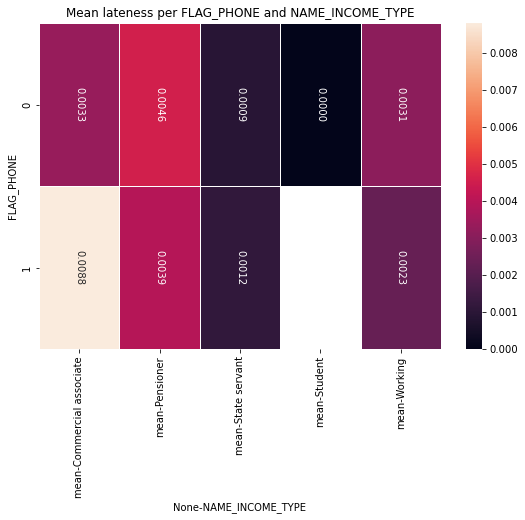

mean                                     \
NAME_EDUCATION_TYPE Academic degree Higher education Incomplete higher   
FLAG_PHONE                                                               
0                               0.0         0.003885          0.000000   
1                               0.0         0.006307          0.003788   

                                                                   \
NAME_EDUCATION_TYPE Lower secondary Secondary / secondary special   
FLAG_PHONE                                                          
0                          0.003484                      0.003141   
1                          0.011494                      0.002878   

                              count                                     \
NAME_EDUCATION_TYPE Academic degree Higher education Incomplete higher   
FLAG_PHONE                                                               
0                                20             6693               882   
1                                12             3171               528   

                                                                   
NAME_EDUCATION_TYPE Lower secondary Secondary / secondary special  
FLAG_PHONE                                                         
0                               287                         17827  
1                                87                          6950

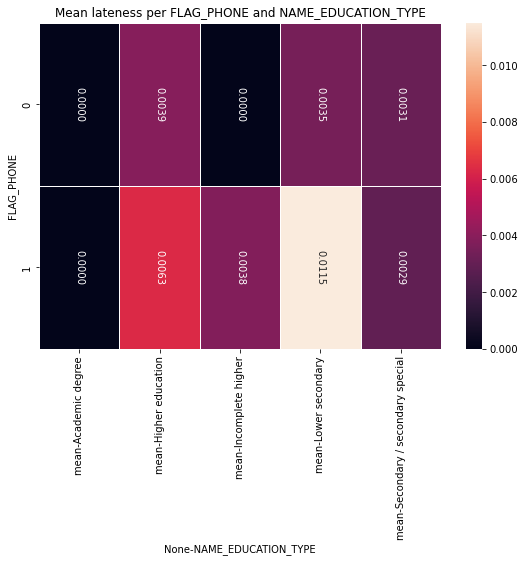

mean                                           \
NAME_FAMILY_STATUS Civil marriage   Married Separated Single / not married   
FLAG_PHONE                                                                   
0                        0.000464  0.003152  0.003521             0.005244   
1                        0.000000  0.003948  0.008785             0.004146   

                                      count                    \
NAME_FAMILY_STATUS     Widow Civil marriage Married Separated   
FLAG_PHONE                                                      
0                   0.002825           2155   17449      1420   
1                   0.004255            790    7599       683   

                                               
NAME_FAMILY_STATUS Single / not married Widow  
FLAG_PHONE                                     
0                                  3623  1062  
1                                  1206   470

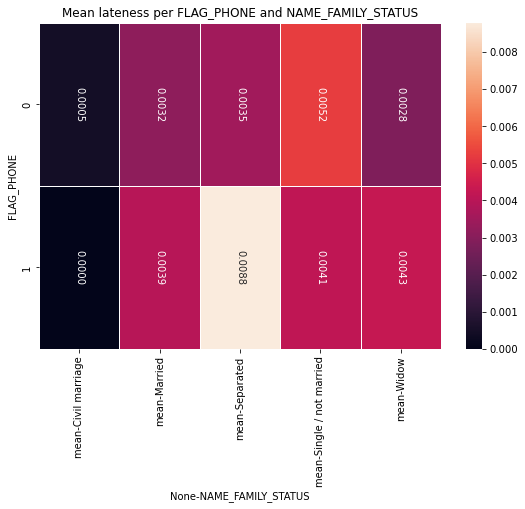

mean                                        \
NAME_HOUSING_TYPE Co-op apartment House / apartment Municipal apartment   
FLAG_PHONE                                                                
0                        0.015152          0.003022            0.006361   
1                        0.000000          0.004324            0.002924   

                                                                  \
NAME_HOUSING_TYPE Office apartment Rented apartment With parents   
FLAG_PHONE                                                         
0                         0.004831         0.004211     0.003137   
1                         0.000000         0.000000     0.000000   

                            count                                        \
NAME_HOUSING_TYPE Co-op apartment House / apartment Municipal apartment   
FLAG_PHONE                                                                
0                             132             22834                 786   
1                              36              9714                 342   

                                                                  
NAME_HOUSING_TYPE Office apartment Rented apartment With parents  
FLAG_PHONE                                                        
0                              207              475         1275  
1                               55              100          501

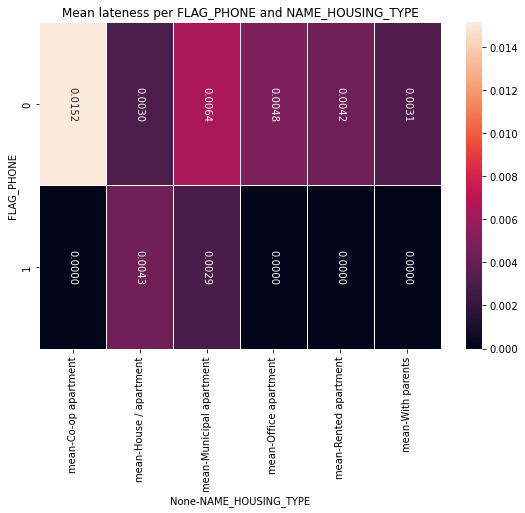

mean            count      
FLAG_WORK_PHONE         0         1      0     1
FLAG_PHONE                                      
0                0.003443  0.001927  22076  3633
1                0.003734  0.004358   6159  4589

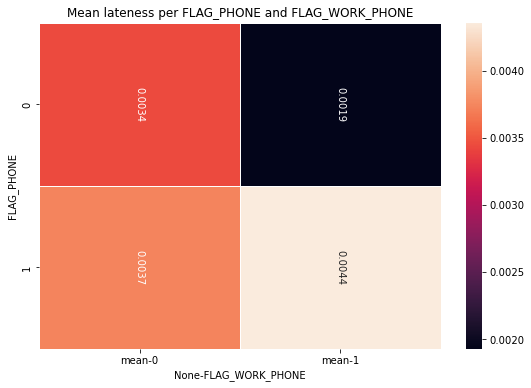

mean            count      
FLAG_EMAIL         0         1      0     1
FLAG_PHONE                                 
0           0.003241  0.003101  23452  2257
1           0.003596  0.007890   9734  1014

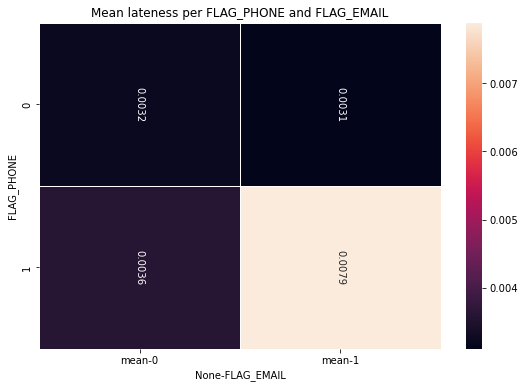

mean                                                    \
OCCUPATION_TYPE Accountants Cleaning staff Cooking staff Core staff   Drivers   
FLAG_PHONE                                                                      
0                  0.002516       0.002439      0.004107   0.003623  0.001321   
1                  0.000000       0.000000      0.011905   0.008130  0.004808   

                                                                    \
OCCUPATION_TYPE HR staff High skill tech staff  IT staff  Laborers   
FLAG_PHONE                                                           
0                    0.0              0.004540  0.068182  0.003495   
1                    0.0              0.003984  0.000000  0.003062   

                                                             \
OCCUPATION_TYPE Low-skill Laborers  Managers Medicine staff   
FLAG_PHONE                                                    
0                         0.000000  0.004735       0.001136   
1                         0.036364  0.004444       0.009174   

                                                                             \
OCCUPATION_TYPE Private service staff Realty agents Sales staff Secretaries   
FLAG_PHONE                                                                    
0                                 0.0           0.0    0.001652         0.0   
1                                 0.0           0.0    0.000940         0.0   

                                                          count  \
OCCUPATION_TYPE Security staff Waiters/barmen staff Accountants   
FLAG_PHONE                                                        
0                     0.012739             0.007812         795   
1                     0.000000             0.000000         446   

                                                                          \
OCCUPATION_TYPE Cleaning staff Cooking staff Core staff Drivers HR staff   
FLAG_PHONE                                                                 
0                          410           487       2484    1514       70   
1                          141           168       1107     624       15   

                                                                            \
OCCUPATION_TYPE High skill tech staff IT staff Laborers Low-skill Laborers   
FLAG_PHONE                                                                   
0                                 881       44     4578                120   
1                                 502       16     1633                 55   

                                                                             \
OCCUPATION_TYPE Managers Medicine staff Private service staff Realty agents   
FLAG_PHONE                                                                    
0                   2112            880                   225            52   
1                    900            327                   119            27   

                                                                             
OCCUPATION_TYPE Sales staff Secretaries Security staff Waiters/barmen staff  
FLAG_PHONE                                                                   
0                      2421         103            471                  128  
1                      1064          48            121                   46

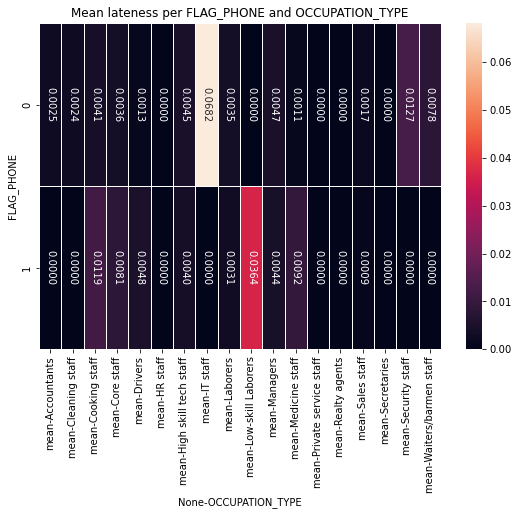

mean                                                    \
CNT_FAM_MEMBERS      1.0       2.0       3.0       4.0  5.0  6.0  7.0  9.0    
FLAG_PHONE                                                                    
0                0.003395  0.003910  0.002174  0.001376  0.0  0.0  0.0  NaN   
1                0.004548  0.003217  0.006590  0.003243  0.0  0.0  NaN  0.0   

                            count                                              \
CNT_FAM_MEMBERS 15.0 20.0    1.0      2.0     3.0     4.0    5.0   6.0   7.0    
FLAG_PHONE                                                                      
0                0.0  NaN  5008.0  13556.0  4600.0  2181.0  290.0  52.0  19.0   
1                NaN  0.0  1979.0   5907.0  1821.0   925.0  107.0   6.0   NaN   

                                
CNT_FAM_MEMBERS 9.0  15.0 20.0  
FLAG_PHONE                      
0                NaN  3.0  NaN  
1                2.0  NaN  1.0

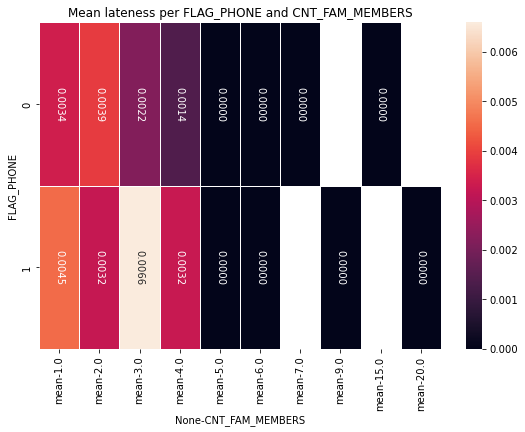

In [39]:
### 10. Heatmap relation comparison of late ratios vs feature pairs (FLAG PHONE vs ALL)
import seaborn as sns

features_cat=['CODE_GENDER','FLAG_OWN_CAR','FLAG_OWN_REALTY', 'CNT_CHILDREN', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',  'NAME_FAMILY_STATUS',
'NAME_HOUSING_TYPE', 'FLAG_WORK_PHONE', 'FLAG_EMAIL', 'OCCUPATION_TYPE', 'CNT_FAM_MEMBERS']

for el in features_cat:
    display(pd.pivot_table(app_and_credit_label_2,index='FLAG_PHONE',columns=el,values='all_late_flag',aggfunc=['mean','count']))
    temp_table=pd.pivot_table(app_and_credit_label_2,index='FLAG_PHONE',columns=el,values='all_late_flag',aggfunc=['mean'])
    f, ax = plt.subplots(figsize=(9, 6))
    plt.title('Mean lateness per {} and {}'.format('FLAG_PHONE', el))
    sns.heatmap(temp_table, fmt='.4f',annot=True, linewidths=.5, ax=ax,annot_kws={'rotation': -90})
    plt.show()

mean            count       
CODE_GENDER        F         M      F      M
FLAG_EMAIL                                  
0            0.00288  0.004287  22222  10964
1            0.00317  0.007526   2208   1063

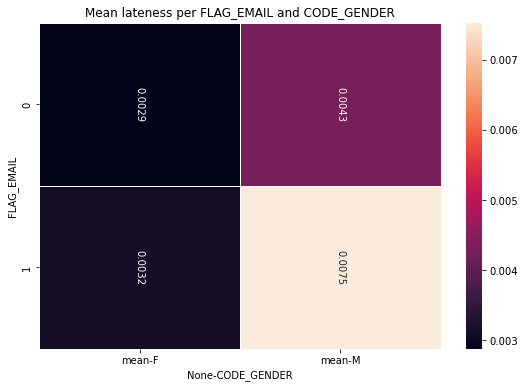

mean            count       
FLAG_OWN_CAR         N         Y      N      Y
FLAG_EMAIL                                    
0             0.002948  0.004003  20695  12491
1             0.004690  0.004438   1919   1352

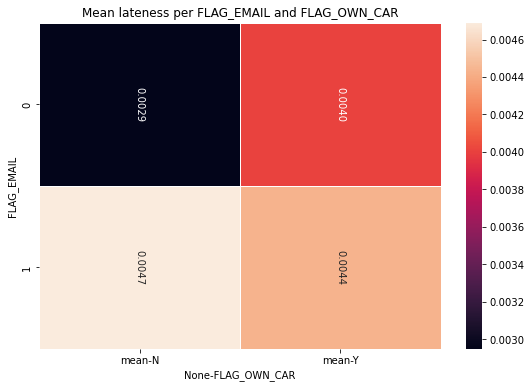

mean            count       
FLAG_OWN_REALTY         N         Y      N      Y
FLAG_EMAIL                                       
0                0.003503  0.003265  11134  22052
1                0.004896  0.004482    817   2454

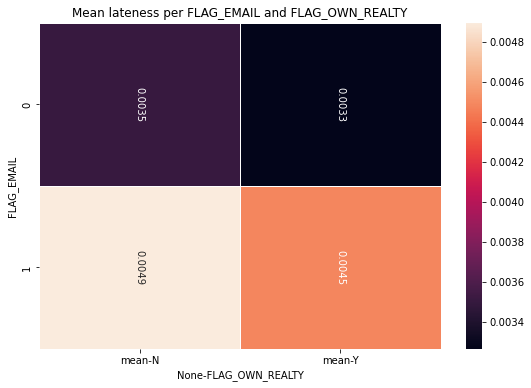

mean                                                    \
CNT_CHILDREN        0         1         2    3    4    5    7    14   19   
FLAG_EMAIL                                                                 
0             0.003594  0.003308  0.002017  0.0  0.0  0.0  0.0  0.0  0.0   
1             0.003799  0.008314  0.000000  0.0  0.0  NaN  NaN  NaN  NaN   

                count                                                    
CNT_CHILDREN       0       1       2      3     4     5    7    14   19  
FLAG_EMAIL                                                               
0             23095.0  6650.0  2975.0  378.0  62.0  20.0  2.0  3.0  1.0  
1              2106.0   842.0   281.0   41.0   1.0   NaN  NaN  NaN  NaN

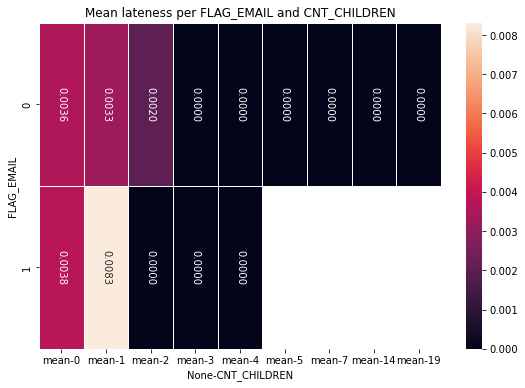

mean                                  \
NAME_INCOME_TYPE Commercial associate Pensioner State servant Student   
FLAG_EMAIL                                                              
0                            0.005131  0.003707      0.001116     0.0   
1                            0.003690  0.022936      0.000000     0.0   

                                          count                          \
NAME_INCOME_TYPE   Working Commercial associate Pensioner State servant   
FLAG_EMAIL                                                                
0                 0.002798                 7406      5934          2688   
1                 0.003608                 1084       218           297   

                                  
NAME_INCOME_TYPE Student Working  
FLAG_EMAIL                        
0                      2   17156  
1                      9    1663

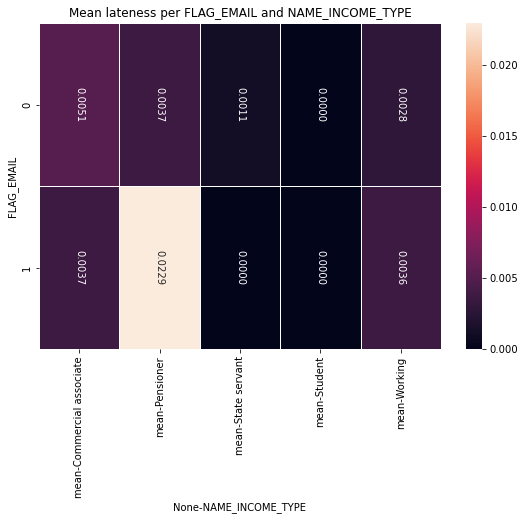

mean                                     \
NAME_EDUCATION_TYPE Academic degree Higher education Incomplete higher   
FLAG_EMAIL                                                               
0                               0.0         0.004452            0.0016   
1                               NaN         0.006024            0.0000   

                                                                   \
NAME_EDUCATION_TYPE Lower secondary Secondary / secondary special   
FLAG_EMAIL                                                          
0                          0.005731                      0.002998   
1                          0.000000                      0.003982   

                              count                                     \
NAME_EDUCATION_TYPE Academic degree Higher education Incomplete higher   
FLAG_EMAIL                                                               
0                              32.0           8536.0            1250.0   
1                               NaN           1328.0             160.0   

                                                                   
NAME_EDUCATION_TYPE Lower secondary Secondary / secondary special  
FLAG_EMAIL                                                         
0                             349.0                       23019.0  
1                              25.0                        1758.0

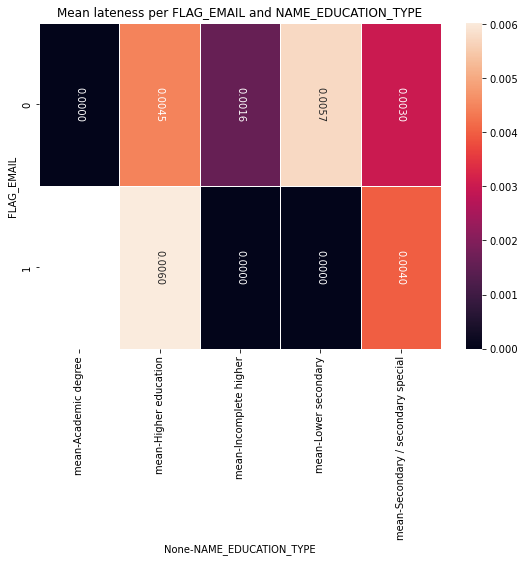

mean                                           \
NAME_FAMILY_STATUS Civil marriage   Married Separated Single / not married   
FLAG_EMAIL                                                                   
0                        0.000381  0.003109   0.00567             0.005293   
1                        0.000000  0.006341   0.00000             0.002066   

                                      count                    \
NAME_FAMILY_STATUS     Widow Civil marriage Married Separated   
FLAG_EMAIL                                                      
0                   0.003479           2624   22840      1940   
1                   0.000000            321    2208       163   

                                               
NAME_FAMILY_STATUS Single / not married Widow  
FLAG_EMAIL                                     
0                                  4345  1437  
1                                   484    95

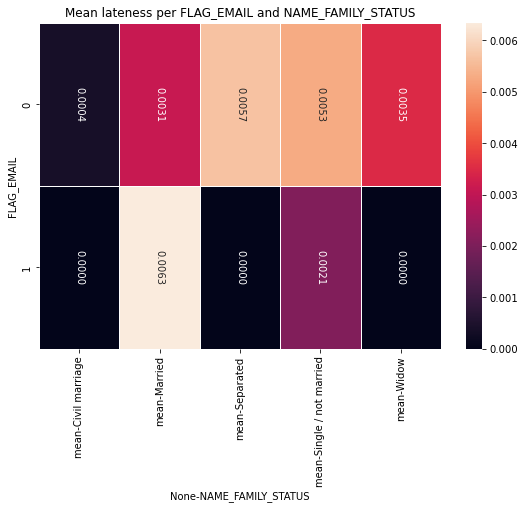

mean                                        \
NAME_HOUSING_TYPE Co-op apartment House / apartment Municipal apartment   
FLAG_EMAIL                                                                
0                        0.011976          0.003273            0.005803   
1                        0.000000          0.004809            0.000000   

                                                                  \
NAME_HOUSING_TYPE Office apartment Rented apartment With parents   
FLAG_EMAIL                                                         
0                            0.004         0.004008     0.001876   
1                            0.000         0.000000     0.005650   

                            count                                        \
NAME_HOUSING_TYPE Co-op apartment House / apartment Municipal apartment   
FLAG_EMAIL                                                                
0                             167             29637                1034   
1                               1              2911                  94   

                                                                  
NAME_HOUSING_TYPE Office apartment Rented apartment With parents  
FLAG_EMAIL                                                        
0                              250              499         1599  
1                               12               76          177

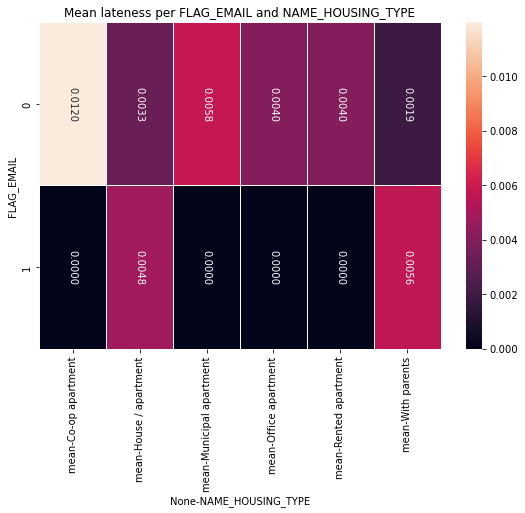

mean            count      
FLAG_WORK_PHONE         0         1      0     1
FLAG_EMAIL                                      
0                0.003288  0.003536  25550  7636
1                0.005587  0.000000   2685   586

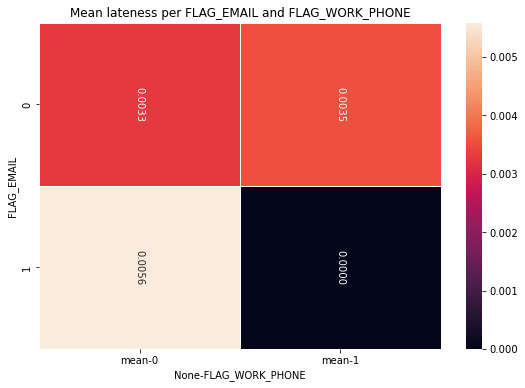

mean                                                    \
OCCUPATION_TYPE Accountants Cleaning staff Cooking staff Core staff   Drivers   
FLAG_EMAIL                                                                      
0                  0.001852       0.001905      0.006568   0.004200  0.002546   
1                  0.000000       0.000000      0.000000   0.010081  0.000000   

                                                                    \
OCCUPATION_TYPE HR staff High skill tech staff  IT staff  Laborers   
FLAG_EMAIL                                                           
0                    0.0              0.004946  0.000000  0.003475   
1                    0.0              0.000000  0.157895  0.002198   

                                                             \
OCCUPATION_TYPE Low-skill Laborers  Managers Medicine staff   
FLAG_EMAIL                                                    
0                         0.011976  0.005285       0.001854   
1                         0.000000  0.000000       0.015625   

                                                                             \
OCCUPATION_TYPE Private service staff Realty agents Sales staff Secretaries   
FLAG_EMAIL                                                                    
0                                 0.0           0.0     0.00158         0.0   
1                                 0.0           0.0     0.00000         0.0   

                                                          count  \
OCCUPATION_TYPE Security staff Waiters/barmen staff Accountants   
FLAG_EMAIL                                                        
0                     0.011342             0.000000        1080   
1                     0.000000             0.083333         161   

                                                                          \
OCCUPATION_TYPE Cleaning staff Cooking staff Core staff Drivers HR staff   
FLAG_EMAIL                                                                 
0                          525           609       3095    1964       71   
1                           26            46        496     174       14   

                                                                            \
OCCUPATION_TYPE High skill tech staff IT staff Laborers Low-skill Laborers   
FLAG_EMAIL                                                                   
0                                1213       41     5756                167   
1                                 170       19      455                  8   

                                                                             \
OCCUPATION_TYPE Managers Medicine staff Private service staff Realty agents   
FLAG_EMAIL                                                                    
0                   2649           1079                   295            70   
1                    363            128                    49             9   

                                                                             
OCCUPATION_TYPE Sales staff Secretaries Security staff Waiters/barmen staff  
FLAG_EMAIL                                                                   
0                      3165         134            529                  162  
1                       320          17             63                   12

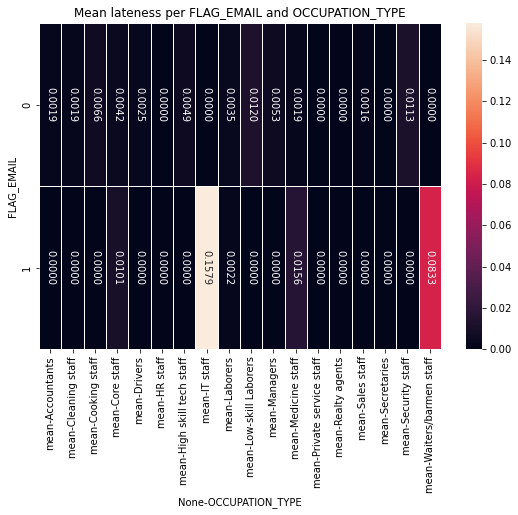

mean                                                    \
CNT_FAM_MEMBERS      1.0       2.0       3.0       4.0  5.0  6.0  7.0  9.0    
FLAG_EMAIL                                                                    
0                0.003918  0.003588  0.002812  0.002114  0.0  0.0  0.0  0.0   
1                0.001650  0.004926  0.008208  0.000000  0.0  0.0  NaN  NaN   

                            count                                              \
CNT_FAM_MEMBERS 15.0 20.0    1.0      2.0     3.0     4.0    5.0   6.0   7.0    
FLAG_EMAIL                                                                      
0                0.0  0.0  6381.0  17839.0  5690.0  2838.0  356.0  57.0  19.0   
1                NaN  NaN   606.0   1624.0   731.0   268.0   41.0   1.0   NaN   

                                
CNT_FAM_MEMBERS 9.0  15.0 20.0  
FLAG_EMAIL                      
0                2.0  3.0  1.0  
1                NaN  NaN  NaN

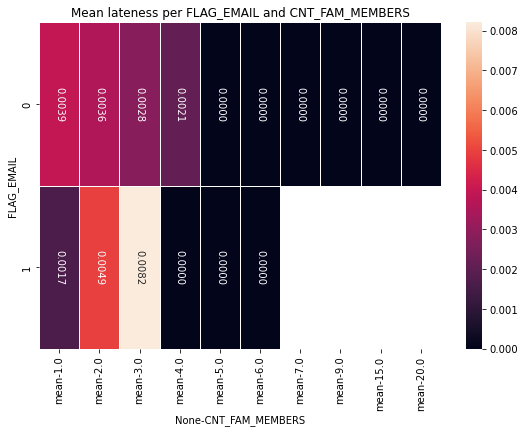

In [40]:
### 11. Heatmap relation comparison of late ratios vs feature pairs (FLAG_EMAIL vs ALL)
L1_features=['FLAG_PHONE', 'FLAG_EMAIL', 'OCCUPATION_TYPE', 'CNT_FAM_MEMBERS']

features_cat=['CODE_GENDER','FLAG_OWN_CAR','FLAG_OWN_REALTY', 'CNT_CHILDREN', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',  'NAME_FAMILY_STATUS',
'NAME_HOUSING_TYPE', 'FLAG_WORK_PHONE', 'OCCUPATION_TYPE', 'CNT_FAM_MEMBERS']

for el in features_cat:
    display(pd.pivot_table(app_and_credit_label_2,index='FLAG_EMAIL',columns=el,values='all_late_flag',aggfunc=['mean','count']))
    temp_table=pd.pivot_table(app_and_credit_label_2,index='FLAG_EMAIL',columns=el,values='all_late_flag',aggfunc=['mean'])
    f, ax = plt.subplots(figsize=(9, 6))
    plt.title('Mean lateness per {} and {}'.format('FLAG_EMAIL', el))
    sns.heatmap(temp_table, fmt='.4f',annot=True, linewidths=.5, ax=ax,annot_kws={'rotation': -90})
    plt.show()

mean           count      
CODE_GENDER                   F         M     F     M
OCCUPATION_TYPE                                      
Accountants            0.001663  0.000000  1203    38
Cleaning staff         0.001883  0.000000   531    20
Cooking staff          0.005245  0.012048   572    83
Core staff             0.003481  0.011142  2873   718
Drivers                0.000000  0.002495   134  2004
HR staff               0.000000  0.000000    78     7
High skill tech staff  0.004167  0.004728   960   423
IT staff               0.111111  0.000000    27    33
Laborers               0.001531  0.004724  2612  3599
Low-skill Laborers     0.054054  0.000000    37   138
Managers               0.003169  0.006276  1578  1434
Medicine staff         0.003439  0.000000  1163    44
Private service staff  0.000000  0.000000   320    24
Realty agents          0.000000  0.000000    69    10
Sales staff            0.001662  0.000000  3008   477
Secretaries            0.000000  0.000000   146     5
Security staff         0.005747  0.011962   174   418
Waiters/barmen staff   0.006897  0.000000   145    29

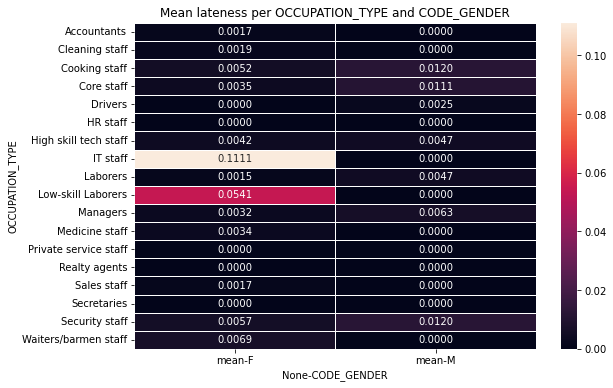

mean           count      
FLAG_OWN_CAR                  N         Y     N     Y
OCCUPATION_TYPE                                      
Accountants            0.001377  0.001942   726   515
Cleaning staff         0.002066  0.000000   484    67
Cooking staff          0.003945  0.013514   507   148
Core staff             0.004861  0.005271  2263  1328
Drivers                0.000000  0.003143   547  1591
HR staff               0.000000  0.000000    53    32
High skill tech staff  0.006345  0.001681   788   595
IT staff               0.090909  0.000000    33    27
Laborers               0.001928  0.005426  3631  2580
Low-skill Laborers     0.014925  0.000000   134    41
Managers               0.003846  0.005257  1300  1712
Medicine staff         0.003421  0.003030   877   330
Private service staff  0.000000  0.000000   237   107
Realty agents          0.000000  0.000000    53    26
Sales staff            0.000859  0.002591  2327  1158
Secretaries            0.000000  0.000000   124    27
Security staff         0.012953  0.004854   386   206
Waiters/barmen staff   0.006757  0.000000   148    26

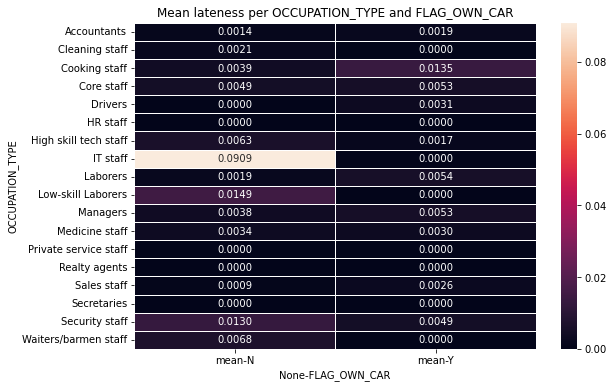

mean           count      
FLAG_OWN_REALTY               N         Y     N     Y
OCCUPATION_TYPE                                      
Accountants            0.000000  0.002535   452   789
Cleaning staff         0.000000  0.002469   146   405
Cooking staff          0.000000  0.009324   226   429
Core staff             0.004890  0.005076  1227  2364
Drivers                0.002448  0.002271   817  1321
HR staff               0.000000  0.000000    49    36
High skill tech staff  0.004386  0.004315   456   927
IT staff               0.000000  0.090909    27    33
Laborers               0.005007  0.002491  2197  4014
Low-skill Laborers     0.000000  0.017544    61   114
Managers               0.002053  0.005888   974  2038
Medicine staff         0.002364  0.003827   423   784
Private service staff  0.000000  0.000000    90   254
Realty agents          0.000000  0.000000    18    61
Sales staff            0.001661  0.001315  1204  2281
Secretaries            0.000000  0.000000    55    96
Security staff         0.009804  0.010309   204   388
Waiters/barmen staff   0.000000  0.007874    47   127

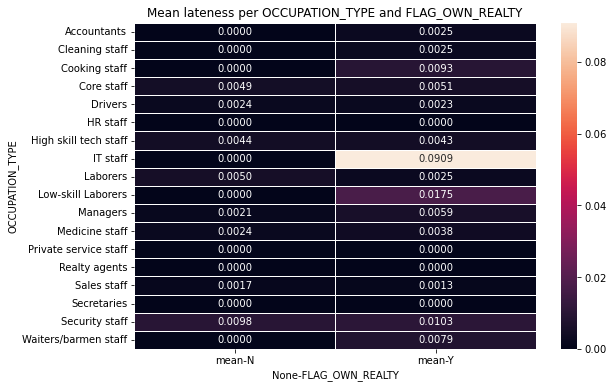

mean                                               \
CNT_CHILDREN                 0         1         2    3    4    5    7    14   
OCCUPATION_TYPE                                                                
Accountants            0.001252  0.003012  0.000000  0.0  0.0  NaN  NaN  NaN   
Cleaning staff         0.002463  0.000000  0.000000  0.0  NaN  NaN  0.0  NaN   
Cooking staff          0.008696  0.000000  0.000000  0.0  NaN  NaN  NaN  NaN   
Core staff             0.005233  0.007392  0.000000  0.0  0.0  NaN  NaN  NaN   
Drivers                0.002257  0.003683  0.000000  0.0  NaN  NaN  NaN  0.0   
HR staff               0.000000  0.000000  0.000000  NaN  NaN  NaN  NaN  NaN   
High skill tech staff  0.005721  0.000000  0.005236  0.0  0.0  NaN  NaN  NaN   
IT staff               0.069767  0.000000  0.000000  NaN  NaN  NaN  NaN  NaN   
Laborers               0.003422  0.004573  0.001416  0.0  0.0  0.0  NaN  NaN   
Low-skill Laborers     0.000000  0.054054  0.000000  NaN  NaN  NaN  NaN  NaN   
Managers               0.004452  0.004700  0.006250  0.0  0.0  0.0  NaN  NaN   
Medicine staff         0.004756  0.000000  0.000000  0.0  0.0  NaN  NaN  NaN   
Private service staff  0.000000  0.000000  0.000000  NaN  NaN  NaN  NaN  NaN   
Realty agents          0.000000  0.000000  0.000000  NaN  NaN  NaN  NaN  NaN   
Sales staff            0.000951  0.002043  0.002793  0.0  0.0  NaN  NaN  NaN   
Secretaries            0.000000  0.000000  0.000000  NaN  NaN  NaN  NaN  NaN   
Security staff         0.011442  0.010870  0.000000  NaN  0.0  NaN  NaN  NaN   
Waiters/barmen staff   0.000000  0.016949  0.000000  0.0  NaN  NaN  NaN  NaN   

                             count                                             \
CNT_CHILDREN            19      0       1      2     3     4     5    7    14   
OCCUPATION_TYPE                                                                 
Accountants            NaN   799.0   332.0   89.0  20.0   1.0   NaN  NaN  NaN   
Cleaning staff         NaN   406.0    93.0   45.0   5.0   NaN   NaN  2.0  NaN   
Cooking staff          NaN   460.0   144.0   48.0   3.0   NaN   NaN  NaN  NaN   
Core staff             NaN  2102.0   947.0  451.0  64.0  27.0   NaN  NaN  NaN   
Drivers                NaN  1329.0   543.0  240.0  23.0   NaN   NaN  NaN  3.0   
HR staff               NaN    59.0    14.0   12.0   NaN   NaN   NaN  NaN  NaN   
High skill tech staff  NaN   874.0   295.0  191.0  21.0   2.0   NaN  NaN  NaN   
IT staff               NaN    43.0    12.0    5.0   NaN   NaN   NaN  NaN  NaN   
Laborers               NaN  4091.0  1312.0  706.0  89.0   3.0  10.0  NaN  NaN   
Low-skill Laborers     NaN   118.0    37.0   20.0   NaN   NaN   NaN  NaN  NaN   
Managers               NaN  1797.0   851.0  320.0  27.0   9.0   8.0  NaN  NaN   
Medicine staff         NaN   841.0   222.0  128.0  12.0   4.0   NaN  NaN  NaN   
Private service staff  NaN   209.0   109.0   26.0   NaN   NaN   NaN  NaN  NaN   
Realty agents          NaN    42.0    34.0    3.0   NaN   NaN   NaN  NaN  NaN   
Sales staff            NaN  2104.0   979.0  358.0  43.0   1.0   NaN  NaN  NaN   
Secretaries            NaN    89.0    43.0   19.0   NaN   NaN   NaN  NaN  NaN   
Security staff         NaN   437.0    92.0   53.0   NaN  10.0   NaN  NaN  NaN   
Waiters/barmen staff   0.0   108.0    59.0    1.0   5.0   NaN   NaN  NaN  NaN   

                            
CNT_CHILDREN            19  
OCCUPATION_TYPE             
Accountants            NaN  
Cleaning staff         NaN  
Cooking staff          NaN  
Core staff             NaN  
Drivers                NaN  
HR staff               NaN  
High skill tech staff  NaN  
IT staff               NaN  
Laborers               NaN  
Low-skill Laborers     NaN  
Managers               NaN  
Medicine staff         NaN  
Private service staff  NaN  
Realty agents          NaN  
Sales staff            NaN  
Secretaries            NaN  
Security staff         NaN  
Waiters/barmen staff   1.0

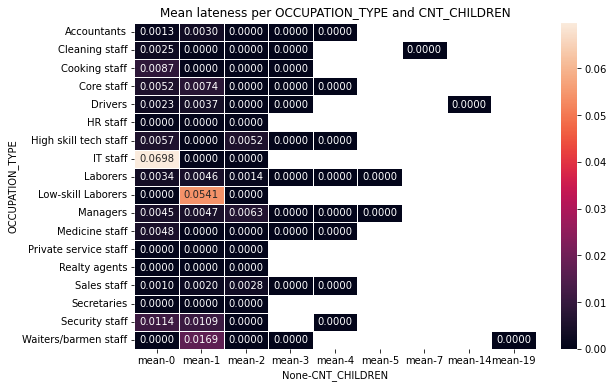

mean                                  \
NAME_INCOME_TYPE      Commercial associate Pensioner State servant Student   
OCCUPATION_TYPE                                                              
Accountants                       0.004090       0.0      0.000000     NaN   
Cleaning staff                    0.000000       NaN      0.000000     NaN   
Cooking staff                     0.008000       NaN      0.000000     NaN   
Core staff                        0.004938       0.6      0.001111     0.0   
Drivers                           0.001792       0.0      0.008403     NaN   
HR staff                          0.000000       NaN      0.000000     NaN   
High skill tech staff             0.004963       NaN      0.000000     NaN   
IT staff                          0.000000       NaN      0.000000     NaN   
Laborers                          0.002738       0.0      0.000000     0.0   
Low-skill Laborers                0.022222       1.0      0.000000     NaN   
Managers                          0.006832       0.0      0.000000     NaN   
Medicine staff                    0.017647       1.0      0.000000     NaN   
Private service staff             0.000000       NaN      0.000000     NaN   
Realty agents                     0.000000       NaN           NaN     NaN   
Sales staff                       0.001678       NaN      0.000000     NaN   
Secretaries                       0.000000       NaN      0.000000     NaN   
Security staff                    0.020725       NaN      0.000000     NaN   
Waiters/barmen staff              0.020408       NaN      0.000000     NaN   

                                               count                          \
NAME_INCOME_TYPE        Working Commercial associate Pensioner State servant   
OCCUPATION_TYPE                                                                
Accountants            0.000000                489.0       1.0          92.0   
Cleaning staff         0.002353                107.0       NaN          19.0   
Cooking staff          0.006424                125.0       NaN          63.0   
Core staff             0.005353                810.0       5.0         900.0   
Drivers                0.002055                558.0       1.0         119.0   
HR staff               0.000000                 28.0       NaN           3.0   
High skill tech staff  0.005128                403.0       NaN         200.0   
IT staff               0.107143                 22.0       NaN          10.0   
Laborers               0.003734               1461.0       3.0         192.0   
Low-skill Laborers     0.000000                 45.0       1.0           3.0   
Managers               0.003906               1171.0       1.0         304.0   
Medicine staff         0.000000                170.0       1.0         400.0   
Private service staff  0.000000                147.0       NaN          20.0   
Realty agents          0.000000                 56.0       NaN           NaN   
Sales staff            0.001315               1192.0       NaN          12.0   
Secretaries            0.000000                 26.0       NaN          35.0   
Security staff         0.005291                193.0       NaN          21.0   
Waiters/barmen staff   0.000000                 49.0       NaN          44.0   

                                       
NAME_INCOME_TYPE      Student Working  
OCCUPATION_TYPE                        
Accountants               NaN   659.0  
Cleaning staff            NaN   425.0  
Cooking staff             NaN   467.0  
Core staff                8.0  1868.0  
Drivers                   NaN  1460.0  
HR staff                  NaN    54.0  
High skill tech staff     NaN   780.0  
IT staff                  NaN    28.0  
Laborers                  2.0  4553.0  
Low-skill Laborers        NaN   126.0  
Managers                  NaN  1536.0  
Medicine staff            NaN   636.0  
Private service staff     NaN   177.0  
Realty agents             NaN    23.0  
Sales staff               NaN  2281.0 

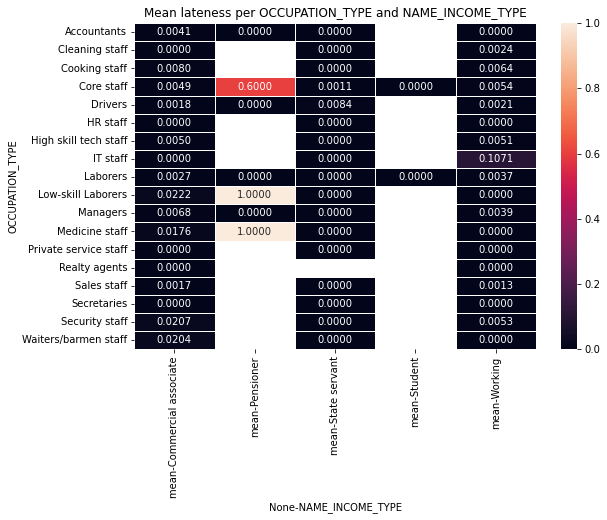

mean                                     \
NAME_EDUCATION_TYPE   Academic degree Higher education Incomplete higher   
OCCUPATION_TYPE                                                            
Accountants                       NaN         0.001372          0.000000   
Cleaning staff                    NaN         0.000000          0.000000   
Cooking staff                     NaN         0.000000          0.000000   
Core staff                        NaN         0.003652          0.004762   
Drivers                           NaN         0.003333          0.000000   
HR staff                          NaN         0.000000               NaN   
High skill tech staff             NaN         0.000000          0.027027   
IT staff                          NaN         0.000000          0.000000   
Laborers                          NaN         0.003375          0.000000   
Low-skill Laborers                NaN         0.000000          0.000000   
Managers                          0.0         0.005303          0.000000   
Medicine staff                    NaN         0.012500          0.000000   
Private service staff             NaN         0.000000          0.000000   
Realty agents                     NaN         0.000000          0.000000   
Sales staff                       0.0         0.003861          0.000000   
Secretaries                       NaN         0.000000          0.000000   
Security staff                    NaN         0.040541          0.000000   
Waiters/barmen staff              NaN         0.043478          0.000000   

                                                                     \
NAME_EDUCATION_TYPE   Lower secondary Secondary / secondary special   
OCCUPATION_TYPE                                                       
Accountants                  0.000000                      0.002283   
Cleaning staff               0.090909                      0.000000   
Cooking staff                0.000000                      0.006745   
Core staff                   0.000000                      0.006369   
Drivers                      0.000000                      0.002294   
HR staff                          NaN                      0.000000   
High skill tech staff        0.083333                      0.004785   
IT staff                          NaN                      0.187500   
Laborers                     0.000000                      0.003589   
Low-skill Laborers           0.000000                      0.012500   
Managers                     0.000000                      0.004359   
Medicine staff               0.000000                      0.001980   
Private service staff             NaN                      0.000000   
Realty agents                     NaN                      0.000000   
Sales staff                  0.000000                      0.000790   
Secretaries                       NaN                      0.000000   
Security staff                    NaN                      0.005976   
Waiters/barmen staff              NaN                      0.000000   

                                count                                     \
NAME_EDUCATION_TYPE   Academic degree Higher education Incomplete higher   
OCCUPATION_TYPE                                                            
Accountants                       NaN            729.0              72.0   
Cleaning staff                    NaN             34.0               2.0   
Cooking staff                     NaN             51.0               8.0   
Core staff                        NaN           1643.0             210.0   
Drivers                           NaN            300.0              84.0   
HR staff                          NaN             47.0               NaN   
High skill tech staff             NaN            498.0              37.0   
IT staff                          NaN             41.0               3.0   
Laborers                          NaN            889.0             221.0   
Low-skill Laborers              

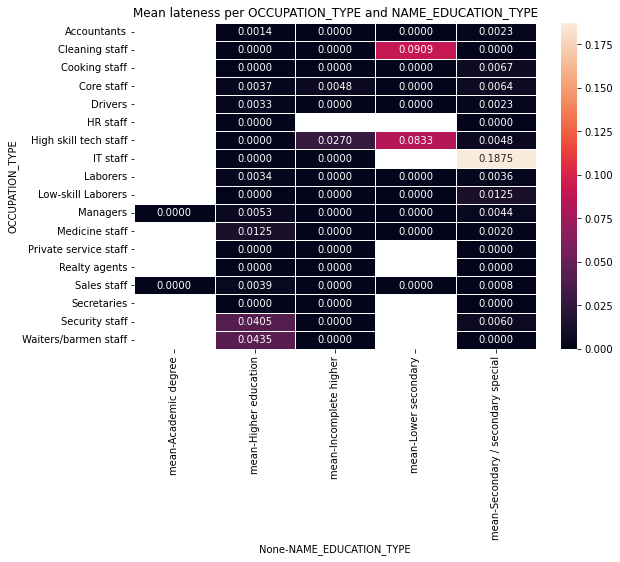

mean                                           \
NAME_FAMILY_STATUS    Civil marriage   Married Separated Single / not married   
OCCUPATION_TYPE                                                                 
Accountants                      0.0  0.002378  0.000000             0.000000   
Cleaning staff                   0.0  0.000000  0.000000             0.011628   
Cooking staff                    0.0  0.007500  0.000000             0.011111   
Core staff                       0.0  0.004908  0.013453             0.003630   
Drivers                          0.0  0.002402  0.000000             0.003984   
HR staff                         0.0  0.000000  0.000000             0.000000   
High skill tech staff            0.0  0.004859  0.000000             0.004808   
IT staff                         0.0  0.071429  0.000000             0.000000   
Laborers                         0.0  0.003475  0.002725             0.005280   
Low-skill Laborers               0.0  0.000000  0.000000             0.111111   
Managers                         0.0  0.003423  0.000000             0.017986   
Medicine staff                   0.0  0.003525  0.011364             0.000000   
Private service staff            0.0  0.000000  0.000000             0.000000   
Realty agents                    0.0  0.000000       NaN             0.000000   
Sales staff                      0.0  0.000865  0.004785             0.004310   
Secretaries                      0.0  0.000000       NaN             0.000000   
Security staff                   0.0  0.009685  0.000000             0.016393   
Waiters/barmen staff             0.0  0.011905  0.000000             0.000000   

                                         count                    \
NAME_FAMILY_STATUS        Widow Civil marriage Married Separated   
OCCUPATION_TYPE                                                    
Accountants            0.000000          102.0   841.0      90.0   
Cleaning staff         0.000000           42.0   294.0      71.0   
Cooking staff          0.000000          108.0   400.0      26.0   
Core staff             0.011765          287.0  2445.0     223.0   
Drivers                0.000000          151.0  1665.0      63.0   
HR staff               0.000000            3.0    44.0      13.0   
High skill tech staff  0.000000           73.0  1029.0      60.0   
IT staff                    NaN            3.0    42.0       9.0   
Laborers               0.000000          515.0  4317.0     367.0   
Low-skill Laborers          NaN           51.0   104.0       2.0   
Managers               0.014925          184.0  2337.0     146.0   
Medicine staff         0.000000           87.0   851.0      88.0   
Private service staff  0.000000           30.0   175.0      46.0   
Realty agents               NaN            8.0    66.0       NaN   
Sales staff            0.000000          399.0  2311.0     209.0   
Secretaries            0.000000           14.0    91.0       NaN   
Security staff         0.050000           53.0   413.0      45.0   
Waiters/barmen staff   0.000000           23.0    84.0       9.0   

                                                   
NAME_FAMILY_STATUS    Single / not married  Widow  
OCCUPATION_TYPE                                    
Accountants                          161.0   47.0  
Cleaning staff                        86.0   58.0  
Cooking staff                         90.0   31.0  
Core staff                           551.0   85.0  
Drivers                              251.0    8.0  
HR staff                               8.0   17.0  
High skill tech staff                208.0   13.0  
IT staff                               6.0    NaN  
Laborers                             947.0   65.0  
Low-skill Laborers                    18.0    NaN  
Managers                             278.0   67.0  
Medicine staff                       155.0   26.0  
Private service staff                 73.0   20.0  
Realty agents                          5.0    NaN  
Sales staff      

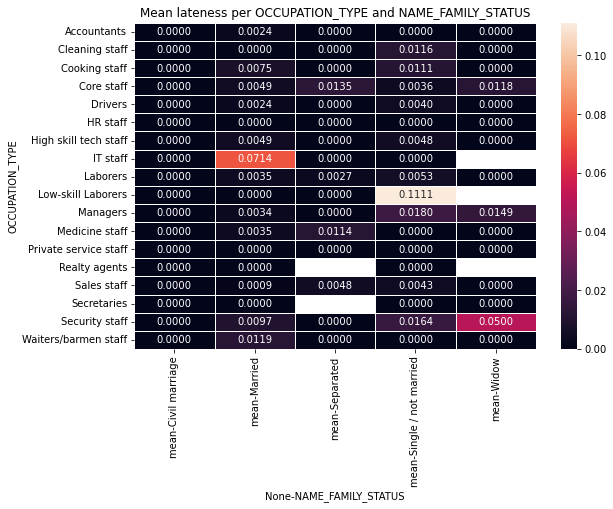

mean                                        \
NAME_HOUSING_TYPE     Co-op apartment House / apartment Municipal apartment   
OCCUPATION_TYPE                                                               
Accountants                  0.000000          0.001807            0.000000   
Cleaning staff                    NaN          0.000000            0.000000   
Cooking staff                0.000000          0.005455            0.028571   
Core staff                   0.090909          0.004806            0.017544   
Drivers                      0.000000          0.002682            0.000000   
HR staff                          NaN          0.000000                 NaN   
High skill tech staff        0.000000          0.004777            0.000000   
IT staff                          NaN          0.065217                 NaN   
Laborers                     0.028571          0.002982            0.000000   
Low-skill Laborers                NaN          0.012121            0.000000   
Managers                     0.000000          0.005069            0.000000   
Medicine staff               0.000000          0.003704            0.000000   
Private service staff             NaN          0.000000            0.000000   
Realty agents                     NaN          0.000000                 NaN   
Sales staff                  0.000000          0.001333            0.005181   
Secretaries                       NaN          0.000000            0.000000   
Security staff               0.000000          0.007576            0.033333   
Waiters/barmen staff              NaN          0.005848                 NaN   

                                                                      \
NAME_HOUSING_TYPE     Office apartment Rented apartment With parents   
OCCUPATION_TYPE                                                        
Accountants                        0.0         0.000000     0.000000   
Cleaning staff                     0.0         0.200000     0.000000   
Cooking staff                      0.0         0.000000     0.000000   
Core staff                         0.0         0.000000     0.000000   
Drivers                            0.0         0.000000     0.000000   
HR staff                           NaN              NaN     0.000000   
High skill tech staff              0.0         0.000000     0.000000   
IT staff                           NaN              NaN     0.000000   
Laborers                           0.0         0.004902     0.008547   
Low-skill Laborers                 0.0              NaN     0.000000   
Managers                           0.0         0.000000     0.000000   
Medicine staff                     0.0         0.000000     0.000000   
Private service staff              NaN              NaN     0.000000   
Realty agents                      NaN              NaN     0.000000   
Sales staff                        0.0         0.000000     0.000000   
Secretaries                        NaN              NaN     0.000000   
Security staff                     0.1         0.000000     0.000000   
Waiters/barmen staff               0.0              NaN     0.000000   

                                count                                        \
NAME_HOUSING_TYPE     Co-op apartment House / apartment Municipal apartment   
OCCUPATION_TYPE                                                               
Accountants                      24.0            1107.0                18.0   
Cleaning staff                    NaN             469.0                44.0   
Cooking staff                     2.0             550.0                35.0   
Core staff                       11.0            3121.0               114.0   
Drivers                           3.0            1864.0                34.0   
HR staff                          NaN              82.0                 NaN   
High skill tech staff             7.0            1256.0                24.0   
IT staff                          NaN              46.0               

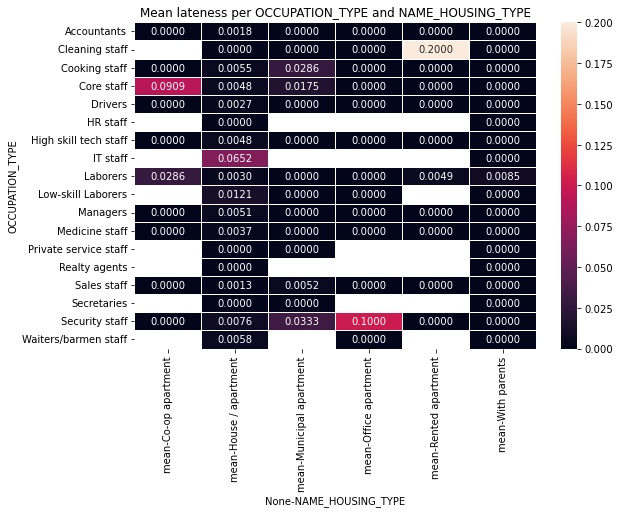

mean           count      
FLAG_WORK_PHONE               0         1     0     1
OCCUPATION_TYPE                                      
Accountants            0.001159  0.002646   863   378
Cleaning staff         0.002841  0.000000   352   199
Cooking staff          0.003810  0.015385   525   130
Core staff             0.006709  0.000946  2534  1057
Drivers                0.001308  0.004926  1529   609
HR staff               0.000000  0.000000    75    10
High skill tech staff  0.005015  0.002591   997   386
IT staff               0.056604  0.000000    53     7
Laborers               0.003928  0.001843  4583  1628
Low-skill Laborers     0.018018  0.000000   111    64
Managers               0.004176  0.005834  2155   857
Medicine staff         0.003286  0.003401   913   294
Private service staff  0.000000  0.000000   268    76
Realty agents          0.000000  0.000000    62    17
Sales staff            0.001170  0.002174  2565   920
Secretaries            0.000000  0.000000   110    41
Security staff         0.013363  0.000000   449   143
Waiters/barmen staff   0.009259  0.000000   108    66

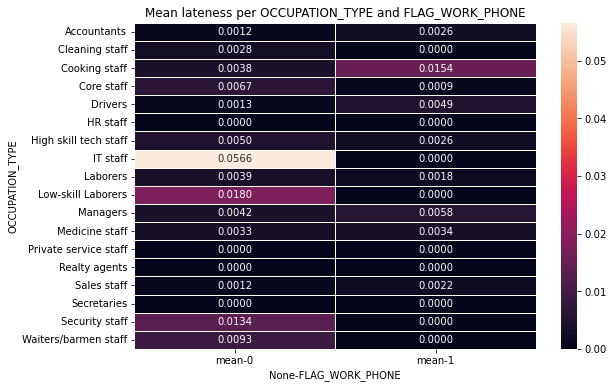

mean           count     
FLAG_EMAIL                    0         1     0    1
OCCUPATION_TYPE                                     
Accountants            0.001852  0.000000  1080  161
Cleaning staff         0.001905  0.000000   525   26
Cooking staff          0.006568  0.000000   609   46
Core staff             0.004200  0.010081  3095  496
Drivers                0.002546  0.000000  1964  174
HR staff               0.000000  0.000000    71   14
High skill tech staff  0.004946  0.000000  1213  170
IT staff               0.000000  0.157895    41   19
Laborers               0.003475  0.002198  5756  455
Low-skill Laborers     0.011976  0.000000   167    8
Managers               0.005285  0.000000  2649  363
Medicine staff         0.001854  0.015625  1079  128
Private service staff  0.000000  0.000000   295   49
Realty agents          0.000000  0.000000    70    9
Sales staff            0.001580  0.000000  3165  320
Secretaries            0.000000  0.000000   134   17
Security staff         0.011342  0.000000   529   63
Waiters/barmen staff   0.000000  0.083333   162   12

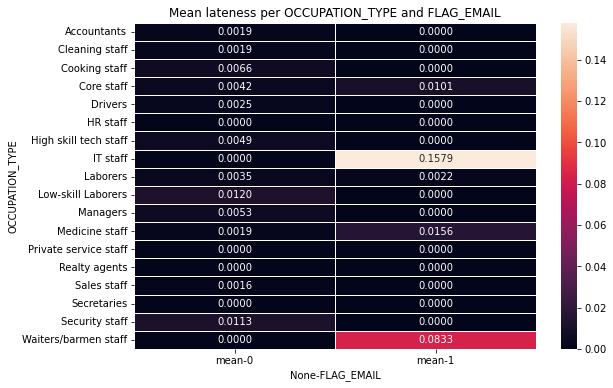

mean                                               \
CNT_FAM_MEMBERS            1.0       2.0       3.0       4.0  5.0  6.0  7.0    
OCCUPATION_TYPE                                                                
Accountants            0.000000  0.001479  0.004082  0.000000  0.0  0.0  NaN   
Cleaning staff         0.000000  0.004202  0.000000  0.000000  0.0  NaN  NaN   
Cooking staff          0.008772  0.008130  0.000000  0.000000  0.0  NaN  NaN   
Core staff             0.007587  0.004318  0.007585  0.000000  0.0  0.0  NaN   
Drivers                0.000000  0.002796  0.003891  0.000000  0.0  NaN  NaN   
HR staff               0.000000  0.000000  0.000000  0.000000  NaN  NaN  NaN   
High skill tech staff  0.004464  0.005698  0.000000  0.005376  0.0  0.0  NaN   
IT staff               0.000000  0.083333  0.000000  0.000000  NaN  NaN  NaN   
Laborers               0.002688  0.003771  0.004329  0.001517  0.0  0.0  0.0   
Low-skill Laborers     0.000000  0.000000  0.057143  0.000000  NaN  NaN  NaN   
Managers               0.008955  0.004397  0.002699  0.006579  0.0  0.0  0.0   
Medicine staff         0.004926  0.004298  0.000000  0.000000  0.0  0.0  NaN   
Private service staff  0.000000  0.000000  0.000000  0.000000  NaN  NaN  NaN   
Realty agents          0.000000  0.000000  0.000000  0.000000  NaN  NaN  NaN   
Sales staff            0.003295  0.000612  0.001147  0.003040  0.0  0.0  NaN   
Secretaries            0.000000  0.000000  0.000000  0.000000  NaN  NaN  NaN   
Security staff         0.010309  0.013889  0.000000  0.000000  0.0  0.0  NaN   
Waiters/barmen staff   0.000000  0.000000  0.043478  0.000000  0.0  NaN  NaN   

                                       count                               \
CNT_FAM_MEMBERS       9.0  15.0 20.0    1.0     2.0     3.0    4.0   5.0    
OCCUPATION_TYPE                                                             
Accountants            NaN  NaN  NaN   210.0   676.0   245.0   89.0  20.0   
Cleaning staff         0.0  NaN  NaN   190.0   238.0    72.0   44.0   5.0   
Cooking staff          NaN  NaN  NaN   114.0   369.0   128.0   43.0   1.0   
Core staff             NaN  NaN  NaN   659.0  1621.0   791.0  429.0  64.0   
Drivers                NaN  0.0  NaN   288.0  1073.0   514.0  238.0  22.0   
HR staff               NaN  NaN  NaN    29.0    39.0     5.0   12.0   NaN   
High skill tech staff  NaN  NaN  NaN   224.0   702.0   248.0  186.0  21.0   
IT staff               NaN  NaN  NaN    11.0    36.0     8.0    5.0   NaN   
Laborers               NaN  NaN  NaN  1116.0  3182.0  1155.0  659.0  86.0   
Low-skill Laborers     NaN  NaN  NaN    12.0   110.0    35.0   18.0   NaN   
Managers               NaN  NaN  NaN   335.0  1592.0   741.0  304.0  23.0   
Medicine staff         NaN  NaN  NaN   203.0   698.0   168.0  122.0  12.0   
Private service staff  NaN  NaN  NaN    96.0   155.0    68.0   25.0   NaN   
Realty agents          NaN  NaN  NaN     4.0    39.0    33.0    3.0   NaN   
Sales staff            NaN  NaN  NaN   607.0  1634.0   872.0  329.0  42.0   
Secretaries            NaN  NaN  NaN    38.0    59.0    35.0   19.0   NaN   
Security staff         NaN  NaN  NaN    97.0   360.0    75.0   50.0   6.0   
Waiters/barmen staff   NaN  NaN  0.0    30.0   114.0    23.0    1.0   5.0   

                                                  
CNT_FAM_MEMBERS        6.0   7.0  9.0  15.0 20.0  
OCCUPATION_TYPE                                   
Accountants             1.0   NaN  NaN  NaN  NaN  
Cleaning staff          NaN   NaN  2.0  NaN  NaN  
Cooking staff           NaN   NaN  NaN  NaN  NaN  
Core staff             27.0   NaN  NaN  NaN  NaN  
Drivers                 NaN   NaN  NaN  3.0  NaN  
HR staff                NaN   NaN  NaN  NaN  NaN  
High skill tech staff   2.0   NaN  NaN  NaN  NaN  
IT staff                NaN   NaN  NaN  NaN  NaN  
Laborers                3.0  10.0  NaN  NaN  NaN  
Low-skill Laborers      NaN   NaN  NaN  NaN  NaN  
Managers                9.0   8.0  NaN  NaN  NaN  
Medicine staff

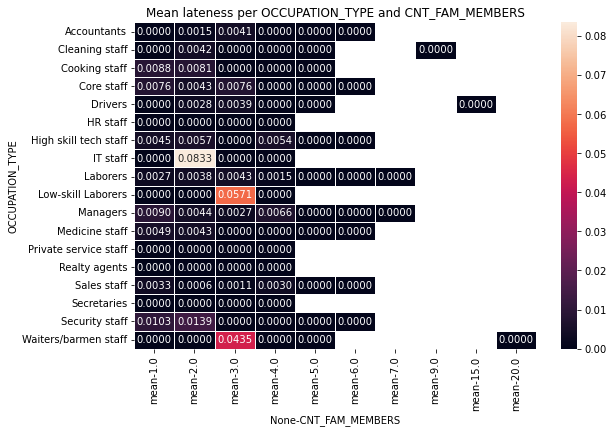

In [43]:
### 12. Heatmap relation comparison of late ratios vs feature pairs (OCCUPATION_TYPE vs ALL)
L1_features=['FLAG_PHONE', 'FLAG_EMAIL', 'OCCUPATION_TYPE', 'CNT_FAM_MEMBERS']

features_cat=['CODE_GENDER','FLAG_OWN_CAR','FLAG_OWN_REALTY', 'CNT_CHILDREN', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',  'NAME_FAMILY_STATUS',
'NAME_HOUSING_TYPE', 'FLAG_WORK_PHONE', 'FLAG_EMAIL', 'CNT_FAM_MEMBERS']
features_excl=['OCCUPATION_TYPE']

for el in features_cat:
    display(pd.pivot_table(app_and_credit_label_2,index='OCCUPATION_TYPE',columns=el,values='all_late_flag',aggfunc=['mean','count']))
    temp_table=pd.pivot_table(app_and_credit_label_2,index='OCCUPATION_TYPE',columns=el,values='all_late_flag',aggfunc=['mean'])
    f, ax = plt.subplots(figsize=(9, 6))
    plt.title('Mean lateness per {} and {}'.format('OCCUPATION_TYPE', el))
    sns.heatmap(temp_table, fmt='.4f',annot=True, linewidths=.5, ax=ax)
    plt.show()

In [ ]:
### 13. Heatmap relation comparison of late ratios vs feature pairs (CNT_FAM_MEMBERS vs ALL)
L1_features=['FLAG_PHONE', 'FLAG_EMAIL', 'OCCUPATION_TYPE', 'CNT_FAM_MEMBERS']

features_cat=['CODE_GENDER','FLAG_OWN_CAR','FLAG_OWN_REALTY', 'CNT_CHILDREN', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',  'NAME_FAMILY_STATUS',
'NAME_HOUSING_TYPE', 'FLAG_WORK_PHONE', 'FLAG_EMAIL', 'CNT_FAM_MEMBERS']
features_excl=['OCCUPATION_TYPE']

for el in features_cat:
    display(pd.pivot_table(app_and_credit_label_2,index='CNT_FAM_MEMBERS',columns=el,values='all_late_flag',aggfunc=['mean','count']))
    temp_table=pd.pivot_table(app_and_credit_label_2,index='CNT_FAM_MEMBERS',columns=el,values='all_late_flag',aggfunc=['mean'])
    f, ax = plt.subplots(figsize=(9, 6))
    plt.title('Mean lateness per {} and {}'.format('OCCUPATION_TYPE', el))
    sns.heatmap(temp_table, fmt='.4f',annot=True, linewidths=.5, ax=ax)
    plt.show()

In [ ]:
# for kol in values of kolumny
#     for row in rows:
#         sum all_lat
#         count all in row 

# app_and_credit_label_2['CODE_GENDER'].unique
# app_and_credit_label_2[[feat1==val1 & feat2==ral1]]

cols=app_and_credit_label_2['CODE_GENDER'].unique()
rows=app_and_credit_label_2['NAME_EDUCATION_TYPE'].unique()

print(cols)
print(rows)

col_ratio=[]
for i in cols:
    row_ratio=[]
    for j in rows:
        #print(i,j)
        data=app_and_credit_label_2[(app_and_credit_label_2['CODE_GENDER']==i) & (app_and_credit_label_2['NAME_EDUCATION_TYPE']==j)]['all_late_count']
        #print(data.sum(),data.count())
        row_ratio.append(data.sum() / data.count())
    col_ratio.append(row_ratio)
display(col_ratio)

cols1=['NAME_EDUCATION_TYPE']
cols1.extend(cols)
temp=pd.DataFrame(zip(rows,col_ratio[0],col_ratio[1]),columns=cols1).set_index('NAME_EDUCATION_TYPE')
display(temp)

temp.plot(kind='bar')



In [44]:
### 14. DASH APP taking features and comparing it agains one target

from dash import dash, dcc, html, Input, Output, State
import dash_bootstrap_components as dbc
import plotly.express as px

# app = Dash(__name__)
app = dash.Dash(external_stylesheets=[dbc.themes.BOOTSTRAP])

l1=app_and_credit_label_2.columns[1:17]
t1=app_and_credit_label_2.columns[-21:-3]

el1=dbc.Col(dcc.Graph(id='graph1'), md=6)
el2=dbc.Col(dcc.Graph(id='graph2'), md=6)
el3=dbc.Col(dcc.Graph(id='graph3'), md=6)
el4=dbc.Col(dcc.Graph(id='graph4'), md=6)

row1=dbc.Row([el1,el2])
row2=dbc.Row([el3,el4])

SIDEBAR_STYLE = {
    "position": "fixed",
    "top": 0,
    "left": 0,
    "bottom": 0,
    "width": "16rem",
    "padding": "2rem 1rem",
    "background-color": "#f8f9fa",
}

# the styles for the main content position it to the right of the sidebar and
# add some padding.
CONTENT_STYLE = {
    "margin-left": "18rem",
    "margin-right": "2rem",
    "padding": "2rem 1rem",
}

TEXT_STYLE={}

content = html.Div(
    [
    row1,
    row2,
    ],
    style=CONTENT_STYLE
)

controls = dbc.Form([
        dbc.CardHeader('Select Feature 1'),
        dbc.Card(dcc.Dropdown(l1,l1,id='l1_drop')),
        dbc.CardHeader('Select Feature 2'),       
        dbc.Card(dcc.Dropdown(l1,l1,id='l2_drop')),
        dbc.CardHeader('Select target'),       
        dbc.Card(dcc.Dropdown(t1,t1,id='l3_drop'))
    ])

sidebar = html.Div(
    [
        html.H2('Parameters', style=TEXT_STYLE),
        html.Hr(),
        controls
    ],
    style=SIDEBAR_STYLE,
)

app.layout = html.Div([sidebar,content])

@app.callback(
    Output('graph1', 'figure'),
    Output('graph2', 'figure'),
    Output('graph3', 'figure'),
    Output('graph4', 'figure'),
    # Output('graph5', 'figure'),
    # Output('graph6', 'figure'),
    Input('l1_drop', 'value'),
    Input('l2_drop','value'),
    Input('l3_drop','value')
    )

# def update_figure(l1_val,l2_val,t_val):
#     lst=[]
#     features_cat=['CODE_GENDER','FLAG_OWN_CAR','FLAG_OWN_REALTY','CNT_CHILDREN']
#     # features_cat.pop(features_cat.index(l1_val))
#     for el in features_cat:   
#         df=pd.pivot_table(app_and_credit_label_2,index=l1_val,columns=el,values='all_late_ratio',aggfunc='mean').round(4)    
#         lst.append(px.bar(df,barmode='group',text_auto=True))
#         # lst.append(px.violin(app_and_credit_label_2,x=l1_val,y='all_late_ratio',box=True))
#     for i in range(len(lst)):
#         lst[i].update_layout(transition_duration=500, hovermode='y unified')
#     return lst

def update_figure(l1_val,l2_val,t_val):
    lst=[]
    df=pd.pivot_table(app_and_credit_label_2,index=l1_val,columns=l2_val,values=t_val,aggfunc='mean',margins=True).round(4)    
    lst.append(px.bar(df,barmode='group',text_auto=True)),
    lst.append(px.histogram(app_and_credit_label_2[l1_val])),
    lst.append(px.imshow(df,color_continuous_scale='RdBu_r',text_auto=True)),
    lst.append(px.histogram(app_and_credit_label_2[t_val]))
    
#     # lst.append(px.histogram(df[l1_val]))
#     # lst.append(px.histogram(df[l2_val]))
#     # lst.append(px.violin(app_and_credit_label_2,x=l1_val,y='all_late_ratio',box=True))
    for i in range(len(lst)):
        lst[i].update_layout(transition_duration=500)
    lst[2].update_xaxes(type='category')
    return lst

if __name__ == '__main__':
    app.run_server()

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

 * Serving Flask app '__main__' (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:8050/ (Press CTRL+C to quit)
127.0.0.1 - - [07/Mar/2022 08:56:25] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [07/Mar/2022 08:56:26] "GET /_dash-layout HTTP/1.1" 200 -
127.0.0.1 - - [07/Mar/2022 08:56:26] "GET /_dash-dependencies HTTP/1.1" 200 -
127.0.0.1 - - [07/Mar/2022 08:56:26] "GET /_dash-component-suites/dash/dcc/async-dropdown.js HTTP/1.1" 200 -
127.0.0.1 - - [07/Mar/2022 08:56:26] "GET /_favicon.ico?v=2.2.0 HTTP/1.1" 200 -
127.0.0.1 - - [07/Mar/2022 08:56:26] "GET /_dash-component-suites/dash/dcc/async-plotlyjs.js HTTP/1.1" 200 -


Exception on /_dash-update-component [POST]
Traceback (most recent call last):
  File "C:\Users\User\anaconda3\envs\kivy_venv\lib\site-packages\flask\app.py", line 2073, in wsgi_app
    response = self.full_dispatch_request()
  File "C:\Users\User\anaconda3\envs\kivy_venv\lib\site-packages\flask\app.py", line 1518, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "C:\Users\User\anaconda3\envs\kivy_venv\lib\site-packages\flask\app.py", line 1516, in full_dispatch_request
    rv = self.dispatch_request()
  File "C:\Users\User\anaconda3\envs\kivy_venv\lib\site-packages\flask\app.py", line 1502, in dispatch_request
    return self.ensure_sync(self.view_functions[rule.endpoint])(**req.view_args)
  File "C:\Users\User\anaconda3\envs\kivy_venv\lib\site-packages\dash\dash.py", line 1344, in dispatch
    response.set_data(func(*args, outputs_list=outputs_list))
  File "C:\Users\User\anaconda3\envs\kivy_venv\lib\site-packages\dash\_callback.py", line 151, in add_context
   

127.0.0.1 - - [07/Mar/2022 08:56:26] "GET /_dash-component-suites/dash/dcc/async-graph.js HTTP/1.1" 200 -


Exception on /_dash-update-component [POST]
Traceback (most recent call last):
  File "C:\Users\User\anaconda3\envs\kivy_venv\lib\site-packages\flask\app.py", line 2073, in wsgi_app
    response = self.full_dispatch_request()
  File "C:\Users\User\anaconda3\envs\kivy_venv\lib\site-packages\flask\app.py", line 1518, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "C:\Users\User\anaconda3\envs\kivy_venv\lib\site-packages\flask\app.py", line 1516, in full_dispatch_request
    rv = self.dispatch_request()
  File "C:\Users\User\anaconda3\envs\kivy_venv\lib\site-packages\flask\app.py", line 1502, in dispatch_request
    return self.ensure_sync(self.view_functions[rule.endpoint])(**req.view_args)
  File "C:\Users\User\anaconda3\envs\kivy_venv\lib\site-packages\dash\dash.py", line 1344, in dispatch
    response.set_data(func(*args, outputs_list=outputs_list))
  File "C:\Users\User\anaconda3\envs\kivy_venv\lib\site-packages\dash\_callback.py", line 151, in add_context
   

127.0.0.1 - - [07/Mar/2022 08:56:26] "POST /_dash-update-component HTTP/1.1" 500 -


In [49]:
### 15. DASH APP taking features and 2 tagets to compare targets relation

from dash import dash, dcc, html, Input, Output, State
import dash_bootstrap_components as dbc
import plotly.express as px

# app = Dash(__name__)
app = dash.Dash(external_stylesheets=[dbc.themes.BOOTSTRAP])

l1=app_and_credit_label_2.columns[1:17]
t1=app_and_credit_label_2.columns[-21:-3]

el1=dbc.Col(dcc.Graph(id='graph1'), md=6)
el2=dbc.Col(dcc.Graph(id='graph2'), md=6)
el3=dbc.Col(dcc.Graph(id='graph3'), md=6)
el4=dbc.Col(dcc.Graph(id='graph4'), md=6)

row1=dbc.Row([el1,el2])
row2=dbc.Row([el3,el4])

SIDEBAR_STYLE = {
    "position": "fixed",
    "top": 0,
    "left": 0,
    "bottom": 0,
    "width": "16rem",
    "padding": "2rem 1rem",
    "background-color": "#f8f9fa",
}

# the styles for the main content position it to the right of the sidebar and
# add some padding.
CONTENT_STYLE = {
    "margin-left": "18rem",
    "margin-right": "2rem",
    "padding": "2rem 1rem",
}

TEXT_STYLE={}

content = html.Div(
    [
    row1,
    row2,
    ],
    style=CONTENT_STYLE
)

controls = dbc.Form([
        dbc.CardHeader('Select Feature 1'),
        dbc.Card(dcc.Dropdown(l1,l1,id='l1_drop')),
        dbc.CardHeader('Select Feature 2'),       
        dbc.Card(dcc.Dropdown(l1,l1,id='l2_drop')),
        dbc.CardHeader('Select target'),       
        dbc.Card(dcc.Dropdown(t1,t1,id='l3_drop')),
        dbc.CardHeader('Select target 2'),       
        dbc.Card(dcc.Dropdown(t1,t1,id='l4_drop'))
    ])

sidebar = html.Div(
    [
        html.H2('Parameters', style=TEXT_STYLE),
        html.H5('Enter all parameters to see all visualisations'),
        html.Hr(),
        controls
    ],
    style=SIDEBAR_STYLE,
)

app.layout = html.Div([sidebar,content])

@app.callback(
    Output('graph1', 'figure'),
    Output('graph2', 'figure'),
    Output('graph3', 'figure'),
    Output('graph4', 'figure'),
    # Output('graph5', 'figure'),
    # Output('graph6', 'figure'),
    Input('l1_drop', 'value'),
    Input('l2_drop','value'),
    Input('l3_drop','value'),
    Input('l4_drop','value')
    )

# def update_figure(l1_val,l2_val,t_val):
#     lst=[]
#     features_cat=['CODE_GENDER','FLAG_OWN_CAR','FLAG_OWN_REALTY','CNT_CHILDREN']
#     # features_cat.pop(features_cat.index(l1_val))
#     for el in features_cat:   
#         df=pd.pivot_table(app_and_credit_label_2,index=l1_val,columns=el,values='all_late_ratio',aggfunc='mean').round(4)    
#         lst.append(px.bar(df,barmode='group',text_auto=True))
#         # lst.append(px.violin(app_and_credit_label_2,x=l1_val,y='all_late_ratio',box=True))
#     for i in range(len(lst)):
#         lst[i].update_layout(transition_duration=500, hovermode='y unified')
#     return lst

def update_figure(l1_val,l2_val,t_val,t_val1):
    lst=[]
    df=pd.pivot_table(app_and_credit_label_2,index=l1_val,columns=l2_val,values=t_val,aggfunc='mean',margins=True).round(4)    
    lst.append(px.bar(df,barmode='group',text_auto=True,title="{} bad clients % by {} and {}".format(t_val,l1_val,l2_val))),
    lst.append(px.imshow(df,color_continuous_scale='RdBu_r',text_auto=True,title="{} bad clients % by {} and {}".format(t_val,l1_val,l2_val))),
    df=pd.pivot_table(app_and_credit_label_2,index=l1_val,columns=l2_val,values=t_val1,aggfunc='mean',margins=True).round(4)    
    lst.append(px.bar(df,barmode='group',text_auto=True,title="{} bad clients % by {} and {}".format(t_val1,l1_val,l2_val))),
    lst.append(px.imshow(df,color_continuous_scale='RdBu_r',text_auto=True,title="{} bad clients % by {} and {}".format(t_val1,l1_val,l2_val)))
    
#     # lst.append(px.histogram(df[l1_val]))
#     # lst.append(px.histogram(df[l2_val]))
#     # lst.append(px.violin(app_and_credit_label_2,x=l1_val,y='all_late_ratio',box=True))
    for i in range(len(lst)):
        lst[i].update_layout(transition_duration=500)
    lst[2].update_xaxes(type='category')
    return lst

if __name__ == '__main__':
    app.run_server()

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

 * Serving Flask app '__main__' (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:8050/ (Press CTRL+C to quit)
127.0.0.1 - - [07/Mar/2022 09:16:23] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [07/Mar/2022 09:16:24] "GET /_dash-layout HTTP/1.1" 200 -
127.0.0.1 - - [07/Mar/2022 09:16:24] "GET /_dash-dependencies HTTP/1.1" 200 -
127.0.0.1 - - [07/Mar/2022 09:16:24] "GET /_dash-component-suites/dash/dcc/async-dropdown.js HTTP/1.1" 200 -
127.0.0.1 - - [07/Mar/2022 09:16:24] "GET /_dash-component-suites/dash/dcc/async-graph.js HTTP/1.1" 200 -
127.0.0.1 - - [07/Mar/2022 09:16:24] "GET /_dash-component-suites/dash/dcc/async-plotlyjs.js HTTP/1.1" 200 -


Exception on /_dash-update-component [POST]
Traceback (most recent call last):
  File "C:\Users\User\anaconda3\envs\kivy_venv\lib\site-packages\flask\app.py", line 2073, in wsgi_app
    response = self.full_dispatch_request()
  File "C:\Users\User\anaconda3\envs\kivy_venv\lib\site-packages\flask\app.py", line 1518, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "C:\Users\User\anaconda3\envs\kivy_venv\lib\site-packages\flask\app.py", line 1516, in full_dispatch_request
    rv = self.dispatch_request()
  File "C:\Users\User\anaconda3\envs\kivy_venv\lib\site-packages\flask\app.py", line 1502, in dispatch_request
    return self.ensure_sync(self.view_functions[rule.endpoint])(**req.view_args)
  File "C:\Users\User\anaconda3\envs\kivy_venv\lib\site-packages\dash\dash.py", line 1344, in dispatch
    response.set_data(func(*args, outputs_list=outputs_list))
  File "C:\Users\User\anaconda3\envs\kivy_venv\lib\site-packages\dash\_callback.py", line 151, in add_context
   

127.0.0.1 - - [07/Mar/2022 09:16:24] "POST /_dash-update-component HTTP/1.1" 500 -


Exception on /_dash-update-component [POST]
Traceback (most recent call last):
  File "C:\Users\User\anaconda3\envs\kivy_venv\lib\site-packages\flask\app.py", line 2073, in wsgi_app
    response = self.full_dispatch_request()
  File "C:\Users\User\anaconda3\envs\kivy_venv\lib\site-packages\flask\app.py", line 1518, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "C:\Users\User\anaconda3\envs\kivy_venv\lib\site-packages\flask\app.py", line 1516, in full_dispatch_request
    rv = self.dispatch_request()
  File "C:\Users\User\anaconda3\envs\kivy_venv\lib\site-packages\flask\app.py", line 1502, in dispatch_request
    return self.ensure_sync(self.view_functions[rule.endpoint])(**req.view_args)
  File "C:\Users\User\anaconda3\envs\kivy_venv\lib\site-packages\dash\dash.py", line 1344, in dispatch
    response.set_data(func(*args, outputs_list=outputs_list))
  File "C:\Users\User\anaconda3\envs\kivy_venv\lib\site-packages\dash\_callback.py", line 151, in add_context
   

127.0.0.1 - - [07/Mar/2022 09:16:29] "POST /_dash-update-component HTTP/1.1" 500 -


Exception on /_dash-update-component [POST]
Traceback (most recent call last):
  File "C:\Users\User\anaconda3\envs\kivy_venv\lib\site-packages\flask\app.py", line 2073, in wsgi_app
    response = self.full_dispatch_request()
  File "C:\Users\User\anaconda3\envs\kivy_venv\lib\site-packages\flask\app.py", line 1518, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "C:\Users\User\anaconda3\envs\kivy_venv\lib\site-packages\flask\app.py", line 1516, in full_dispatch_request
    rv = self.dispatch_request()
  File "C:\Users\User\anaconda3\envs\kivy_venv\lib\site-packages\flask\app.py", line 1502, in dispatch_request
    return self.ensure_sync(self.view_functions[rule.endpoint])(**req.view_args)
  File "C:\Users\User\anaconda3\envs\kivy_venv\lib\site-packages\dash\dash.py", line 1344, in dispatch
    response.set_data(func(*args, outputs_list=outputs_list))
  File "C:\Users\User\anaconda3\envs\kivy_venv\lib\site-packages\dash\_callback.py", line 151, in add_context
   

127.0.0.1 - - [07/Mar/2022 09:16:31] "POST /_dash-update-component HTTP/1.1" 500 -


Exception on /_dash-update-component [POST]
Traceback (most recent call last):
  File "C:\Users\User\anaconda3\envs\kivy_venv\lib\site-packages\flask\app.py", line 2073, in wsgi_app
    response = self.full_dispatch_request()
  File "C:\Users\User\anaconda3\envs\kivy_venv\lib\site-packages\flask\app.py", line 1518, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "C:\Users\User\anaconda3\envs\kivy_venv\lib\site-packages\flask\app.py", line 1516, in full_dispatch_request
    rv = self.dispatch_request()
  File "C:\Users\User\anaconda3\envs\kivy_venv\lib\site-packages\flask\app.py", line 1502, in dispatch_request
    return self.ensure_sync(self.view_functions[rule.endpoint])(**req.view_args)
  File "C:\Users\User\anaconda3\envs\kivy_venv\lib\site-packages\dash\dash.py", line 1344, in dispatch
    response.set_data(func(*args, outputs_list=outputs_list))
  File "C:\Users\User\anaconda3\envs\kivy_venv\lib\site-packages\dash\_callback.py", line 151, in add_context
   

127.0.0.1 - - [07/Mar/2022 09:16:35] "POST /_dash-update-component HTTP/1.1" 500 -
127.0.0.1 - - [07/Mar/2022 09:16:37] "POST /_dash-update-component HTTP/1.1" 200 -


In [ ]:
#VARIOUS CALCULATIONS

#Which lateness type to take - graphs showing lateness composition - without 0 as those consitute 40%
temp_table=pd.pivot_table(app_and_credit_label_2,index=['start_mth'],values=['1_ratio','2_ratio','3_ratio','4_ratio','5_ratio'])
temp_table

display(sns.lineplot(data=temp_table))

# Do late count & late ratio produce same results? Question of whether a ratio of sums is same as mean of ratios - its not
# Step 1 calculate sum of counts
temp_table=pd.pivot_table(app_and_credit_label_2,index='NAME_EDUCATION_TYPE',columns='CODE_GENDER',values=['all_late_count'],aggfunc=['sum','count'])
display(temp_table)

#Calculate ratios of those above
temp_table['Ratio_F']=temp_table.iloc[:,0]/temp_table.iloc[:,2]
temp_table['Ratio_M']=temp_table.iloc[:,1]/temp_table.iloc[:,3]
display(temp_table)

#calculate those with mean function
temp_table2=pd.pivot_table(app_and_credit_label_2,index='NAME_EDUCATION_TYPE',columns='CODE_GENDER',values=['all_late_count'],aggfunc=['mean'])
display(temp_table2)

#calculate data=app_and_credit_label_2
tt=pd.crosstab(index=data['NAME_EDUCATION_TYPE'],columns=data['CODE_GENDER'],values=data['all_late_count'],aggfunc=['sum','count'],normalize='index')
display(tt)

In [ ]:
#VARIOUS PROTOTYPES

#Function that takes one feature, target then iterates through the rest of featuers and for each pair makes a pivot and draws a bar plot.
def draw_analysis(L1_feature,target_feature):
    ''' Function prints comparison tables & charts for column provided as L1 and all other columns in set and aggregates via target features'''
    features=['CODE_GENDER','FLAG_OWN_CAR','FLAG_OWN_REALTY', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',  'NAME_FAMILY_STATUS',
    'NAME_HOUSING_TYPE', 'FLAG_WORK_PHONE', 'FLAG_PHONE', 'FLAG_EMAIL', 'OCCUPATION_TYPE','CNT_FAM_MEMBERS']
    L2_featuers_disc= ['AMT_INCOME_TOTAL','DAYS_BIRTH', 'DAYS_EMPLOYED']
    features.pop(features.index(L1_feature))
    for el in features:
        display(pd.pivot_table(app_and_credit_label_2,index=el,columns=L1_feature,values=target_feature,aggfunc=['mean','sum','count']))
        temp_table=pd.pivot_table(app_and_credit_label_2,index=el,columns=L1_feature,values=target_feature,aggfunc='mean')
        temp_table.plot(kind='bar')
        plt.title('% of bad clients per {} (rows) and {} (color)'.format(el,L1_feature))
        plt.legend(bbox_to_anchor = (1.05, 0.6))    
        plt.show()